## Extracting 3D Landmark positions from 2D pixel values gotten from SBR

The purpose of this page is to:
1. gather all the .bag, and the corresponsing csv_info, and 2d_pixel_files generated by sbr algorithm into the same look up table
2. get 3d landmark positions by using .bag, csv_info and 2d_pixel files 

3. generate lookup table for .rssdk, color_avi, and depth_avi, and 2d_pixel files
3. use above to calculate 3d landmark postions

In [1]:
# Copyright (c) Facebook, Inc. and its affiliates.
# All rights reserved.
#
# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
#
from __future__ import division

import torch, argparse
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import numpy as np
import os
from datasets import GeneralDataset as Dataset
from xvision  import transforms, draw_image_by_points 
from models   import obtain_model, remove_module_dict
from config_utils import load_configure
from face_alignment import api as face_alignment
import cv2
import pandas as pd
# GOT ERROR: No module named 'face_alignment.detection.blazeface'
from face_alignment.detection.blazeface import blazeface_detector
from multiprocessing import Process
# face detector used by Diego in FAN analysis
from face_alignment.detection.sfd import sfd_detector
import warnings
import subprocess 
import matplotlib.pyplot as plt
import pyrealsense2 as rs
from sbr_functions import *

# Extracting 3D info from 2D 68 landmark pixel values extracted using SBR 

### tESTING READING DF and manipulations 

In [3]:
sbr_pixel_path = r'/media/deniz/easystore/facial_tracking_data_2021/ALS/AF18_SBK_20190826/02/LANDMARKS/Deniz_SBR/AF18_02_20190826_NSM_OPEN_color_SBR_3D_landmarks.csv'
df = pd.read_csv(sbr_pixel_path, index_col=0)

print(len(df))
df.head()

541


,Video_Frame_number,landmark_0_x,landmark_0_y,landmark_0_z,landmark_1_x,landmark_1_y,landmark_1_z,landmark_2_x,landmark_2_y,landmark_2_z,...,landmark_64_z,landmark_65_x,landmark_65_y,landmark_65_z,landmark_66_x,landmark_66_y,landmark_66_z,landmark_67_x,landmark_67_y,landmark_67_z
0,1,253.59174,225.39987,0.555635,260.66595,246.72278,0.459428,267.75010,269.14307,0.472545,...,0.558477,360.25757,289.80344,0.779493,353.35632,291.10590,0.716023,347.43988,291.86600,0.578806
1,2,255.18470,225.09676,0.556448,261.76834,246.20358,0.467114,268.04700,267.95013,0.517779,...,0.544382,360.15710,288.73242,0.853489,353.34143,289.70023,0.824947,346.87280,290.65933,0.692546
2,3,254.05510,231.92213,0.633899,260.94128,253.34012,0.539732,267.81583,274.95110,0.573503,...,0.546021,360.57153,289.19333,0.715465,354.27070,290.21045,0.735222,348.13004,290.86154,0.652663
3,4,255.55200,226.25871,0.503461,260.07550,248.28190,0.571712,265.87085,270.74426,0.540634,...,0.534775,360.90020,292.20440,0.592434,353.65370,293.08316,0.627789,345.57495,293.08460,0.627092
4,5,256.29242,228.16806,0.424257,260.75168,250.14240,0.725224,266.25770,271.47983,0.741734,...,0.437241,360.96414,291.78763,0.591578,353.66882,292.82270,0.643043,346.18793,293.39423,0.687411


In [4]:
df_new = df

for col in df_new.columns:
    if 'z'in col:
        df_new = df_new.drop([col], axis = 1)
        
print(df_new.shape)
df_new.head()

(541, 137)


,Video_Frame_number,landmark_0_x,landmark_0_y,landmark_1_x,landmark_1_y,landmark_2_x,landmark_2_y,landmark_3_x,landmark_3_y,landmark_4_x,...,landmark_63_x,landmark_63_y,landmark_64_x,landmark_64_y,landmark_65_x,landmark_65_y,landmark_66_x,landmark_66_y,landmark_67_x,landmark_67_y
0,1,253.59174,225.39987,260.66595,246.72278,267.75010,269.14307,272.96033,290.08224,282.23865,...,359.67114,286.11000,371.74066,290.03778,360.25757,289.80344,353.35632,291.10590,347.43988,291.86600
1,2,255.18470,225.09676,261.76834,246.20358,268.04700,267.95013,273.37000,288.93365,282.18268,...,359.80347,286.53850,371.82043,290.00174,360.15710,288.73242,353.34143,289.70023,346.87280,290.65933
2,3,254.05510,231.92213,260.94128,253.34012,267.81583,274.95110,275.95462,296.60364,287.34467,...,360.80936,287.94855,371.27643,290.70575,360.57153,289.19333,354.27070,290.21045,348.13004,290.86154
3,4,255.55200,226.25871,260.07550,248.28190,265.87085,270.74426,272.80573,293.43195,283.54083,...,360.20764,285.90927,373.12744,291.10028,360.90020,292.20440,353.65370,293.08316,345.57495,293.08460
4,5,256.29242,228.16806,260.75168,250.14240,266.25770,271.47983,272.80844,292.94040,283.07706,...,360.05148,286.12943,373.22490,290.90137,360.96414,291.78763,353.66882,292.82270,346.18793,293.39423


In [5]:
x = df_new
y = df_new

In [6]:
for col in df_new.columns:
    if 'y'in col:
        x = x.drop([col], axis = 1)
    elif 'x' in col:
        y = y.drop([col], axis = 1)
    

In [7]:
x.head()

,Video_Frame_number,landmark_0_x,landmark_1_x,landmark_2_x,landmark_3_x,landmark_4_x,landmark_5_x,landmark_6_x,landmark_7_x,landmark_8_x,...,landmark_58_x,landmark_59_x,landmark_60_x,landmark_61_x,landmark_62_x,landmark_63_x,landmark_64_x,landmark_65_x,landmark_66_x,landmark_67_x
0,1,253.59174,260.66595,267.75010,272.96033,282.23865,294.75098,312.80430,334.86145,356.16486,...,347.33210,334.66790,326.70750,346.84613,353.28845,359.67114,371.74066,360.25757,353.35632,347.43988
1,2,255.18470,261.76834,268.04700,273.37000,282.18268,293.79684,311.05353,334.37924,355.88610,...,347.28820,334.39886,326.44662,346.58603,353.19153,359.80347,371.82043,360.15710,353.34143,346.87280
2,3,254.05510,260.94128,267.81583,275.95462,287.34467,301.89282,319.62787,339.50580,359.70303,...,349.28980,335.87880,327.30447,347.87964,354.19318,360.80936,371.27643,360.57153,354.27070,348.13004
3,4,255.55200,260.07550,265.87085,272.80573,283.54083,297.91522,316.39026,336.83215,357.54608,...,346.41595,334.19446,326.41320,346.24808,352.79590,360.20764,373.12744,360.90020,353.65370,345.57495
4,5,256.29242,260.75168,266.25770,272.80844,283.07706,297.54443,316.50854,337.29840,356.88083,...,347.12012,334.82550,326.78146,346.33432,352.97020,360.05148,373.22490,360.96414,353.66882,346.18793


In [8]:
y.head()

,Video_Frame_number,landmark_0_y,landmark_1_y,landmark_2_y,landmark_3_y,landmark_4_y,landmark_5_y,landmark_6_y,landmark_7_y,landmark_8_y,...,landmark_58_y,landmark_59_y,landmark_60_y,landmark_61_y,landmark_62_y,landmark_63_y,landmark_64_y,landmark_65_y,landmark_66_y,landmark_67_y
0,1,225.39987,246.72278,269.14307,290.08224,309.59238,326.99997,338.96222,347.20210,347.21515,...,302.92767,302.28020,295.47372,287.55580,286.87973,286.11000,290.03778,289.80344,291.10590,291.86600
1,2,225.09676,246.20358,267.95013,288.93365,308.84503,326.55260,338.95386,347.48157,346.99800,...,302.90485,302.56445,295.46356,288.13586,287.53912,286.53850,290.00174,288.73242,289.70023,290.65933
2,3,231.92213,253.34012,274.95110,296.60364,316.77277,332.54010,343.04572,349.02393,346.34613,...,301.48080,301.98642,296.04990,289.73060,288.89160,287.94855,290.70575,289.19333,290.21045,290.86154
3,4,226.25871,248.28190,270.74426,293.43195,314.34808,332.18950,342.93823,349.32706,348.78230,...,305.73740,303.87576,295.24817,287.30830,286.77026,285.90927,291.10028,292.20440,293.08316,293.08460
4,5,228.16806,250.14240,271.47983,292.94040,313.70084,330.76883,341.94788,348.42633,347.43720,...,305.82470,304.34420,295.72156,287.80603,287.24000,286.12943,290.90137,291.78763,292.82270,293.39423


In [9]:
finetuned_fan_pixel_path = r'/media/deniz/easystore/facial_tracking_data_2021/ALS/AF18_SBK_20190826/02/LANDMARKS/Diego_FaceData/landmarks_finetuned_w15/AF18_02_NSM_OPEN_landmarksFiltered.csv'
df2 = pd.read_csv(finetuned_fan_pixel_path, index_col=0)

for col in df2.columns:
    if 'bbox'in col or 'Time' in col:
        df2 = df2.drop([col], axis = 1)
        
print(df2.shape)
df2.head()

(541, 137)


,Video_Frame_number,landmark_0_x,landmark_0_y,landmark_1_x,landmark_1_y,landmark_2_x,landmark_2_y,landmark_3_x,landmark_3_y,landmark_4_x,...,landmark_63_x,landmark_63_y,landmark_64_x,landmark_64_y,landmark_65_x,landmark_65_y,landmark_66_x,landmark_66_y,landmark_67_x,landmark_67_y
0,0,233.0,214.0,237.0,235.0,246.0,255.0,255.0,273.0,266.0,...,357.0,281.0,367.0,281.0,357.0,280.0,348.0,281.0,339.0,281.0
1,1,236.0,215.0,242.0,235.0,249.0,255.0,259.0,274.0,269.0,...,357.0,282.0,367.0,281.0,357.0,280.0,348.0,282.0,339.0,282.0
2,2,237.0,215.0,242.0,236.0,250.0,260.0,260.0,275.0,270.0,...,357.0,285.0,367.0,285.0,358.0,282.0,348.0,283.0,339.0,285.0
3,3,249.0,222.0,253.0,246.0,257.0,267.0,264.0,287.0,274.0,...,359.0,286.0,367.0,289.0,359.0,289.0,349.0,291.0,339.0,292.0
4,4,249.0,222.0,253.0,246.0,257.0,267.0,265.0,288.0,274.0,...,359.0,286.0,368.0,289.0,359.0,289.0,349.0,291.0,340.0,292.0


In [11]:
x_fan = df2
y_fan = df2
for col in df_new.columns:
    if 'y'in col:
        x_fan = x_fan.drop([col], axis = 1)
    elif 'x' in col:
        y_fan = y_fan.drop([col], axis = 1)

In [12]:
x_fan.iloc[0]

Video_Frame_number      0.0
landmark_0_x          233.0
landmark_1_x          237.0
landmark_2_x          246.0
landmark_3_x          255.0
                      ...  
landmark_63_x         357.0
landmark_64_x         367.0
landmark_65_x         357.0
landmark_66_x         348.0
landmark_67_x         339.0
Name: 0, Length: 69, dtype: float64

In [13]:
info_file = r'/media/deniz/easystore/facial_tracking_data_2021/ALS/AF18_SBK_20190826/02/RSSDK/AF18_02_20190826_NSM_OPEN_frameInfoColor.csv'


df3 = pd.read_csv(info_file, index_col=0)
print(len(df3))
df3.head()


541


,BAG_Frame_Number,Frame_Time_Stamp,Frame_Number_in_Video
0,7,0.000000,0
1,8,0.033399,1
2,9,0.066799,2
3,10,0.100198,3
4,11,0.133597,4


In [14]:
from sbr_functions import get3dlandmarks

BAG_File = r'/media/deniz/easystore/facial_tracking_data_2021/ALS/AF18_SBK_20190826/02/RSSDK/AF18_02_20190826_NSM_OPEN.bag'

cvs_frame_info = r'/media/deniz/easystore/facial_tracking_data_2021/ALS/AF18_SBK_20190826/02/RSSDK/AF18_02_20190826_NSM_OPEN_frameInfoColor.csv'

landmark_file = r'/media/deniz/easystore/facial_tracking_data_2021/ALS/AF18_SBK_20190826/02/LANDMARKS/Deniz_SBR/AF18_02_20190826_NSM_OPEN_color_SBR_3D_landmarks.csv'


get3dlandmarks(BAG_File, cvs_frame_info, landmark_file)

[253.59174 225.39987 260.66595 246.72278 267.7501  269.14307 272.96033
 290.08224 282.23865 309.59238 294.75098 326.99997 312.8043  338.96222
 334.86145 347.2021  356.16486 347.21515 375.28436 340.81232 392.2338
 328.60986 405.72662 312.98834 412.9682  294.79077 415.69675 275.3614
 416.19543 252.62589 416.72418 231.69695 413.17847 210.39606 272.0246
 202.57474 281.19937 191.15453 295.51178 184.8181  311.65186 184.79724
 325.78497 188.11775 356.97784 184.78174 368.49695 178.40253 381.898
 175.65346 394.41406 178.39095 403.26938 186.74454 344.0512  203.94836
 346.0703  215.69904 348.28247 226.56242 349.40787 239.3013  333.89648
 257.81183 341.42456 259.6945  350.67725 261.22882 358.19    257.546
 364.591   254.33192 288.1749  216.2067  296.65704 208.51685 307.3079
 206.55002 318.1576  211.15671 309.05594 216.18698 297.47955 217.55539
 362.5594  207.76656 371.63306 200.69392 381.71878 200.31862 391.1723
 205.44028 382.8822  208.13248 372.23907 208.80139 321.3291  295.65704
 334.13455 285.

[255.552   226.25871 260.0755  248.2819  265.87085 270.74426 272.80573
 293.43195 283.54083 314.34808 297.91522 332.1895  316.39026 342.93823
 336.83215 349.32706 357.54608 348.7823  376.5016  342.73822 393.1856
 330.40796 405.65942 314.2823  411.69727 295.34485 415.265   276.8183
 416.287   256.23083 416.58112 235.32942 414.5162  214.65634 272.8554
 204.38126 280.5873  191.47324 292.72556 185.4941  308.81033 184.27989
 322.8235  187.69281 357.08133 183.93439 368.22626 178.82513 381.0462
 176.34775 393.9981  179.02672 402.72156 186.85548 344.05902 204.09415
 345.2702  215.33475 347.37164 226.1562  349.79877 239.12666 333.5087
 258.5545  341.83698 260.1056  350.64563 261.3332  357.69266 258.30203
 363.50104 255.44171 288.93155 216.95277 297.16562 209.25006 306.89835
 207.30466 318.27948 212.17007 308.71265 216.62585 298.46445 218.29172
 363.3193  208.65057 371.95325 201.79367 381.95584 201.51459 391.46573
 206.18698 383.10742 209.58997 372.5205  210.27307 321.82614 295.8017
 333.74197 2

[255.85371 227.30637 260.7005  249.47028 266.69855 271.4973  273.7591
 293.24396 283.86682 314.5517  298.29883 331.87207 317.5422  342.29407
 338.48453 349.14117 357.97156 347.30585 377.81506 341.70917 393.78442
 329.6092  405.3919  314.74512 411.80032 295.45358 415.72562 276.8045
 416.51282 257.0886  416.6234  236.79439 416.01562 216.29959 273.9731
 203.3763  281.90717 190.93633 295.91785 185.3653  311.9134  185.08383
 325.855   188.59691 355.85922 185.00574 368.09485 179.38638 381.8783
 177.06345 395.1516  180.18536 404.32193 188.76163 344.4184  204.28394
 346.4983  215.84879 348.63043 226.82706 351.1366  240.40248 334.68488
 258.82706 343.01767 260.47742 350.6644  261.44086 357.88788 258.32498
 365.08563 255.19188 289.62265 216.58139 297.61148 209.38452 307.66293
 207.55054 318.88828 211.79916 309.4219  216.29208 299.17902 217.93497
 364.13187 208.99054 372.7356  201.84662 382.52405 201.74664 391.7433
 206.80026 383.57288 210.1789  373.29034 210.80618 322.04837 295.87457
 335.12292 

[257.4788  227.81647 261.46307 249.57242 267.18954 271.07812 273.95786
 293.4827  284.14008 315.00745 298.91702 332.13135 317.60556 342.22156
 337.44232 348.58646 358.0381  347.656   377.18958 342.49722 393.7336
 330.68274 406.325   314.9217  412.92465 296.74008 416.38287 277.43066
 417.21985 257.08356 417.80798 236.50412 416.90698 216.20624 273.79077
 204.55301 281.81543 191.76988 295.31134 185.5419  311.8921  184.4915
 326.22485 188.44498 357.73224 184.80125 369.3647  179.3601  382.80148
 177.52948 395.05743 180.22403 404.11765 188.08035 345.32523 204.78671
 347.47314 216.17973 349.76642 226.99847 351.1253  240.6621  336.22345
 258.2134  344.25568 259.9956  351.40997 261.21478 358.513   258.1938
 365.65094 255.09064 290.87567 216.80493 298.97562 209.75314 308.9017
 207.64476 319.83643 212.06479 310.51743 216.4343  300.50705 218.13226
 364.87277 209.09247 373.54327 202.15106 383.3755  201.95514 392.85983
 206.6102  384.3108  209.88339 373.98447 210.59468 323.5359  295.19235
 335.9787 

[257.68808 227.9892  261.991   249.50626 267.35364 271.736   274.4498
 293.3092  284.9892  313.4687  299.44647 331.00412 317.68118 341.2373
 337.92145 347.88348 359.33893 347.1547  378.43512 342.42194 395.3125
 330.33582 407.92517 314.71414 414.45367 297.19824 417.88583 278.3532
 418.28156 257.16895 418.57822 237.4418  417.6686  217.3372  275.86362
 202.49854 283.838   190.90254 296.8564  185.47725 312.16632 184.69818
 325.07623 187.60315 359.81592 185.01451 371.6121  179.74799 385.1307
 178.10265 397.5473  181.01436 406.1264  189.68091 345.93488 204.54628
 348.19946 216.13454 350.54828 227.04924 353.20862 240.53613 336.09616
 259.02557 344.4096  260.6192  352.0944  261.41138 360.23505 259.05115
 365.91827 256.70383 291.72437 216.83104 299.80634 209.78699 309.76254
 207.93492 320.9045  212.36452 311.3537  216.63022 301.25983 218.25146
 366.17346 208.58994 374.7481  201.68796 384.64346 201.99107 393.9264
 207.39816 385.4606  209.96706 375.0165  210.49747 324.60944 294.8944
 337.14923 28

[257.81317 225.21056 262.24686 248.43088 267.25333 270.27747 274.8053
 292.5924  285.80963 313.16577 299.57916 330.6236  318.14676 340.54968
 340.10532 346.85645 359.96814 346.12503 378.91284 341.6162  395.89508
 330.1483  409.18808 315.56805 415.4541  296.45325 419.06802 278.03442
 419.79074 257.94952 419.7528  237.36763 418.5666  217.30548 277.0055
 203.84215 284.31964 191.77829 297.56    184.80746 314.11545 184.48106
 327.93    187.79758 361.53296 184.9326  373.29718 180.2383  386.3656
 178.71107 398.25183 181.46167 406.87134 189.59833 347.2705  204.2703
 349.4848  216.06546 351.91006 227.43633 354.55658 241.14345 338.22415
 259.23325 346.1146  260.64633 353.7193  261.53198 360.57788 258.6254
 367.43634 255.66055 293.43716 215.90952 300.96112 209.28922 311.3018
 207.45404 322.32727 212.69908 312.90625 216.44089 302.5967  217.7442
 367.42813 208.63431 375.40027 201.78577 386.20514 202.18759 395.5964
 207.34415 387.11737 210.55548 376.47937 210.95662 325.13574 294.57654
 338.3906  286

[259.70132 228.71802 263.74707 248.77219 268.3972  270.69595 275.35553
 292.4972  285.93448 312.269   299.30038 328.7603  318.16885 338.36044
 339.09253 344.56177 359.1006  344.38525 377.98392 340.3224  395.25293
 329.93036 407.07214 315.36096 414.66693 298.753   419.1812  278.92975
 420.2461  259.80634 420.6262  239.95624 419.64978 219.41031 277.1086
 204.56639 284.6552  191.20581 297.14417 185.02339 313.54968 184.34431
 327.23254 187.21107 361.86664 184.35872 374.52692 180.1337  388.02203
 178.71263 400.202   182.1524  408.5666  190.54669 348.34506 204.56485
 350.70508 216.25919 353.14905 227.40253 354.56067 241.1018  338.52206
 259.5688  346.39453 260.45746 355.10535 261.56317 362.17606 259.06522
 367.5727  256.91968 293.595   215.85025 301.4208  208.87138 311.73932
 206.82909 322.54028 212.60587 313.43494 216.1113  302.93933 217.52844
 368.95004 208.89676 376.64636 202.13116 387.32492 202.44379 396.66144
 207.83858 388.1877  210.68338 377.71848 211.07114 324.67755 294.26047
 337.21

[259.6064  225.31989 263.39606 248.18881 269.0943  270.39264 275.72528
 291.69635 285.0431  311.701   300.3011  328.55685 319.44406 338.02612
 339.9419  344.20306 359.89233 344.29932 380.40155 341.20465 397.8064
 330.6554  410.74908 315.52127 417.8344  296.42117 420.12936 276.98724
 419.74036 256.78708 421.3487  239.05974 421.46115 220.74506 278.234
 203.79684 285.77307 190.60245 299.28815 184.72906 314.74216 184.65738
 328.28345 187.48071 364.48816 184.56152 376.45508 180.70493 389.45587
 179.39297 402.25165 183.17624 409.50134 191.69606 349.51202 204.84921
 351.0045  216.13266 353.21893 227.46574 355.34125 240.55261 339.44592
 259.94534 347.272   260.5609  355.6291  261.7464  362.85095 259.2025
 368.50363 256.50085 293.89966 216.3717  302.11786 209.32501 313.39203
 206.76787 322.88843 212.52174 314.8708  216.35416 303.57068 218.08687
 369.17645 209.01541 377.65265 202.19218 387.98505 202.52824 396.95953
 208.22726 388.83224 210.75201 378.66852 210.69708 324.69894 294.3859
 337.9596  

[259.69138 223.9625  263.8246  247.1897  269.2073  270.3068  275.6032
 291.8059  285.69385 311.8004  300.30402 328.69965 319.69193 337.91888
 340.8056  344.77557 361.15082 344.70203 380.6671  340.20905 397.85767
 329.58417 409.6286  315.1969  417.08893 297.27277 421.70673 278.7277
 422.48364 258.02585 422.1872  238.15248 420.68826 217.75273 277.99084
 204.84941 285.94617 191.83452 299.82642 185.38873 315.0737  184.61623
 328.49677 187.45956 364.7729  184.74905 376.27228 180.487   388.81326
 179.33804 400.8658  182.27917 409.62054 189.8436  350.1202  204.74797
 351.6015  216.15437 353.82254 227.48991 355.91333 240.70117 339.64716
 259.9537  347.6199  260.64957 356.212   261.71915 363.68176 258.71124
 369.34073 256.44128 294.59644 216.42712 303.17447 208.687   314.59485
 206.63382 324.44547 212.99028 315.27045 217.08826 304.47818 218.52164
 369.38153 209.1882  377.9089  202.20506 388.45352 202.29779 397.635
 208.33017 389.4712  211.43353 379.1099  211.40448 325.8462  294.0087
 338.5719  

[259.23657 225.98103 264.17398 248.01996 269.2542  269.25806 275.67743
 290.44455 285.0841  310.5932  299.44522 327.35065 318.68362 337.91882
 339.39722 344.68048 359.35468 344.72577 379.2957  341.0011  396.1501
 329.6195  408.48138 315.513   416.41068 297.02533 421.36853 278.60413
 422.6764  257.76923 422.67786 237.41109 420.26398 216.38654 278.62238
 201.96216 286.6605  191.16382 300.1018  185.47867 316.2216  185.45668
 329.5833  189.11867 364.3167  185.08878 375.72882 180.60054 388.70923
 179.01521 401.46896 182.13914 409.31894 190.33725 349.12695 204.72461
 351.44983 216.76378 353.667   228.013   355.97333 241.28693 339.6089
 260.137   347.62808 260.59708 356.39587 261.42035 363.67657 258.9767
 369.3207  256.765   294.24554 216.19481 302.7114  208.70035 313.51404
 206.89273 324.82617 212.41216 315.24265 217.13223 303.9684  218.81192
 368.8982  209.12561 377.71912 202.18117 388.3784  202.37143 397.74277
 208.04865 389.3623  210.89243 378.97455 210.98027 326.06924 293.6709
 339.4984 

[258.90826 225.09296 262.91025 246.85443 268.8827  268.39316 275.84387
 290.46854 285.36862 310.91925 300.3158  327.48074 319.8529  337.50964
 340.40295 344.30597 360.09497 344.31583 379.7597  340.21234 395.92865
 329.35638 408.28442 314.35938 415.57928 295.88654 419.82635 277.06006
 420.54694 256.97534 421.53845 238.16364 420.47873 218.46002 278.02008
 203.38875 286.28558 191.12027 299.36734 185.42833 315.65582 184.7406
 328.99792 188.3256  363.9724  184.79788 375.7845  180.63365 388.64478
 179.04114 401.54803 181.93094 409.46045 189.07425 349.64307 204.41919
 351.23093 216.83238 353.33362 228.93939 355.15228 241.20624 339.69507
 260.43066 347.55295 260.46414 355.8448  261.03705 363.23068 259.161
 368.39532 257.86484 293.8792  216.24728 302.3426  208.34853 312.88385
 206.44714 324.08887 212.07425 314.6053  216.77391 303.56174 218.40518
 369.44965 209.18109 377.97076 201.87283 388.9099  202.1308  398.13348
 208.0282  389.82013 211.1091  379.21033 211.30956 325.67896 293.35373
 338.2063

[259.844   226.3476  263.46985 247.32724 268.31268 268.17026 275.84863
 289.075   284.62692 308.99857 298.24023 326.23145 317.22125 337.16086
 338.5869  344.7648  359.80902 345.2962  380.12573 340.10773 397.86438
 328.802   409.3712  313.35498 416.19574 295.1972  418.9641  276.68176
 419.52814 256.80994 422.2881  239.6361  422.2466  219.96288 278.36575
 202.52325 286.2367  190.99683 299.85272 185.56161 316.06903 184.70107
 329.50888 187.64436 364.39636 185.0629  376.2086  180.29233 388.97174
 179.25343 401.76227 181.7911  409.69333 190.64893 349.2829  204.40057
 350.65808 217.00844 352.95328 229.56055 354.85947 241.90298 340.1837
 260.32907 347.24365 260.17627 355.3292  260.9054  362.465   259.22714
 367.63434 258.0515  293.98438 215.91574 302.5307  207.61475 313.2835
 206.32942 325.086   212.24304 315.21542 216.53918 303.6456  217.59366
 369.24213 208.60999 377.7859  201.66515 388.18246 202.18779 397.46814
 207.22925 389.0964  209.92215 378.73016 209.88055 326.61923 292.6045
 337.973 

[259.6654  225.6384  263.6742  246.19995 268.7769  268.59448 275.4082
 289.88892 285.9438  309.22275 299.37228 326.05814 317.44824 337.48334
 337.72723 345.17688 358.88153 345.28937 378.92633 340.40137 394.57483
 328.85318 406.4016  314.31656 414.2057  296.73383 418.54697 276.852
 420.45264 257.69794 421.8727  238.98477 419.66443 217.84537 278.8633
 201.8078  286.03604 190.34293 300.08722 184.62975 316.93332 184.06656
 330.432   187.31375 364.75848 184.239   377.1363  179.84776 389.9306
 178.5549  402.32553 182.1843  409.90582 191.19308 350.33893 204.02377
 351.52487 215.49475 353.6171  228.68501 355.75665 240.91864 339.6055
 260.33682 347.40057 260.32922 355.61658 260.75208 362.93274 258.8248
 368.24493 257.84375 293.84824 215.82114 302.92358 208.11972 314.15924
 206.3393  325.23688 211.52979 315.9438  215.96617 303.99127 218.22653
 369.48663 208.39558 377.78058 201.52197 388.48724 201.54977 397.81604
 207.95253 389.59915 210.70326 378.89264 210.8663  325.04602 292.04083
 337.5653  28

[259.6239  223.0957  263.87457 245.9046  270.18387 267.5564  276.87292
 290.3078  286.8621  311.0816  298.94547 330.02988 316.70746 341.9148
 337.88165 350.42834 360.15778 351.72876 380.87793 344.01758 397.35806
 330.0629  407.9129  313.6803  414.4743  294.8349  418.93585 276.84973
 421.15094 257.56647 422.85587 239.706   421.08636 218.94736 276.96704
 203.36176 285.1164  191.16232 298.64185 184.43158 315.3404  183.17526
 328.8276  186.41408 364.67688 182.83022 376.40234 179.08871 389.05548
 177.86961 401.77814 180.79434 409.79376 189.08832 349.2083  202.53346
 350.9284  214.63965 352.9383  226.10614 354.52423 239.1253  339.49274
 259.11087 347.2314  259.15216 355.45477 259.93118 362.82532 257.87573
 368.18866 256.1611  293.1276  215.50839 301.6303  206.59018 312.5501
 204.70981 324.43295 210.71902 314.88043 215.71564 303.11102 218.0773
 368.7198  207.86664 377.61365 200.3687  388.63565 200.36636 398.30487
 206.38019 389.88718 209.90402 378.72107 210.31104 326.35706 293.4438
 337.67322

[259.6327  224.2401  264.40976 246.28236 270.99823 270.29166 277.4724
 293.57452 287.61157 314.23395 299.0213  334.86343 314.3214  348.48776
 335.62122 359.7122  356.73096 363.51746 378.90576 357.62973 397.5993
 341.72375 408.02692 322.46277 416.5763  302.1696  420.57605 281.36737
 422.2435  259.72485 423.64163 239.45773 422.24304 218.15631 276.86304
 200.3781  285.58536 187.7018  299.8969  180.90312 315.63156 179.40665
 329.64276 182.53003 364.2151  180.5444  375.91464 175.39342 389.67062
 173.49292 401.25662 176.77722 409.5158  185.27544 349.6407  200.4507
 351.1977  212.00578 353.25793 223.80093 355.0508  235.61853 337.9917
 255.73642 346.05417 255.68384 354.97443 256.11313 362.523   254.14993
 368.32404 253.27646 292.7677  212.78163 301.56482 204.20142 313.36917
 202.65218 324.7128  208.26617 314.89423 213.0058  302.04742 215.04813
 368.96838 205.38489 378.33957 197.89487 390.12024 198.28363 399.58887
 204.55533 390.70563 207.17737 379.35593 207.26215 326.00766 297.94928
 334.20044

[258.66122 216.8922  262.15375 239.19357 268.6547  263.961   276.7498
 289.09723 287.3963  313.6351  297.82526 337.3613  314.36517 352.94608
 334.09683 365.1314  356.3866  369.33057 379.05365 361.01178 398.32184
 344.00745 410.2336  322.42236 417.7481  300.27307 421.03836 277.1537
 423.89166 256.17426 424.2916  235.44495 421.60687 215.49521 276.80356
 196.10654 285.12387 183.27023 299.20178 176.52635 315.90338 175.79025
 331.2338  180.292   364.547   177.65729 375.57193 172.8096  389.28766
 171.20428 401.18878 174.29027 409.29602 182.54639 349.7148  198.31772
 350.5477  209.55252 352.5197  221.08322 354.25708 232.62688 336.2835
 251.98361 344.95108 253.02725 354.35327 254.432   362.06226 252.00581
 368.25732 250.2674  292.28412 209.91429 301.02878 201.11761 313.38666
 199.0373  324.47916 206.3816  314.84332 210.30661 302.66687 212.35988
 368.6454  203.42648 378.2226  195.69862 389.89398 195.81783 399.7658
 202.31268 390.9225  206.143   379.39432 206.25583 323.90308 301.13568
 331.4654 

[258.7845  219.43025 263.11865 242.40324 270.6842  267.6441  278.18753
 292.3911  289.11075 315.41028 300.79178 337.62396 316.8     353.88306
 336.3376  366.97885 358.257   370.68567 382.44855 361.19373 401.1717
 341.32654 412.498   319.16284 418.17944 296.6007  421.99542 275.76474
 424.71527 253.45071 424.85843 233.00832 421.31726 212.20584 278.1263
 195.14648 285.62292 182.33742 299.34174 175.45056 316.32986 174.06734
 330.0557  178.85869 365.18152 175.02966 376.37195 171.44455 389.9756
 169.89323 402.0571  173.63322 410.62674 181.6604  350.14746 197.03242
 351.0885  207.33865 353.2504  218.81224 354.64148 230.47507 336.007
 251.16916 344.98328 251.6547  354.99054 252.52213 363.64227 250.97995
 370.03842 249.4646  292.42963 208.58836 301.38333 199.60486 313.63123
 198.82114 325.28033 205.38422 315.4774  209.38565 303.08878 211.78552
 370.00458 202.18372 378.8239  194.3796  389.9499  193.99986 399.70947
 200.70464 391.31018 204.54663 379.71362 204.41675 324.11072 301.47626
 330.90692 

[259.1325  215.1145  262.1355  238.44026 268.98932 264.94086 277.75027
 290.7091  289.0253  314.60236 301.5468  337.60443 317.41254 354.3251
 337.40277 369.00702 360.68347 371.81863 386.43683 361.37677 404.7119
 340.26105 413.96344 317.5276  419.5337  295.20953 423.38208 273.62048
 426.07947 253.61967 425.50174 232.23843 422.08075 212.21942 277.97058
 194.50156 285.5663  181.5855  299.3113  174.02777 316.2678  173.01715
 331.3685  177.5888  364.5004  174.61104 375.64124 169.79909 389.69897
 168.02812 401.9273  170.92276 410.862   179.05545 350.42706 196.42816
 351.21188 206.57556 353.37503 217.8172  355.1565  230.05037 336.57858
 250.14548 345.52606 250.98792 355.35083 252.09737 363.10675 249.66643
 369.47162 248.60898 292.632   208.36282 301.3012  198.59375 313.51294
 196.30545 325.04776 204.19673 315.50565 208.48671 303.25586 210.71793
 370.368   201.08374 379.63    193.33333 390.87085 193.34207 400.53418
 199.58685 391.97632 203.33719 380.67596 203.60747 324.55545 302.7386
 331.2601

[259.0754  219.75674 263.4909  241.29568 269.79245 265.84558 278.1406
 288.9323  290.1306  313.41666 303.0918  336.28693 320.03864 354.0952
 340.99667 368.66058 366.26733 370.19196 393.43945 361.55664 409.34384
 339.35797 415.66895 318.4179  420.7479  295.32474 423.8147  274.6479
 426.82837 253.71402 426.59418 232.35123 422.96307 211.41162 275.49048
 196.04787 282.66382 181.31407 296.4181  172.1753  313.77878 169.80084
 328.48755 175.12848 367.3573  173.20895 377.4943  168.2175  390.77228
 165.73718 402.94843 168.85492 411.43552 176.9288  349.77826 193.815
 352.12088 204.0177  354.4159  214.93665 355.91394 226.8925  337.02863
 247.6956  345.7804  248.7537  355.55264 248.77243 363.89532 247.03012
 370.31577 245.82236 293.72208 205.62521 301.41452 196.41489 314.0379
 195.45674 324.35495 202.02771 316.33276 206.15671 303.72726 208.42761
 371.0499  199.68231 380.5188  191.53952 391.85513 191.29999 401.87195
 197.42474 393.25403 201.22049 381.53992 201.78183 325.18265 302.0985
 330.89465 28

[259.46863 219.44177 263.4568  239.78532 270.71432 264.22937 278.38776
 286.9693  289.63773 311.5608  303.3405  335.04535 319.4079  354.24756
 341.13947 368.5838  367.33243 370.82373 395.16705 360.26306 412.53595
 338.73813 419.5251  316.92398 423.18884 292.23224 425.69543 270.97186
 427.71698 248.48085 426.94418 228.58371 422.0125  208.03377 276.67004
 194.24136 284.02667 179.73575 298.23633 170.41988 316.49988 167.91335
 330.44122 174.06169 367.60553 170.90436 377.79834 166.41801 391.18628
 164.36644 403.53192 167.73645 412.09937 176.1043  351.9743  192.44614
 352.9259  202.90437 355.00146 214.17317 356.4711  226.18784 338.3158
 247.63956 346.78552 248.07526 356.65225 247.84995 365.3222  245.94067
 371.79572 244.89174 294.5692  204.85757 302.39752 195.72331 314.80643
 194.7372  325.1765  201.19943 317.083   205.21603 304.61337 207.53589
 372.2318  198.54158 381.37366 190.54901 392.47284 190.22418 402.67712
 196.7378  394.04523 200.49501 382.27173 200.70683 325.91736 301.94092
 330.29

[259.2937  213.47585 262.79532 237.12802 269.29688 263.34235 277.61868
 288.37164 289.92328 313.27927 303.6588  337.08636 319.96777 355.49347
 341.57498 369.27985 365.8506  372.8604  392.78912 364.4342  410.31036
 345.27936 418.48956 320.87747 423.49533 297.5456  425.10788 275.08337
 428.14685 252.27344 427.92255 230.62749 423.3836  209.38434 275.79297
 194.19925 284.45258 179.98546 298.85553 170.43384 316.1549  168.52501
 331.65967 174.78508 366.9347  171.87444 377.85104 166.40797 392.3319
 164.66443 404.7688  168.43707 413.2895  178.71887 351.9987  192.75452
 352.8247  203.34203 355.06866 214.62784 356.7062  226.8117  338.70145
 248.71889 347.41614 249.35417 357.27087 249.70738 365.361   247.94757
 371.90057 246.55086 293.82376 206.2058  302.00635 196.62273 314.60846
 194.24994 325.35028 201.77823 315.70108 206.23425 304.23114 208.56108
 371.38684 199.22293 381.28424 191.49329 392.63474 191.13907 402.1303
 197.57828 393.93042 201.57617 382.237   202.04636 326.13123 303.5913
 332.6197

[259.99008 219.08577 263.36957 240.30035 270.46442 267.20233 278.57605
 290.92386 290.34808 314.74475 304.09827 338.15875 319.70764 357.62427
 341.0269  372.2624  365.17114 375.51825 390.98962 365.62787 409.86765
 347.9494  418.41293 323.5688  423.96228 299.84872 425.3189  275.56317
 428.6394  253.79135 428.74463 231.7922  425.05542 209.15428 277.83954
 193.84521 286.25812 179.61919 299.4609  171.71082 317.24255 170.04968
 330.69232 174.16391 367.67633 170.78665 380.29544 166.14201 393.2381
 164.99634 406.34985 168.8881  414.19058 178.91339 351.7339  193.75128
 352.9894  204.56879 355.29663 216.57077 356.87674 229.51111 339.18674
 251.02551 347.8398  251.75339 357.30066 252.44801 364.7707  249.66805
 371.71884 248.14644 294.28247 207.31183 302.79813 197.62128 315.35522
 195.2912  325.99744 202.82239 317.57993 207.01346 304.88553 209.22388
 371.89557 199.76608 381.77557 191.9708  393.63696 191.83328 402.9359
 198.28162 394.93286 202.1664  382.62433 202.60507 326.35855 305.2348
 334.2151

[259.7591  220.20454 263.41003 241.20413 270.28156 267.99683 278.92804
 292.37146 289.499   315.8432  303.01743 339.10797 317.98495 358.1134
 340.4159  372.50296 364.85825 375.93738 391.57974 366.25705 410.2506
 347.10986 419.41003 323.2741  425.2312  299.37833 425.95306 276.96307
 428.5547  254.73053 428.96228 233.02972 425.4657  209.89423 276.0255
 195.36887 284.93433 181.31702 298.59595 172.25969 315.8044  170.4123
 331.2376  175.07527 367.33337 171.5244  379.84814 166.27689 392.91653
 165.21823 406.33545 169.08058 414.52853 179.37575 351.8714  193.4892
 352.92926 205.0936  355.20578 216.95764 357.00687 230.16855 339.24335
 251.75122 347.6899  252.40137 356.95377 253.00612 364.44266 250.42981
 371.01013 249.16638 293.99442 206.6821  302.388   197.50484 314.84625
 195.11707 324.7387  202.50818 315.63232 206.93091 304.27454 208.8992
 371.14047 199.8627  380.66913 191.77261 393.0282  191.29083 402.6448
 197.78217 394.53363 201.96509 381.90137 202.59412 325.83636 306.3575
 334.38995 286

[259.32538 219.05597 263.83252 242.32735 270.6659  267.94577 278.9691
 292.22092 290.0321  314.90582 304.40884 337.01135 319.5364  354.74893
 339.84113 369.80453 362.8003  374.30252 389.10138 365.8379  408.80536
 347.61285 417.94196 323.77872 424.16748 298.57672 426.4405  275.8045
 428.39603 252.95749 428.33398 231.08157 424.74896 208.72522 275.71127
 195.3851  285.18625 180.84605 299.1463  171.87228 316.06488 169.4591
 331.69983 173.59885 367.76608 170.41957 379.3188  165.59998 393.99536
 164.98672 407.07962 168.57465 414.97314 179.23514 351.55988 193.13666
 352.70425 204.60013 355.0078  216.43912 356.95325 229.05823 340.0215
 251.82281 348.11273 251.70695 357.18457 252.01065 364.43243 249.43904
 370.8391  248.72453 293.62802 206.41235 301.92157 196.83925 314.48666
 194.39023 325.96646 201.9576  316.64496 206.40341 304.04224 208.37634
 370.82858 199.24475 380.40662 191.24646 393.162   191.15306 402.96127
 197.461   394.62195 201.40718 381.84625 201.94116 326.40985 305.7232
 333.6413  

[259.47736 219.88103 264.39453 241.94058 271.18967 267.27173 279.3432
 291.98535 289.8427  315.6426  303.26184 337.96335 319.247   356.02814
 340.3646  370.3731  364.87848 372.41272 391.60422 363.44745 410.61282
 344.46588 418.00488 321.6584  423.28326 297.88782 424.86047 274.72504
 427.62567 253.83908 427.63354 232.21863 424.41983 210.06088 276.5476
 193.14636 284.2461  179.20111 299.01923 170.51129 316.687   168.26881
 330.7539  172.48077 368.35355 169.5213  379.10303 165.15805 392.91095
 163.8937  405.62164 167.88824 413.14844 177.81665 351.74008 192.39836
 352.69342 203.49689 355.347   215.15576 357.28326 227.76651 340.07635
 250.68103 348.50092 250.68088 357.70508 251.12436 365.42395 248.48463
 371.98557 247.38425 293.5396  206.0412  302.2851  196.47787 314.73505
 193.86388 325.8199  201.875   316.59152 206.29547 304.14844 208.50378
 371.2458  198.72342 381.00482 190.79063 393.13452 190.58719 402.6673
 197.29587 394.53864 201.2255  382.05493 201.40886 327.45282 304.95624
 334.8355

[260.62546 224.31082 264.6208  244.69337 271.99078 269.69434 279.6453
 292.6897  290.76797 315.4666  304.49634 336.28238 320.74365 354.51447
 340.76807 368.35187 365.7597  370.593   392.65216 362.01672 411.0424
 342.911   417.883   318.36124 422.56152 294.7363  424.995   273.18445
 427.87744 250.08311 427.633   228.68634 423.8408  207.32358 275.62805
 193.92944 283.19553 178.22011 298.36038 168.32936 317.25623 166.61008
 331.6928  171.63136 366.55045 169.16644 379.01053 164.39401 391.6385
 162.72261 404.5337  166.3788  412.28027 176.22757 351.27075 191.68542
 352.29248 202.07578 354.51654 213.8741  356.26025 226.0725  339.6173
 249.5984  347.92395 249.66736 356.90823 250.1501  364.62045 247.16417
 371.48962 245.4198  293.51007 205.4136  302.40237 195.8027  314.7442
 193.38062 326.40878 201.11957 316.83783 205.45358 304.3504  207.55713
 370.79993 197.78035 380.2994  190.3533  392.18616 190.16708 401.67975
 196.27463 393.578   200.11713 381.33154 200.72748 326.78162 303.8766
 334.6742  2

[258.8244  214.44798 261.9605  236.95865 269.14563 263.29706 277.73236
 288.7438  289.89804 312.7306  303.31882 335.50293 319.50333 353.70947
 339.8706  368.50305 363.43988 370.6313  389.4228  361.02524 409.2198
 339.67664 417.30692 315.9252  422.24316 290.78168 425.1382  270.6139
 426.9626  248.72165 426.674   228.61606 422.90536 209.14288 277.3108
 191.68042 285.15445 178.01912 299.60327 168.7349  317.17563 167.32486
 330.33527 170.64536 366.67007 168.26453 377.63812 163.61789 391.91287
 162.29184 404.78632 167.70258 412.86746 177.04492 351.50342 190.94438
 352.4292  201.75641 354.25497 212.1224  356.13718 224.4368  338.6546
 248.2694  347.1056  247.76366 356.4138  247.31989 363.8639  245.9784
 370.4516  244.58127 292.7385  204.10078 301.42682 194.78546 314.3042
 193.50073 326.03522 200.32886 316.2474  204.6568  303.45886 207.03687
 370.49725 197.41455 379.82172 189.03938 391.1919  189.15248 401.0866
 195.46194 392.7323  199.42795 380.83948 199.81143 325.787   301.41843
 333.0152  28

[259.15466 218.04263 263.0781  239.75664 270.7966  265.34726 279.46338
 290.93948 289.8113  314.01825 303.76526 335.2196  320.06076 352.56604
 339.41245 366.68723 362.46735 369.9607  387.72107 360.3421  407.26398
 340.82983 417.72125 316.69662 422.47772 291.2896  425.20364 270.13702
 427.38937 247.69228 426.83392 228.32718 422.1496  207.46292 277.12808
 191.89726 285.3256  176.84546 298.5183  167.80087 316.08215 166.58528
 330.40143 170.33954 366.31543 167.46817 377.3366  162.87836 391.37897
 161.18459 404.1291  166.03456 411.97757 175.35312 350.85156 190.38351
 351.7597  201.23517 353.6524  211.21643 355.484   223.29578 337.72375
 247.28091 346.586   246.86143 355.95914 246.42255 363.4855  245.31136
 369.9661  244.25194 292.68445 203.88617 301.04706 194.41248 313.60727
 192.98682 325.27444 199.37347 315.87164 203.71255 303.45825 206.26556
 370.37323 196.59488 379.9745  188.36066 391.1694  188.20663 400.80804
 194.70038 392.6682  198.65143 380.78442 198.89258 324.7985  300.41006
 333.0

[259.09558 218.66428 263.1314  240.31168 270.6897  266.04657 278.94537
 289.95505 290.23865 312.9757  302.47955 334.67123 318.75375 351.30017
 338.55133 366.35004 361.8918  369.0456  386.9834  359.67957 406.7218
 339.9757  417.3703  316.06494 422.29904 293.26047 423.75452 272.11853
 426.0529  249.68597 426.03455 228.49753 421.72208 207.29565 277.55655
 189.06076 284.59464 175.69783 298.16025 167.064   315.2388  165.71622
 328.77878 168.85701 365.93515 167.03006 377.05093 162.52141 391.01712
 160.78572 403.9932  165.10353 412.1588  174.05414 350.6554  189.5038
 351.3698  200.28513 353.01672 210.24036 354.75613 222.26915 336.88348
 246.2958  345.54807 246.07657 355.28302 245.62993 363.02332 244.35503
 369.79208 242.96097 292.33087 202.71545 300.77393 192.99281 313.47934
 191.80759 325.16647 198.71667 315.68298 203.1144  303.0445  205.55913
 370.3231  195.81879 379.6186  187.79663 390.64972 187.77502 400.28943
 194.26434 392.10614 197.98059 380.35175 198.14383 324.75516 300.2182
 333.1205

[258.76654 214.97232 262.38843 236.5172  269.8012  263.36728 278.4865
 288.91708 288.92944 311.95325 302.35425 333.45953 318.8086  351.41333
 338.8945  365.48413 362.00748 368.58948 386.22055 360.23016 405.96594
 341.41473 416.67856 317.17975 422.326   294.09796 424.1123  270.85577
 426.33624 249.64839 426.17224 228.01376 421.6212  206.90575 276.60666
 190.75508 283.4997  176.84755 296.476   167.38765 313.47784 164.73755
 327.8299  167.33482 367.46783 165.32898 379.1584  161.19739 392.64526
 160.63242 403.40564 165.09116 411.02905 174.732   350.2425  188.50429
 351.13214 199.28471 352.86035 209.44    354.8438  221.7237  338.14755
 245.95616 346.51202 244.9838  355.93646 245.37636 363.49927 243.5075
 369.54767 242.92247 292.3847  202.45177 300.2602  193.05435 313.03897
 191.6561  323.11725 198.31218 315.50677 202.64102 302.8941  205.05362
 369.8325  195.56784 379.23193 187.41469 390.4512  187.13367 400.08417
 193.8121  391.95944 197.90077 380.0573  198.20343 325.2171  299.53406
 333.004

[258.18393 214.70882 261.86694 236.90588 269.76828 263.4494  278.78494
 288.98053 289.5653  313.10913 303.3513  335.52368 320.01315 351.74295
 339.74277 365.84064 361.68442 368.73944 385.92368 360.3671  404.98322
 341.27045 415.57538 319.06323 421.9369  295.55994 423.48077 272.06927
 425.7952  251.18373 425.95013 229.07825 422.98425 207.08928 275.30615
 191.17911 283.19885 176.24843 297.2655  166.67722 314.68353 163.87064
 329.33606 168.4356  365.1441  166.21422 377.88104 161.38751 390.89148
 160.26971 403.7296  164.91196 411.41095 175.98537 349.57382 189.08398
 350.78198 198.80011 352.7669  209.24574 355.11276 220.67526 339.21466
 245.01161 347.04645 244.35521 356.23383 243.66328 363.1816  242.53291
 369.31567 241.67026 292.6076  202.55417 300.96307 192.80873 313.49634
 190.1961  325.066   198.12946 315.53574 202.56882 303.01953 204.77237
 369.1901  195.24573 378.71448 187.55988 390.8362  187.31396 400.1855
 193.73068 392.07974 197.78366 379.90216 198.11273 325.57947 299.83084
 333.01

[260.0557  225.95352 264.54736 246.34682 271.68597 270.08093 279.8899
 292.65778 290.23666 314.9782  303.49115 336.69934 320.57028 351.1664
 340.02954 364.94342 361.46933 367.20032 385.75928 357.75378 404.4238
 340.22516 415.97418 316.852   421.5822  294.51855 423.48093 271.43707
 425.94165 250.80344 425.73645 228.90375 422.36    207.24799 277.27933
 189.23271 284.23566 174.9705  297.55743 166.26254 313.99628 163.29462
 327.10797 167.43143 364.30118 165.14479 377.23737 160.50667 390.362
 159.61668 403.36383 164.0407  410.9688  174.04971 349.29312 187.8641
 350.87146 197.8104  352.909   208.27768 355.42786 219.8393  338.00653
 244.76834 346.7877  243.57547 356.36346 242.76297 363.4212  241.85568
 369.40088 240.92628 291.54855 202.19475 299.95728 192.44437 312.90997
 189.7927  324.5831  197.6698  314.6982  202.12022 302.0864  204.5133
 369.9147  194.75851 377.99536 186.725   390.30914 186.71605 399.79855
 193.14185 391.8134  197.20952 379.4077  197.61261 325.43427 299.94226
 332.9221  27

[258.6932  219.2097  263.68222 239.64227 270.47925 264.78998 278.23123
 288.06808 288.82712 312.11008 300.11542 334.3823  317.93472 350.96704
 338.077   363.89072 361.46863 366.30975 385.34003 356.65417 404.11578
 336.49573 416.06937 312.58545 422.10516 288.85922 424.06683 267.6433
 425.8892  246.23717 425.63715 225.77068 421.96277 203.89035 275.4593
 189.83505 282.73093 175.21434 295.55814 165.97002 313.01297 162.71515
 327.36047 167.15268 362.15576 165.45226 375.2854  160.04733 388.24792
 158.69653 401.63885 162.51987 410.06787 172.8233  347.5093  187.68088
 350.10187 197.08359 352.41187 207.66277 353.20758 218.71318 337.85367
 244.0303  346.3586  242.39713 355.5083  242.8711  361.84802 241.1917
 369.60938 239.96194 291.21054 201.58109 299.33496 191.94412 312.54398
 189.55222 324.42065 197.63559 314.22565 201.83907 301.64075 204.26117
 368.5439  194.2507  378.58075 186.29933 389.9087  186.4699  399.682
 192.5813  391.53052 196.73145 378.58273 197.0061  325.55994 298.26782
 334.21616 

[259.04187 218.65775 263.35916 238.92654 270.06482 263.93732 278.15692
 287.71286 289.16656 311.576   301.38055 333.52832 318.04453 349.45294
 338.6198  363.0948  360.8904  365.62354 385.05078 356.3106  403.75266
 337.03552 415.38788 313.46936 421.22488 290.7471  422.95258 269.70135
 425.2178  248.27095 425.52505 228.09253 421.86963 207.60223 275.32193
 189.55054 283.33026 175.74577 298.08353 164.82858 315.42664 163.57622
 328.3003  167.12448 364.5954  164.31306 377.37634 159.43263 391.3988
 158.88557 403.25018 164.67065 411.0164  176.3303  348.19702 186.80649
 350.6449  196.96274 351.2282  207.80453 353.06213 218.12843 337.992
 243.0315  346.19278 242.87521 355.03122 242.14726 360.7297  240.40875
 368.19476 239.66089 290.5325  201.72427 299.70386 191.89058 311.6847
 190.15543 323.4728  196.9433  313.92664 201.57553 300.9651  204.27295
 367.89062 194.10052 377.35315 185.62192 388.83704 186.11151 398.3731
 192.46393 390.24176 196.7733  377.42627 197.40927 325.61517 298.2168
 333.88788 2

[259.46793 217.34082 263.96268 238.71481 271.10904 264.3125  279.19437
 288.56903 289.51843 313.06482 300.72397 335.42487 317.1738  351.23328
 338.6648  362.58643 359.88123 364.90497 384.44678 356.47058 403.07483
 338.75165 414.873   315.88348 420.7699  293.74606 423.06403 270.89404
 425.50958 250.35378 425.75446 228.39853 421.78784 206.63531 275.78107
 189.91922 282.85284 175.45183 296.52863 165.96123 313.79416 163.5487
 327.81735 166.82852 364.10175 164.83226 376.73682 159.87701 390.125
 159.16777 402.67242 164.33664 410.22742 173.5027  348.2349  187.9213
 350.6881  198.1009  351.43933 207.87473 353.33923 218.54689 337.9433
 243.74962 346.1889  242.94771 355.08374 242.01605 361.27936 240.58743
 368.9142  239.89249 291.56253 202.0252  299.54224 192.11127 312.69058
 189.41492 324.7104  197.51395 314.74792 202.28003 302.08978 204.74718
 368.8163  193.78079 378.4948  185.93555 389.862   186.35757 399.15372
 192.7523  391.24133 196.638   378.3369  197.02177 326.0417  298.48773
 333.9105  

[260.1092  216.0207  264.2439  237.05223 271.23627 263.24908 278.86493
 287.2829  289.219   311.2296  301.20508 333.4304  318.70123 349.6504
 339.87067 362.13934 362.15146 364.99176 386.10406 355.54974 403.85693
 335.65186 414.88596 313.28217 421.33105 291.245   423.4551  269.46185
 425.5531  250.11879 425.6516  228.9279  422.6019  207.3054  277.10587
 189.90402 283.71463 175.75183 296.72943 167.01852 313.4007  164.42151
 327.07056 167.18953 365.17047 164.59991 377.5562  160.22092 390.59772
 159.51865 403.31207 164.17151 411.2251  172.64458 348.4355  187.84787
 350.9646  197.79773 352.00513 207.6363  354.42847 218.79886 338.75476
 244.23216 347.05194 243.20692 356.40527 242.27814 362.93457 240.73074
 368.7795  240.17242 292.40408 202.11221 300.4599  192.62222 313.69705
 190.10913 325.14316 197.85512 315.37543 202.50769 302.71246 205.00809
 369.4829  193.92221 377.7539  186.08954 390.32333 186.36737 399.59546
 192.97063 391.58408 196.99887 378.86545 197.24619 326.7253  297.6592
 334.678

[260.07516 215.57825 264.06955 238.19034 270.87082 263.4989  279.2005
 287.4956  289.90054 311.1634  301.05914 333.50897 318.4974  349.94016
 338.96448 360.80948 360.61145 362.53638 385.15045 353.92877 403.79797
 333.96613 416.1587  312.5506  421.726   290.00253 424.62595 268.6302
 426.5586  248.92519 426.16663 227.89093 421.7848  206.50085 277.2769
 188.78217 284.8272  175.32417 298.266   166.69485 314.4056  163.99611
 327.6105  166.97398 366.0805  165.89313 378.0171  161.18619 391.07092
 159.7471  403.23438 164.15823 410.95203 173.64813 350.2819  188.46844
 352.90482 198.89474 353.74933 208.62833 355.83624 219.74133 340.24127
 244.817   348.223   243.55801 357.42633 242.38339 364.11554 241.08163
 369.30496 241.27887 292.87115 201.61536 300.98636 192.3363  314.04318
 191.32343 325.5834  198.28162 315.69977 202.73114 303.04028 204.81076
 369.66107 194.75768 379.40338 186.82124 391.18573 186.92412 400.70352
 193.48505 392.5191  197.41565 380.1822  197.78671 327.73386 296.33148
 335.7060

[261.2562  214.46454 264.84332 237.1563  271.64545 262.90686 278.70352
 286.81567 289.14984 309.85178 300.94202 331.37048 318.04593 347.92078
 339.46497 358.93463 361.6678  360.52573 385.41583 351.04742 402.93573
 332.7743  415.35168 312.64282 421.55707 291.15665 424.98602 270.12506
 427.48108 250.96284 426.906   229.63696 424.16217 209.52347 278.065
 188.16574 285.42993 176.42952 298.68155 167.61575 313.70343 165.00798
 328.49725 168.80824 367.28302 166.98822 378.22467 161.65402 391.62784
 160.70596 403.9848  165.12518 412.28296 173.70187 350.4594  189.03072
 352.88068 199.17307 353.76315 209.61287 355.92026 219.90222 341.10486
 245.30923 348.909   243.95526 357.91162 242.9164  364.64978 241.63217
 370.10284 241.7326  294.6889  201.4219  302.6656  192.47868 314.48096
 191.59868 326.48865 198.02542 316.54724 202.51886 303.36438 205.08209
 370.5161  195.33583 379.9928  187.2109  391.76514 187.02924 401.4392
 193.935   392.96808 198.20653 380.9939  198.11736 326.99768 295.7744
 335.79626

[261.94455 214.79706 265.1654  237.2818  270.52203 261.2588  278.8593
 285.3793  287.88193 307.14554 300.06866 328.6646  316.7928  345.7402
 338.54517 357.0021  361.6292  359.35806 386.0986  351.06805 403.2077
 332.83032 415.0442  313.39734 421.51123 293.07172 425.20874 272.68613
 427.56635 252.50714 427.22455 231.94254 424.5855  210.57259 277.30768
 189.48343 286.05972 175.55731 299.52216 167.83391 315.83408 165.26721
 329.21655 168.7944  368.13992 166.96472 379.91443 162.63261 394.25592
 161.68317 405.90085 167.35414 414.27545 176.05699 351.5462  188.98325
 353.97815 199.24417 354.63837 209.81819 356.8204  220.49307 341.08752
 245.86864 349.20392 244.30557 358.1722  244.31433 365.4261  243.0527
 371.05865 242.65256 294.8725  202.66223 302.78    193.69614 314.60275
 192.51764 326.62787 198.3736  316.73096 203.06808 303.86264 205.74625
 371.62848 196.36696 380.94513 188.21503 392.62787 187.85559 402.3984
 194.85614 393.71204 198.76788 381.84155 198.96143 327.20956 295.34094
 336.13025 

[260.95105 213.93655 264.63074 236.09296 270.80722 261.05258 278.99472
 285.66803 288.13605 307.52545 300.90973 328.93866 317.25293 345.37222
 338.49774 356.5672  361.5167  359.36023 386.40533 351.18848 403.4784
 333.79187 414.82663 313.79962 421.3379  293.96802 424.84473 272.77423
 426.93124 251.48056 427.29663 230.58284 424.9867  209.03537 278.97195
 190.06027 287.61826 176.13828 301.18463 167.40997 317.95825 165.67908
 330.85605 169.2221  367.81778 167.76537 379.1499  163.0411  393.74597
 161.22722 405.4715  166.02905 413.56015 174.56976 352.3423  190.14558
 354.719   200.46153 355.4382  209.71371 357.59933 220.78725 341.9282
 246.18768 349.98938 244.89246 358.78668 243.75728 365.54602 243.17087
 371.261   242.21492 295.2693  203.23291 303.5505  194.15874 315.84082
 191.96156 327.71344 199.99178 317.37598 204.37587 304.54428 206.27301
 371.8358  196.78407 381.28622 188.90773 392.95728 188.6915  403.2315
 195.04056 394.2708  199.31003 382.359   199.75244 326.5632  295.71503
 337.8343

[263.0895  215.65488 266.52975 238.85489 271.91373 263.3869  279.7596
 286.5194  288.68488 309.01694 301.71313 329.68256 318.03748 345.10236
 338.76947 356.4447  362.5865  358.7252  385.4541  350.1065  403.16132
 332.9596  414.61664 313.5119  421.56546 293.35834 425.19858 272.03357
 426.92902 252.2937  427.12064 230.1778  424.5415  209.58438 280.09146
 188.14095 287.66623 176.60208 300.6089  168.93082 316.0324  165.77412
 329.09094 168.29773 369.50397 166.89148 380.5131  162.61465 394.265
 161.72035 405.38    167.0826  413.38297 175.57019 351.72125 189.93575
 353.9148  200.01253 354.86493 209.79889 356.84354 220.73776 341.91656
 246.15857 349.83316 244.60822 358.21072 243.71335 364.67108 243.42355
 370.44727 242.86041 294.86383 202.58975 303.04776 193.50635 315.1759
 192.44159 327.0737  199.0112  317.36542 204.25134 304.8604  206.54791
 370.92896 196.28198 380.4794  187.9235  392.825   187.85986 402.91815
 194.77298 393.9969  198.9898  381.43488 199.44824 326.8363  294.79596
 337.3781 

[262.4388  215.33127 265.80557 236.83675 271.4142  260.90887 279.03433
 284.5293  287.87344 306.65543 300.07794 328.09918 316.22144 345.77258
 338.1079  356.86664 362.3599  358.87738 385.5968  350.49927 403.73633
 332.7694  415.3274  312.6392  421.91837 291.60083 424.7807  270.0822
 426.51752 251.43744 426.79285 230.39143 424.27887 209.63745 278.8304
 189.8335  286.4836  176.41849 299.5204  168.98477 316.01877 165.73277
 329.7504  169.24243 368.62827 167.64267 379.90045 163.02808 394.22974
 161.73598 405.89328 167.23854 413.698   176.70828 351.21405 189.8966
 353.46167 199.78992 354.25867 209.88596 356.1231  219.82196 341.48804
 246.18262 349.4024  244.8586  358.00372 243.7952  364.83798 243.32108
 370.54852 242.6854  294.20248 202.95427 302.15372 193.73682 314.26215
 192.33145 326.51544 198.91219 316.7441  204.15372 304.36713 206.44888
 371.44946 196.52817 380.9745  188.12497 392.70917 187.9684  402.48035
 194.97833 393.9406  199.26144 381.7548  199.54456 326.58826 295.6128
 337.30536

[262.3155  212.943   265.71338 236.74393 271.93283 261.55444 279.4779
 285.90485 289.53107 309.00858 301.89087 330.76385 318.13785 347.30017
 339.3357  358.53238 362.8694  360.44458 385.83148 352.03735 404.14307
 333.92807 415.86768 314.12186 422.27405 294.12665 424.8343  273.04837
 426.26746 252.06032 426.67212 231.15158 424.5124  209.60521 280.6066
 188.5068  288.12317 176.712   302.14282 167.66554 318.2805  166.41418
 331.0437  170.2147  366.96832 167.93623 379.23877 162.99646 392.8228
 161.70972 405.5406  166.41925 413.70795 175.07147 351.08264 189.72513
 353.4421  199.96712 354.48132 209.56982 356.60516 220.41171 341.42865
 246.11572 349.3589  244.82318 357.6679  243.854   364.19635 243.58342
 371.29236 242.70078 294.69232 202.32036 302.81915 193.34601 315.101
 192.42572 327.08395 199.33195 316.95764 204.20105 304.63806 206.27289
 370.98868 196.24094 380.57803 188.14781 392.74237 188.03122 402.5298
 194.71506 393.97955 199.11278 381.6805  199.48994 326.67538 296.24133
 336.76147 2

[263.0954  217.28014 266.8819  239.71988 273.1142  264.27588 280.25537
 287.76822 290.50473 310.91193 303.03787 332.48834 320.10892 348.2577
 341.0111  358.51355 363.39032 360.1286  387.02002 351.68866 403.55804
 333.03094 415.23453 313.20984 421.7931  292.4156  425.2589  270.60794
 427.72302 251.74472 427.71967 230.13503 424.56854 209.65868 281.4112
 187.2283  288.0495  176.80594 301.70764 169.02417 316.66934 166.09981
 329.74292 169.2276  370.01898 167.63876 381.80334 162.98317 395.39362
 162.07747 406.35223 167.21114 413.9762  176.70213 351.36993 189.55777
 353.40805 199.2373  354.11502 209.54651 356.05826 219.8388  341.82654
 246.0915  349.85858 244.99812 358.50092 244.15646 365.05673 243.50305
 370.67514 242.47131 295.2454  202.56982 303.26407 193.4364  315.08908
 192.46312 326.924   198.90985 317.28473 203.67441 304.2619  206.17026
 370.77496 196.4011  380.55322 187.68188 393.02692 187.59082 403.0185
 194.90787 394.11957 199.03574 381.38403 199.43942 326.6682  296.248
 337.5979  

[262.5377  212.7626  265.70404 236.49112 271.62732 261.90106 279.69623
 285.72998 288.80072 309.28403 301.45624 330.74622 318.46796 346.61517
 339.61188 356.76086 362.57178 358.1206  386.14856 349.0645  403.4558
 332.35522 415.15683 313.2752  421.612   293.20312 425.39694 272.45535
 428.0094  251.51541 428.28    230.1878  424.82666 208.99472 279.68842
 188.37782 287.7764  176.55411 302.5374  167.11597 318.88702 166.32472
 331.54575 169.89432 368.16614 167.58156 379.17993 162.9977  392.76944
 161.59445 404.37323 165.66211 413.17163 174.92786 352.14465 190.06157
 354.35162 200.08322 355.04782 209.34232 356.9234  220.45377 342.03314
 246.09207 350.03534 245.13791 358.27798 244.36316 364.8544  243.31259
 370.39282 243.31267 295.00424 202.49313 303.35968 193.24936 315.7414
 192.50241 327.61475 199.72679 317.40628 204.42868 305.16925 206.39966
 371.16693 196.65346 380.9499  188.39548 392.71954 187.95761 402.80023
 194.91008 394.0849  199.33502 381.96887 199.72208 326.3918  295.3973
 337.9187

[262.58737 214.69098 266.00034 238.4045  271.89307 261.99985 278.55634
 284.88028 287.847   305.37762 299.54224 325.37262 315.70416 340.7916
 338.44205 351.26025 361.14267 354.52432 383.60193 348.4381  401.82748
 332.20337 413.14642 311.2958  420.5454  290.9965  424.342   269.3822
 427.02927 250.92284 428.3765  230.86371 426.12238 210.811   280.54028
 187.31282 288.6094  175.3255  302.55026 168.33958 317.95773 167.01962
 331.02957 170.28613 368.8866  168.76698 380.57697 164.00371 394.37
 162.95256 405.47586 167.69164 413.84338 176.56126 351.3402  190.29575
 353.44916 200.58055 354.22235 210.57523 356.21222 221.80281 341.7575
 246.92546 349.55847 245.62653 357.58377 244.53851 364.27594 244.37567
 369.92493 243.54947 294.88138 203.00592 302.83954 193.80408 314.77148
 193.25327 326.91522 199.71198 317.00433 204.58688 304.71478 206.96432
 371.0632  197.46162 380.48798 188.785   392.76532 188.30936 402.89624
 195.38351 394.15805 200.16695 381.52423 200.55081 326.81744 293.03906
 337.955   2

[261.5365  217.39862 265.12112 239.12717 271.26242 262.20172 277.55942
 283.6793  287.0732  304.56274 300.03137 322.47675 318.59277 336.96762
 341.56403 345.9077  363.9635  346.47253 385.5636  341.45172 401.2027
 327.29828 412.7285  310.9992  419.41357 291.89185 424.217   274.07538
 425.42285 253.88051 427.6803  234.98419 425.508   214.87592 280.48242
 190.47098 288.54935 178.9485  300.9911  172.5538  316.5929  170.42062
 330.3008  173.19023 369.9699  171.24777 381.70532 167.02359 394.4707
 165.95848 406.38367 170.46303 413.97784 179.31017 351.2362  195.29987
 353.17072 205.2464  354.2166  216.72191 355.79724 227.60947 342.0168
 250.83594 349.40082 249.65623 357.52405 249.76852 363.7301  248.03284
 370.1749  247.02164 294.76556 206.54175 302.85538 196.71933 315.28107
 195.13239 327.58472 203.14325 317.41492 207.7534  304.77313 210.00525
 371.13837 199.8039  380.81165 191.68025 393.3637  191.43643 402.53632
 198.42528 394.3662  203.19403 382.21667 203.13315 331.0243  288.859
 341.11035 

[262.26685 219.54672 266.04895 241.61081 271.3364  263.15228 277.22223
 284.47754 286.13242 304.28683 299.90033 322.1983  320.07874 335.02847
 342.98535 341.8626  365.6729  343.6188  385.2294  340.58154 401.29486
 327.66653 411.71155 311.25552 417.8978  293.92975 421.87598 274.06238
 424.6565  253.58054 426.5839  233.02924 424.27878 211.49377 279.46304
 193.9303  286.97052 182.80505 299.89148 174.44968 315.19888 173.17094
 327.2466  174.27084 369.38577 174.24687 381.0191  169.45123 393.40955
 168.07016 405.25964 171.68222 413.00903 180.58688 351.2586  197.1711
 352.46835 207.36458 354.35245 218.42036 356.39203 229.82925 343.52142
 253.06949 349.91528 251.73288 357.34317 251.31682 363.89252 250.74664
 369.3404  250.59216 294.07367 208.19083 302.51056 198.83163 314.4287
 196.89102 326.242   204.93924 316.56726 209.29326 304.26508 211.6205
 371.84717 201.68237 380.41925 193.7681  392.47565 193.42645 402.09082
 200.50314 394.07358 204.71396 382.0583  204.58777 329.12488 288.1713
 339.51785

[261.69037 217.40952 264.61526 239.83533 269.73468 261.69827 276.16293
 282.28052 285.05933 303.69266 298.26984 321.58154 317.3357  334.16675
 340.78143 341.54535 362.92358 341.3167  383.5529  337.43756 399.80994
 325.85843 411.74304 310.70782 419.00443 294.21478 422.59503 274.0599
 425.47336 253.71428 426.7097  234.23782 424.26593 213.30113 279.8609
 193.6452  286.79034 182.70642 300.22028 176.1171  315.47144 174.00456
 328.00372 176.05206 368.6919  175.61252 380.22278 171.01411 392.99774
 169.39723 404.9885  173.7897  412.6452  182.53728 350.24625 197.86778
 352.2535  208.59904 354.36115 220.04266 354.76923 232.35071 341.7776
 253.64017 348.48563 252.81763 355.74756 253.04176 362.19257 251.43675
 369.2403  251.09534 293.93628 208.6517  301.8808  199.3755  314.8927
 198.80626 324.79352 205.84131 316.54315 210.52814 303.47476 212.68471
 369.86664 202.26947 379.21173 194.38794 391.21497 194.30714 400.89716
 201.21777 392.9594  206.01245 380.7388  205.75429 327.65442 288.66357
 338.84604

[261.98682 216.857   265.22998 238.73169 270.00238 261.48785 275.7277
 281.92715 283.46408 301.83426 296.21744 320.36053 315.35315 333.6507
 338.96713 340.38287 360.24652 340.45105 380.7929  337.81097 398.12018
 327.2695  410.72247 312.67505 418.17352 295.87308 422.434   275.59216
 424.1753  254.01074 424.82306 233.57387 422.9685  213.16989 277.44354
 197.1423  285.02148 184.64847 299.23636 177.46776 314.1124  175.55203
 327.80225 177.4618  367.0637  176.20288 379.6292  171.23872 392.59412
 170.16006 404.7513  174.47217 412.46704 183.48862 349.4618  199.11829
 351.58194 209.71739 352.35602 221.11368 354.37616 232.6517  341.3568
 254.85483 348.042   253.52463 355.43417 253.28348 361.9956  253.03438
 367.50684 252.88919 292.86804 209.68436 301.49838 200.4128  314.64334
 199.76218 325.15707 206.5733  315.54242 211.27621 302.81042 213.51175
 370.66205 203.96967 378.85693 195.14133 391.40768 194.73064 401.01892
 202.20673 393.10596 207.15305 381.00598 207.15039 326.57074 289.97418
 337.9521

[261.3902  216.44559 264.42163 239.1802  270.1043  261.66376 275.63058
 282.5037  284.19592 304.07605 297.71353 321.915   316.82928 333.77728
 339.00565 339.6923  361.39185 340.14914 380.57388 336.68436 398.14014
 325.7503  410.57654 311.6478  418.55557 295.90125 422.26367 275.68878
 423.8709  255.27357 425.5932  236.09286 425.21112 215.29567 278.35455
 196.9209  285.5887  184.90942 299.07736 177.77577 315.44937 175.52853
 328.1688  177.98338 367.52496 176.58118 379.21405 171.83731 392.5177
 170.18138 404.8526  174.52174 412.9157  182.89319 349.21848 198.93585
 351.16718 209.51971 353.06732 220.71042 353.57874 232.92323 340.48602
 254.43358 347.60046 253.96564 354.99234 254.28336 361.57578 252.49774
 368.69794 251.60419 293.79495 210.21045 301.5017  200.61923 314.2527
 198.89967 324.4295  206.94083 316.04828 211.63048 303.14523 214.12833
 369.20673 203.1922  378.82217 195.39716 390.83102 195.20946 400.67877
 202.02544 392.64133 206.79456 380.39148 206.5397  325.05826 289.19183
 338.011

[261.08942 217.03107 264.1564  241.03128 269.72537 263.30615 275.832
 284.10928 284.8057  305.0937  298.09207 321.99625 316.50848 333.7304
 338.77548 339.94385 361.19675 341.48962 380.62878 338.99274 397.34857
 328.08704 410.39484 313.01352 417.912   295.8864  421.7729  275.4198
 423.899   254.85657 425.38544 235.16153 424.15247 214.4557  278.53787
 195.07607 285.93558 182.63931 300.81558 176.6655  316.1731  175.86125
 328.16043 178.36621 367.27112 176.71078 379.2005  171.35263 392.49292
 169.88828 404.96442 174.47792 412.41345 183.40869 348.8376  198.84341
 350.894   209.49759 353.06116 220.83157 353.49915 232.97725 340.4422
 254.62769 347.5362  254.07936 355.01273 254.3548  361.7552  252.69128
 367.65414 252.2862  293.23993 210.13278 301.23065 200.6677  314.0125
 199.95154 323.89795 206.86566 315.69183 211.47247 302.81113 213.86896
 369.13742 203.3002  378.29782 195.01732 390.90918 194.68694 400.20294
 201.99695 392.65576 207.2893  379.9661  207.24408 325.7875  289.83575
 337.71677 2

[261.3136  216.92154 264.64954 241.24222 270.6247  263.43292 276.34705
 283.95923 284.568   304.8189  297.48727 322.08926 315.99966 333.59155
 338.08807 339.3468  360.41388 340.1165  379.7755  338.3322  397.2426
 327.49316 410.2708  312.06265 417.20795 294.48874 420.6897  274.84357
 422.6974  252.6976  424.10278 233.03671 422.47424 212.51978 278.3576
 195.50618 285.9233  182.86719 299.93488 176.42957 315.34442 175.18816
 327.6256  178.19206 366.82043 176.56429 379.6842  171.11256 392.7719
 169.75755 404.8723  174.76936 411.74088 184.19449 349.08426 199.20311
 351.0452  209.86592 353.20123 220.98703 353.70197 233.01437 340.67896
 254.52483 347.62167 253.84793 355.01007 253.97382 361.69733 252.45995
 367.63416 252.08725 293.25934 209.94548 302.01685 200.64041 314.24722
 200.21738 324.23163 207.25122 315.6473  211.76355 302.761   214.02512
 369.4796  203.60922 378.05777 194.97485 390.4917  194.57452 399.66873
 201.88187 392.25537 207.27792 379.9279  207.37259 323.8637  289.6129
 338.3231 

[261.7697  219.40735 264.94443 242.55249 271.0358  264.69003 276.71524
 284.52252 285.47583 304.99725 298.357   322.70032 317.15988 332.9091
 339.03595 339.406   361.22998 339.97986 381.08072 337.57056 397.63074
 326.9369  409.9906  311.5442  416.98962 294.7763  420.55817 274.60342
 423.4285  254.3368  425.13776 235.0412  424.17377 215.06668 278.43008
 196.67245 286.04572 184.61008 299.671   177.91527 315.73288 176.18593
 328.93698 178.78754 367.79105 176.44006 379.61737 171.50993 392.8468
 170.48483 405.0656  174.9336  412.457   183.8727  349.27786 199.04683
 351.05035 209.32904 353.123   220.31873 353.60303 232.17494 340.78287
 254.1767  347.79797 253.79944 355.34232 254.26224 362.15588 252.54774
 368.13226 252.21661 293.43402 210.29097 301.90665 200.73485 314.03278
 199.9504  324.32663 207.06892 315.75674 211.63422 302.78952 214.06326
 369.6889  203.52171 378.87048 195.13625 391.24487 195.15874 400.47034
 202.35663 392.71033 206.86728 380.5342  206.75226 325.10916 289.52325
 338.960

[262.07648 217.49402 265.38358 241.2561  270.93582 263.92886 277.09296
 284.7831  284.98093 304.67545 298.21817 322.28946 316.6928  334.1915
 339.09326 340.03363 360.2047  340.4229  381.2743  338.3952  398.49396
 327.8962  412.34644 314.13364 419.02386 297.01694 421.63312 276.13702
 423.42673 254.875   425.27698 234.73093 424.35748 213.66241 277.89716
 197.61249 285.66302 184.71748 300.51538 177.62941 316.0974  175.94016
 329.22046 179.32784 366.90735 176.94658 378.86664 171.46333 392.43143
 170.08356 404.34167 174.35475 412.47412 182.94508 349.41522 198.73239
 351.48535 209.52719 352.38538 221.01309 354.40503 232.83281 340.75058
 254.28418 348.0049  253.9715  355.37836 254.2525  362.22604 252.79077
 368.32477 252.48022 293.3417  210.71619 301.94455 201.0193  314.54495
 200.08205 324.6534  207.09781 315.55505 211.74341 303.53333 214.23868
 370.6499  203.54344 379.27966 195.16846 391.62006 195.17606 401.11383
 202.24901 393.01227 206.9264  381.00043 207.35635 326.5094  289.461
 338.6113

[262.01245 219.90768 264.9985  241.79893 270.94858 265.0807  276.6454
 284.52676 285.31155 304.50717 297.88876 321.55463 316.33612 332.97168
 338.25262 339.3987  359.4394  340.92303 379.37817 338.57275 398.0887
 328.2952  411.2759  314.76694 419.1171  296.70715 422.43378 277.25732
 423.28278 257.24976 425.24933 235.7844  424.23297 214.62476 278.3208
 197.1059  285.19244 184.28421 297.95587 177.10329 313.86713 175.85632
 327.41794 177.76016 369.10785 175.58658 380.3117  171.7155  392.825
 170.33865 404.8177  173.82536 412.54602 181.92316 349.8099  197.85172
 351.60004 209.05612 353.45984 220.1145  354.11462 232.25307 341.1321
 253.655   348.11832 253.28522 355.55756 253.73236 361.95605 251.96303
 368.91528 251.18456 293.66083 210.1153  302.41672 200.7378  314.59003
 198.68747 324.5333  206.08855 316.0841  211.62431 303.35425 213.22047
 369.69885 202.64102 379.25293 194.71964 391.61325 194.82393 400.9555
 201.76794 392.74335 206.69873 380.58118 206.21837 324.71286 289.78845
 338.9644  28

[261.59485 216.48836 265.0775  241.22774 271.3665  264.00146 277.27905
 285.27954 286.327   305.5678  299.12878 323.3492  318.22128 333.8137
 339.91553 340.04593 360.72986 340.6219  380.94336 338.0243  397.8111
 326.68268 409.69    312.33832 416.84393 295.7107  420.4859  275.1432
 423.2794  254.58719 425.1352  233.86475 423.6582  212.12637 279.53143
 194.7957  287.1292  183.07    301.42926 177.1287  316.3645  175.4619
 329.6194  178.72388 367.65808 176.10666 379.59567 171.5846  392.70987
 169.98123 404.98923 174.28491 412.88922 182.97426 349.69946 198.75568
 351.6157  209.16623 353.53137 220.14102 354.23633 232.34634 341.58755
 254.22214 348.31158 253.47939 355.877   254.09592 362.51862 252.50185
 368.15906 251.9548  293.62946 209.72899 301.85794 200.22523 314.6077
 198.47714 324.63577 205.9357  316.16217 211.35654 303.3103  213.64749
 370.5898  203.04839 379.32846 194.87044 391.6961  194.66612 401.1086
 201.83987 393.11786 206.48868 381.00305 206.28027 326.46964 289.75827
 338.2752  2

[261.8939  217.1928  264.6182  240.99074 270.81268 263.55682 276.51157
 284.0086  284.91534 303.95367 297.4717  321.3541  316.3331  333.61807
 339.1203  339.53284 360.5487  340.79492 380.78162 338.7787  398.7555
 328.5393  413.1435  315.58844 420.66544 297.3512  423.02472 277.17325
 424.1231  256.55835 425.78314 235.85088 424.6682  213.59767 279.1499
 194.94234 286.60483 183.65382 301.06418 176.30603 316.69595 175.77107
 328.76807 178.68222 366.70837 176.31242 378.5175  171.74968 391.83093
 170.23521 404.1084  173.62244 412.19064 181.71391 348.91016 197.54314
 351.00427 209.22809 352.85965 220.28522 353.56287 232.41254 341.52905
 254.02698 348.28726 253.11185 355.32623 253.28171 361.65326 251.76901
 369.07214 251.15053 293.72803 209.57388 302.39905 200.23575 314.48294
 198.40909 324.21198 205.78938 315.9764  211.14127 303.28598 212.61955
 369.93744 202.6607  379.1162  194.77652 391.05908 194.68541 400.63263
 201.26572 392.77737 206.52075 380.6305  206.29807 325.65756 290.3681
 339.1684

[261.97705 217.01428 265.1157  240.10748 270.84723 262.58832 277.42853
 285.27274 286.4383  306.84088 300.29907 325.95895 317.62573 338.33783
 340.00818 345.36746 361.43835 346.16724 382.208   342.61688 400.33438
 328.49142 412.3742  313.28317 418.37335 293.20508 422.25568 274.7652
 423.57574 254.76053 425.9707  237.04568 424.6197  216.08212 278.59103
 196.35606 286.14908 183.67921 299.78186 176.36385 316.5116  175.47176
 329.28317 178.62167 367.23157 176.18375 378.61572 171.62892 392.94745
 170.06372 404.796   174.49106 412.88608 183.06165 350.30542 198.47449
 352.22095 209.39166 354.29114 220.85129 354.64893 233.10818 341.33682
 254.15244 348.50333 253.7363  355.87933 253.82675 361.85663 252.7882
 368.70038 250.98212 294.18106 209.89835 302.1494  200.44522 314.78735
 198.75586 324.70834 206.76227 316.5283  211.31165 303.79807 213.54611
 370.28455 203.14804 378.9563  195.16928 391.5124  194.85553 400.14304
 201.99904 392.3529  206.84708 380.34967 206.33849 327.54636 290.74365
 338.783

[261.62515 219.52026 265.34393 241.54794 272.38556 266.75497 279.26196
 289.78888 289.17554 312.76846 301.47058 333.6341  318.21985 347.41922
 338.18262 355.9865  360.42337 358.2011  381.04062 351.99768 398.662
 338.00214 410.2049  320.46066 418.58008 299.73315 422.81653 278.8649
 424.78192 257.57434 426.04218 236.56317 425.04083 215.84637 279.74817
 193.5531  287.74908 182.51657 301.30704 176.9267  317.0732  175.45256
 329.21307 179.0971  366.76218 176.31616 377.7854  171.28824 391.67474
 169.01807 403.8994  172.55142 412.5103  181.49077 349.4509  198.17952
 351.7677  208.66078 354.09357 220.72563 354.51743 232.62534 339.62164
 253.68826 347.33893 253.44995 355.39984 253.61581 362.04877 251.95764
 369.43182 251.42828 293.30353 209.35004 301.54956 199.90448 313.31732
 199.19205 325.3607  205.65125 315.60352 210.67166 303.50415 213.53384
 370.32098 203.53809 378.79095 194.82767 391.4411  194.19711 401.0355
 201.24933 392.63507 206.43115 379.92426 207.03406 327.8022  298.2788
 336.53827 

[261.73706 214.97438 264.6924  237.53682 271.64227 262.08337 278.72037
 286.52777 288.597   310.73724 300.51746 333.79398 317.78265 350.18152
 337.07837 362.4366  359.3382  365.69638 382.9698  357.9159  401.83466
 338.13287 412.8975  317.34103 420.31656 296.712   423.1931  274.89526
 425.52808 255.40018 426.118   234.35345 423.54868 214.274   276.146
 196.75203 285.02036 182.83676 299.07254 174.86142 315.80322 174.51985
 330.18182 178.30698 366.69653 176.58186 377.87048 170.40395 392.25867
 169.85413 404.5628  173.16713 411.77954 182.64111 350.14972 196.62906
 352.6535  208.39365 353.50018 220.29604 355.24762 231.92043 338.56598
 252.39494 346.5825  252.6498  355.70636 253.32053 363.4781  251.70816
 369.81873 250.70009 293.0467  209.44287 302.3651  200.02377 314.4494
 198.4062  326.20074 204.84004 316.02222 209.84546 303.26233 212.96074
 370.3614  202.69484 380.13202 194.44598 392.05444 194.43239 401.51205
 201.4253  393.2339  205.57445 381.12003 205.5094  325.32007 298.9226
 332.35278

[260.44617 214.08795 263.84842 235.7757  270.78186 260.89337 279.02042
 286.1679  289.4682  311.7886  300.2011  335.95905 317.62457 352.20795
 337.87372 365.94476 361.42432 368.34277 383.84894 359.7021  403.01154
 342.38666 415.0371  319.5957  421.3641  297.7254  424.15173 274.61835
 426.9993  253.6415  427.08936 232.717   423.6895  212.6647  277.70056
 193.28787 285.23776 181.04356 299.39276 174.1174  314.7105  173.06815
 328.6768  176.14452 367.30383 174.40994 378.3418  168.82747 391.60272
 168.72205 404.0288  171.04922 412.15924 179.40405 349.5617  195.0589
 351.8333  206.35109 352.9868  218.07559 354.38458 229.50304 337.38055
 249.33102 346.0701  249.91359 356.09015 250.99564 364.23477 248.44601
 370.52472 247.20949 292.59454 208.02972 300.906   198.29118 314.0867
 196.14157 326.26312 202.85468 315.8273  208.16309 302.9482  211.29929
 370.47418 200.75723 378.9215  192.59332 391.77402 192.3284  400.99118
 199.16965 392.77676 203.03421 380.2027  203.181   325.74573 298.9925
 331.0283

[260.12085 216.88092 263.57007 237.46423 270.67865 262.58368 278.64398
 287.10187 290.11465 311.58594 302.26923 334.54492 318.54288 351.67517
 337.44315 365.78333 362.46927 368.22018 387.4737  359.68143 406.1441
 338.13757 415.10785 316.78256 421.5338  293.13293 424.8177  272.44604
 427.3128  251.23582 427.04517 230.69968 422.93823 210.94693 277.14282
 193.00131 285.27246 180.25519 298.43207 172.74184 315.28662 171.23921
 329.50266 176.41293 364.9482  173.32536 377.44623 168.37932 389.80652
 166.47896 402.7938  168.88751 411.67917 177.37054 349.4181  194.43472
 351.88806 204.53966 353.26535 216.07263 355.47147 227.2897  337.45215
 246.92041 345.32217 246.64806 356.14807 248.05771 365.39972 246.058
 372.16138 244.17703 292.7035  205.94455 301.30423 196.44037 313.4891
 195.54388 325.69946 202.72787 315.301   207.21265 302.0257  209.50467
 370.62134 199.203   378.97528 190.99887 391.51678 191.05875 401.11545
 197.78577 392.8659  201.80466 380.1618  202.35944 324.82004 297.73047
 330.04077

[260.84872 214.57977 264.26727 236.0746  271.09833 260.3369  278.74326
 285.6077  290.0436  310.15945 302.40857 333.27148 319.2547  351.39612
 337.73123 365.6651  362.15967 369.27768 387.98016 360.41052 407.21234
 340.49457 416.36145 314.8015  422.64038 292.0981  425.9166  271.22583
 428.05493 250.4166  428.0074  230.65799 424.19714 211.0394  276.78534
 193.01007 284.9666  180.08539 297.41302 171.46759 313.9219  169.05861
 327.9238  173.60422 367.69214 171.11603 378.5492  166.39499 392.36496
 165.00314 404.20612 168.13728 412.71063 176.44955 350.63336 192.5763
 353.07672 203.43797 354.45975 214.63097 356.51212 225.38779 337.15918
 245.42569 346.21826 245.45448 357.19553 246.33807 366.6287  244.42123
 373.15765 243.46057 292.72763 204.75972 301.92056 195.01341 314.40533
 193.17053 326.27576 201.59256 315.8076  206.03264 302.86646 208.5571
 370.8269  198.32806 380.4213  189.72566 392.54364 189.6947  402.1753
 196.7328  393.87405 200.90123 381.52792 201.35516 326.09332 296.90204
 330.5990

[261.1922  213.1     264.11145 234.34932 270.56165 259.42023 278.65442
 284.48395 290.59897 309.7412  302.9177  333.43365 319.28412 351.5741
 339.03976 365.81683 361.07568 368.31674 386.07138 360.33197 405.6418
 340.9732  414.3474  316.82867 421.8608  295.07162 425.16537 271.9817
 428.03778 251.06741 428.1366  230.44083 424.3355  210.54346 276.08615
 192.53464 284.2473  178.99031 297.11847 170.24852 314.79932 168.82831
 329.01636 172.20514 368.2073  169.1961  379.00635 165.47711 392.37265
 164.03604 404.62354 168.0668  412.87408 176.48215 350.65356 192.52065
 353.3579  202.603   354.28754 213.85477 356.35345 224.9412  337.42038
 245.61658 346.16885 245.62183 356.8147  246.2941  366.14014 243.7746
 372.6088  242.93417 293.6355  203.88275 302.0559  194.27864 314.33328
 193.11795 326.7752  200.65723 316.17886 205.07901 302.95776 207.56294
 371.03467 197.69217 380.96216 189.62285 392.48953 189.38663 402.3058
 196.2635  393.8885  200.30685 381.46603 200.40991 326.56216 297.55682
 330.0658  

[260.8316  214.94708 264.2546  236.11206 271.1053  261.75504 279.38797
 286.83472 291.27927 311.26367 304.15604 335.14572 320.39294 352.94055
 340.4295  366.9516  364.56305 368.84357 390.7221  358.7517  408.74237
 337.8966  416.0833  314.91742 421.93677 290.4298  425.74634 270.15045
 428.223   248.6511  427.4876  228.56601 423.78912 209.85342 278.34894
 190.82443 286.00574 177.44305 299.93417 168.82996 316.84253 167.08167
 329.94568 171.73608 368.43604 168.93216 379.1521  164.64755 392.77243
 163.1501  404.03473 166.34053 412.70847 175.7827  352.1194  191.43237
 353.1019  201.57234 355.35416 212.66296 356.95862 223.89282 337.86057
 244.75288 346.56616 244.81682 357.0296  245.60187 366.52954 243.91089
 372.91058 242.72672 293.77673 204.01031 302.39282 194.10506 315.4317
 193.01364 327.06052 200.3854  317.22772 204.77621 304.2865  207.0351
 372.3814  197.3713  381.57892 189.18552 392.97675 189.09006 402.7392
 195.8475  394.2877  199.6041  382.54468 199.93271 326.76242 296.76202
 330.4109

[260.91724 214.4573  264.13458 236.37561 270.6792  261.74225 279.03976
 287.3907  291.35907 311.66595 304.401   334.79526 320.291   352.58148
 340.03726 367.3145  363.58536 369.526   390.5631  359.75537 410.40497
 338.66864 417.8907  315.6996  423.28952 290.78314 426.3038  269.91217
 428.93726 247.20358 427.93964 227.17087 422.7486  206.70264 279.00848
 190.31322 286.58963 176.4327  300.83722 168.23015 317.04547 167.8183
 331.0371  172.45992 368.65048 169.33255 379.23795 164.44147 393.43945
 162.93332 405.08572 167.05101 412.7873  176.57777 351.29092 191.51079
 353.07098 201.73277 354.99695 212.84964 356.45294 224.07962 337.79712
 245.09123 346.7036  245.04938 357.08707 245.499   366.50433 243.5383
 372.71838 243.14552 293.78772 203.61978 302.40494 193.62503 315.56662
 192.63882 326.30124 200.08261 317.52417 204.23616 304.53662 206.68146
 373.0014  197.47849 381.89038 189.03296 393.43298 188.76561 403.13672
 195.4417  394.80942 199.52997 383.1687  200.23886 326.04968 298.0121
 330.8507

[260.78876 214.16562 263.45728 235.44061 270.22827 261.8168  278.31107
 285.9981  290.26343 310.32935 303.12897 333.68057 318.55667 351.58252
 338.7984  365.2135  362.46115 368.0809  388.90015 358.4785  407.47458
 338.5801  415.6571  314.3019  421.91916 292.22943 425.49445 271.3581
 428.58212 249.42245 427.5579  228.48843 423.00946 209.02644 276.73557
 192.78271 284.73624 178.44798 298.62552 168.75108 316.67175 167.32419
 330.59534 170.90588 368.89404 168.04475 381.04376 163.49873 394.43146
 162.3143  405.58044 166.43033 413.15128 174.76224 351.89075 190.28265
 353.68884 200.6976  355.66528 211.62897 356.99228 223.39543 338.6373
 244.28436 347.42548 245.43832 357.51236 245.39003 366.49075 244.1253
 372.72406 243.05174 294.01755 203.7016  302.45456 193.44124 315.63998
 192.1677  326.54483 199.65091 317.82184 204.08661 304.60803 206.6518
 372.84967 196.96289 382.02582 188.71591 393.89764 188.64093 403.06927
 195.72131 394.982   199.68442 382.95013 199.93604 326.25613 297.0835
 331.3689  

[260.3213  212.90013 263.31152 235.17603 269.9499  260.93228 278.40155
 286.41956 291.15277 311.0712  304.64023 334.6635  320.20105 352.59937
 339.63104 366.8941  363.245   368.86365 389.76718 359.8513  408.35266
 339.38196 416.3672  316.0161  422.37408 293.8146  425.49084 272.49408
 428.01654 249.81757 427.8271  229.17467 423.802   208.9917  279.23517
 189.69067 286.86182 176.9476  300.93997 168.13092 317.4179  167.22275
 331.55786 171.51956 369.04785 168.47113 379.9969  163.47595 393.78687
 161.84396 405.18225 166.44792 413.03357 175.12332 351.40546 190.73099
 353.46765 201.38998 355.02716 212.52585 356.48627 224.15918 338.83325
 245.30328 347.25308 246.16463 357.01724 246.29318 365.57324 244.20715
 371.70312 243.63922 293.06424 203.06773 301.7858  193.4807  314.82642
 192.24936 325.51846 199.68127 316.9154  204.06407 303.7479  206.5988
 372.81473 197.17184 381.68335 188.73795 393.1589  188.21918 402.7865
 195.25394 394.67035 199.396   382.8282  199.82697 325.8035  297.6424
 331.5576

[260.98175 212.24118 263.83252 234.74811 270.82874 262.66483 279.68527
 289.27844 291.9834  314.20633 305.46167 337.37872 322.63647 353.53763
 342.01437 367.19525 365.75598 367.83264 393.31622 357.80173 411.58362
 336.82898 417.37286 315.15982 422.104   292.35767 425.64618 270.51343
 428.3507  249.89932 428.01117 228.16492 424.26364 207.33257 279.55984
 189.82576 286.41183 176.93686 299.77997 168.65166 316.84735 166.06299
 331.4449  170.34178 369.89105 167.82101 380.43115 163.33023 393.9444
 162.17877 404.9372  165.79724 413.22247 174.51591 352.32446 190.77567
 353.23108 201.31523 355.4134  212.49237 357.0039  223.92725 338.59842
 245.37268 347.41208 245.41681 357.61865 245.89029 366.31378 244.34659
 372.5841  245.00035 293.8357  203.3641  302.5652  192.99585 315.5771
 191.15225 326.5218  199.88522 317.58862 204.2219  304.2919  206.61191
 372.33002 196.99397 381.84293 188.55537 393.7159  188.51349 403.5188
 195.32758 395.3089  199.97522 383.07828 200.19305 327.2281  299.29044
 331.8306

[261.1072  212.47052 264.0834  235.50034 270.71753 261.3428  278.89594
 286.38763 290.88177 311.5564  304.4887  334.85406 320.37042 352.64374
 340.25754 366.95914 363.5885  368.61337 392.58142 358.81232 411.81265
 337.30804 418.04944 315.22922 423.33405 291.35858 425.58997 270.48203
 428.17432 248.07727 428.23615 227.69482 423.85193 207.666   279.3977
 190.76292 287.04138 177.38283 301.07382 168.48018 318.93127 165.50063
 333.04608 170.36063 371.2599  168.20023 381.3115  163.9598  394.5144
 162.49126 405.49225 165.71489 413.74826 174.24828 353.65607 190.65434
 354.6045  201.15918 356.86984 212.45203 358.578   224.1513  340.31927
 245.61569 348.96753 246.05078 359.1674  247.07771 367.0564  245.23993
 373.04987 244.63559 295.35132 203.2627  303.9073  193.13927 316.9959
 191.22903 327.74664 199.73038 319.0335  204.0715  305.80704 206.37029
 372.86835 197.21936 382.54813 188.86389 394.516   188.56903 404.15186
 195.78198 395.86536 200.19003 383.5218  200.33357 327.15485 298.86514
 332.8787

[260.9493  210.44673 263.73737 233.93178 270.63617 260.55957 279.2423
 286.35858 290.3443  311.43304 302.87726 335.10135 318.8445  352.93112
 339.50867 365.7638  362.989   369.53424 388.2296  360.80457 409.37518
 340.22928 418.04602 316.39175 422.79282 292.02518 425.53375 270.4115
 428.49612 247.95074 428.30627 226.89128 423.65332 206.35397 280.282
 189.40833 288.1471  175.96109 302.8363  167.427   319.89822 166.30865
 334.4274  170.02583 371.27438 168.3998  381.7168  163.49307 395.82263
 162.04791 407.05615 166.2141  414.85394 175.64049 353.23462 190.2492
 355.20856 200.81445 357.2586  211.99231 359.0357  224.00996 340.66827
 246.07596 349.45312 246.42917 359.71765 247.50916 367.88507 245.05386
 373.6344  244.25748 294.90054 202.79944 303.57053 192.67276 316.84216
 190.89828 327.6129  199.12512 318.6402  203.61316 305.32947 206.17984
 373.3355  197.05493 382.9438  188.47742 394.72757 188.35439 404.4629
 195.2569  396.3505  199.85342 384.16406 200.2356  326.71692 299.61133
 333.41595 2

[260.59625 210.50323 262.9446  233.93669 269.92545 261.6946  279.1324
 288.17554 290.7139  313.2342  303.91736 336.44617 320.3376  353.3288
 339.88806 366.2367  362.57776 370.6205  390.07983 361.9811  409.2188
 340.3164  417.2998  317.83136 423.16675 294.21942 425.33337 270.70877
 428.28754 249.9591  428.30182 228.82944 424.44135 208.44836 277.57306
 190.27597 285.4425  176.30911 298.97934 166.8785  316.8162  165.9336
 331.04898 169.3312  371.27295 167.49117 381.96185 162.96152 395.43668
 162.06355 406.38055 165.76964 413.92877 174.52917 353.08636 190.08624
 354.0798  200.71509 356.29068 212.0057  357.98468 223.79791 340.29758
 246.39902 348.71732 246.63844 358.6012  247.64058 366.3478  245.3514
 372.40033 244.3722  293.9159  202.67287 302.4945  192.6312  316.00778
 191.63686 326.70142 199.25378 317.7551  203.88298 304.26843 206.2485
 373.08624 197.21973 382.70312 188.74393 394.56195 188.64973 404.27786
 195.36917 396.1311  200.10172 383.85007 200.48933 326.6939  300.20447
 332.1416  2

[260.41513 214.83237 263.65097 236.39722 270.31036 262.37274 278.09515
 287.02863 290.14395 312.42313 303.91043 336.83203 320.24622 354.62082
 340.90155 367.0017  365.27722 370.248   392.23444 360.50214 410.596
 339.91064 417.5551  316.70343 422.0631  294.26874 425.7227  271.9032
 428.85965 251.09254 428.4983  229.19264 424.53592 208.51434 278.5748
 190.88249 286.6358  177.609   300.37515 168.4081  317.09497 166.65045
 330.5211  169.36397 369.90897 167.50882 381.93335 163.0538  395.13495
 161.70505 406.25574 165.64209 414.403   174.14807 352.35294 190.55402
 354.05035 200.9998  355.99368 212.09294 357.42523 224.06657 340.29614
 246.58688 348.45856 246.29764 358.21698 246.7173  365.88232 245.03271
 371.80676 245.14435 294.30704 202.76103 302.8211  192.93585 316.15842
 191.65393 326.6615  199.32532 318.20807 203.83133 304.92065 206.30786
 373.16644 197.2464  382.3811  188.51682 394.5039  188.195   404.30627
 195.44983 395.9989  199.78824 383.70395 200.1258  327.2994  300.1305
 332.9004  

[260.47617 216.7088  264.58975 237.89694 271.41724 263.64722 279.54987
 288.6102  290.4895  313.25903 303.98123 336.87466 320.81543 354.53064
 341.9607  368.57715 367.58032 369.395   395.88165 357.30225 411.6399
 333.89307 418.96664 313.42276 423.56317 290.08057 426.66342 270.64514
 428.79944 248.36482 428.47833 227.668   424.08478 208.2051  280.46298
 189.74396 288.39905 176.4085  302.29663 166.99188 319.49017 166.00235
 332.58408 170.233   371.0517  168.09267 381.29614 163.55965 394.0763
 162.02292 405.60388 165.56989 413.47467 174.07721 353.07703 191.0221
 354.8476  201.77042 356.75482 213.18144 358.26166 225.06583 341.17633
 247.30167 349.25787 246.84958 358.7683  246.86157 366.36115 245.53773
 372.33783 245.8049  294.11975 203.11443 302.89764 192.98453 316.44647
 191.97202 326.8225  199.76645 318.3941  204.3381  304.838   206.83838
 374.1023  197.61661 382.89413 188.96371 394.7344  188.53723 404.8422
 195.24734 396.44873 200.06845 384.40402 200.70685 327.92566 302.47168
 334.59436

[261.4923  213.24869 265.23126 235.19884 271.86255 262.4655  279.46582
 287.38342 289.8862  311.8079  301.7285  335.32864 317.66266 352.28345
 337.34674 364.3772  359.2017  367.4641  380.76886 360.53357 400.8741
 342.7511  414.09558 321.08228 421.4967  296.33    424.87708 275.17624
 427.97318 252.34811 428.53723 231.02196 424.42734 209.21027 279.72665
 190.36354 287.47174 176.75423 301.87762 167.93091 318.81436 165.54005
 334.1895  171.90318 370.18854 169.17796 381.09045 164.23131 395.70786
 162.86705 407.43024 166.76773 414.89474 177.18411 352.97815 190.24103
 355.31384 201.4639  357.51862 212.63498 359.6552  225.04422 341.84088
 248.05653 350.0323  247.43343 359.10504 247.62584 366.48166 245.92921
 372.0213  244.92728 295.50903 203.51608 304.0706  193.73557 316.7641
 191.57257 327.5694  199.82227 318.96356 204.2525  305.91693 206.75803
 373.5241  197.72177 383.45966 189.3045  395.51508 189.17538 404.86
 196.11557 396.69614 200.1271  384.55658 200.2963  328.49023 299.68222
 336.59424 

[261.77075 214.17383 265.4411  236.35895 271.72498 260.72467 278.48148
 283.70615 287.87494 305.48505 298.47644 326.8424  313.96103 344.5551
 334.55432 357.7095  357.94946 362.23874 380.9513  355.4156  399.50143
 338.35712 412.30478 319.24786 420.69525 296.28683 424.82214 275.66656
 427.52936 254.33307 427.87097 230.87344 423.9254  208.4562  281.1099
 188.47894 288.6821  176.70288 301.59164 168.68887 316.43356 166.90239
 331.49017 170.42006 372.2926  168.57646 384.37762 164.22713 397.25192
 163.21658 407.95312 167.99878 415.08966 177.7086  354.9569  191.27435
 355.5621  201.99701 357.29468 212.4206  359.02826 224.60632 344.1401
 249.0266  351.59448 247.76529 359.6609  247.30475 366.75168 246.35658
 372.29092 246.2951  296.02618 204.40945 304.72507 194.63663 316.92477
 192.7785  329.48175 199.85118 318.83032 204.25664 305.11673 206.89597
 374.18695 198.61713 383.0793  189.64624 395.41425 188.92838 404.74777
 196.02068 396.8261  201.02261 384.48853 201.58661 330.63965 295.91135
 338.8916

[262.9531  214.52386 266.1327  239.11594 272.01724 264.48016 279.43103
 287.74042 287.97113 308.48468 300.38544 328.29785 315.92557 344.0108
 337.28247 356.09363 358.54968 359.15747 379.72226 354.6679  398.7411
 339.96637 411.6707  322.93982 419.99    301.0019  424.68384 280.0902
 427.80005 256.98627 429.55408 235.18594 427.16055 212.93105 280.48962
 190.52051 288.01532 177.63432 303.2564  169.4284  319.49695 168.12611
 332.9044  171.40321 371.37732 170.87334 383.5768  165.6167  396.1637
 164.25342 408.3549  168.7771  415.68896 178.40701 354.14572 192.90579
 356.01965 204.06552 357.92953 214.10518 359.1571  226.12808 344.78098
 250.5196  351.61584 249.2178  359.13196 249.00897 366.09927 247.80151
 371.4965  246.899   296.57593 203.87488 304.81213 195.53842 317.0243
 193.83316 329.5691  201.0503  318.96002 205.49518 305.49136 208.15369
 374.69775 200.05775 383.30463 191.05176 395.5873  190.52222 404.10617
 197.80316 396.31042 202.55975 384.6303  202.87457 333.25137 294.0042
 340.80087 2

[263.75195 211.92758 265.71384 236.0752  271.52713 261.38733 278.43472
 285.13593 287.92102 307.07666 300.6763  327.52805 317.25922 343.24017
 338.65994 353.0912  361.7704  356.50967 382.27988 350.34937 399.57086
 336.1575  411.68576 316.9183  419.2426  295.83502 424.55234 275.50543
 427.20978 254.87982 427.89008 233.61499 425.633   211.61035 280.55496
 191.17285 288.38928 178.14606 302.41882 169.93472 318.64166 169.3782
 331.58243 172.85599 372.951   171.88173 385.06955 166.72855 398.2146
 166.1308  410.0315  171.11725 416.8006  180.33662 354.1372  194.92688
 355.7641  205.73175 357.50482 216.91547 359.08698 229.03418 344.35913
 251.91931 351.0867  250.48212 359.11755 250.87988 366.3072  249.76968
 371.1973  249.33746 296.64478 205.02188 305.11862 197.12482 317.4382
 195.5304  329.66028 202.93607 319.07233 207.11948 305.54028 209.40263
 374.26175 201.15256 382.68076 192.18341 394.47205 191.64842 404.1991
 199.09412 396.55    203.90392 384.40823 203.9516  335.14362 292.74005
 343.14996

[261.8914  213.11942 264.92822 237.60336 270.75357 261.10587 277.35577
 283.23734 286.15497 304.76712 299.3312  323.21216 317.49634 338.9295
 339.7912  349.2561  361.544   351.03946 382.65915 345.86765 398.94635
 331.102   411.02832 311.98203 417.75873 293.55615 423.3805  273.54456
 425.13702 253.76724 427.7707  233.95244 426.18256 213.76578 279.22076
 193.25586 287.22156 179.4818  301.08524 171.38332 318.52417 170.58368
 332.55695 175.3892  371.56244 173.50262 382.88336 169.03972 396.88885
 167.5761  408.79858 171.54578 415.92773 180.68927 353.77454 195.24512
 355.2163  206.8346  357.11108 217.78818 359.10022 230.61339 345.04715
 253.71904 351.9284  253.17627 359.61798 254.13066 365.89496 252.18314
 371.2723  250.89229 295.3816  207.4484  304.8871  198.00111 317.52237
 196.72519 328.87354 203.78702 319.00296 208.51196 305.14276 210.97461
 374.23926 201.68121 383.424   193.93886 395.2088  193.27466 404.41248
 201.0539  396.03845 205.13179 383.71252 205.14581 334.15512 290.9991
 344.479

[262.8401  216.61981 266.154   239.7825  271.38162 262.22443 277.66998
 284.478   286.87823 305.70975 300.26572 323.13403 318.29974 337.03174
 340.4506  344.76056 362.44675 345.51764 382.77365 341.88806 398.98608
 328.0997  411.1159  311.7033  418.8718  292.62317 423.5481  273.81274
 425.74384 253.43137 427.56116 234.64825 425.4083  213.57208 280.9388
 195.35431 288.013   182.5473  300.89212 175.27144 317.3353  174.04027
 330.56018 176.41992 371.04868 175.8735  382.13217 171.40903 396.08917
 169.6973  407.53366 173.62091 415.14908 182.28049 352.85645 197.50064
 354.56677 209.57135 356.45392 221.00948 358.79053 234.36473 344.44977
 255.82014 351.42456 255.55978 359.17352 256.2395  365.69733 253.96417
 371.09332 252.59265 295.258   209.18848 304.38788 199.90587 316.97632
 198.44348 328.99866 205.36674 318.6609  210.72679 305.8457  212.10585
 373.7281  203.5477  382.71048 194.9839  394.61893 194.98709 403.8903
 202.50453 395.77356 206.85501 383.15796 206.69653 331.76752 289.9473
 344.2114

[262.66553 216.10016 265.2138  240.24593 270.8304  264.1609  277.1506
 286.39148 286.74307 306.14984 300.30518 323.6905  317.708   336.66626
 339.2736  345.03186 361.88248 346.81598 383.4679  342.9636  399.55975
 327.91614 411.0253  310.987   418.23712 291.2892  422.67392 272.88602
 425.43646 253.60509 427.57175 235.08954 425.8667  216.55276 280.7192
 196.67273 288.3458  184.32031 301.84354 177.58951 317.9973  177.40048
 331.1569  181.34166 371.99005 179.11153 383.12433 173.61421 396.8802
 172.85997 408.22195 176.66699 414.95703 186.61258 352.7973  201.13718
 354.6252  212.664   356.46585 225.29562 358.5373  237.8671  344.02396
 258.28662 350.9442  258.79437 358.94305 258.83588 365.7937  257.41107
 370.76184 256.49408 296.3861  210.99597 304.7879  203.20236 316.7518
 202.11798 328.93658 209.18185 318.27032 213.73322 306.03357 216.01752
 373.2135  206.22821 382.15744 197.75937 394.281   197.61261 403.09735
 204.95645 395.27582 209.79839 383.7966  209.6651  329.9169  290.57205
 341.75085

[263.1993  217.01727 265.27576 240.2287  269.91406 262.85706 276.35367
 284.5189  285.12405 304.40405 298.25656 322.8935  315.33453 337.28357
 338.5305  346.97934 361.86548 348.78326 383.37292 343.4089  399.23572
 329.11078 410.71185 312.8485  418.51538 294.05188 422.90613 275.61115
 425.10895 255.97739 427.54697 238.11955 426.39856 217.48135 278.4243
 201.96252 286.57745 188.04956 300.1433  180.52841 317.49243 179.71129
 331.7641  184.58957 370.26727 181.49748 382.71646 176.29839 395.42108
 173.84166 407.19543 177.22816 414.5628  186.75038 352.7819  202.4799
 354.7791  215.17578 356.5793  227.63872 359.18146 240.33069 343.9722
 260.27106 350.8987  260.13983 358.73486 260.95178 365.96692 259.3576
 370.85803 257.8729  295.51105 213.47409 304.25687 205.0517  316.81732
 203.87906 329.3331  209.73418 318.76868 215.15836 305.66516 216.91226
 373.16766 207.72833 382.18796 199.4107  394.03943 199.82283 402.9195
 205.87616 394.76782 210.7164  383.4007  210.6603  329.68002 292.9521
 343.39267 2

[262.48383 218.45755 264.90637 239.9173  269.86005 261.35724 275.92355
 282.3485  283.59918 303.1549  297.15808 321.03058 314.85654 336.25983
 337.56586 346.81052 360.66022 348.63724 382.4652  343.81583 398.31653
 330.17566 410.52942 312.27515 418.63623 294.91193 423.18774 274.78278
 425.2779  256.15442 426.40826 236.30324 424.52567 216.71432 279.2098
 201.6661  286.80966 189.39313 300.7833  181.75093 318.4976  180.9246
 332.7346  184.74625 369.04172 183.31967 381.22067 178.1022  394.4131
 175.62491 406.70428 178.73785 414.3333  187.89395 352.3028  203.98856
 354.26834 216.4755  356.3145  228.54053 358.72845 242.46815 343.3997
 261.48456 350.60126 261.42554 359.10434 262.0195  366.27942 259.9245
 371.74326 258.69196 295.25272 214.38245 304.39532 205.57584 317.23737
 204.3436  328.89127 212.1847  318.41312 216.60431 305.34735 218.81227
 372.79663 208.88792 382.17926 201.13257 393.51752 200.74301 402.9478
 207.3943  394.7752  212.14764 382.54492 212.09035 329.3549  293.8649
 343.3292  28

[262.408   221.30203 264.95853 244.35565 270.25598 266.2298  276.0313
 287.36566 285.03583 306.45435 297.51968 323.9444  314.87903 338.76917
 337.54517 348.53094 360.84995 350.5386  381.5537  344.87808 398.72223
 330.74133 410.48215 312.65314 417.6952  294.9316  421.69812 275.595
 423.75757 256.73303 425.85156 236.98888 424.6415  217.49231 280.64752
 199.15656 289.48596 188.17085 303.56073 183.10873 320.12787 182.33798
 333.19214 186.74323 371.15497 183.872   382.0902  179.0927  395.74542
 176.91031 407.5188  180.68765 414.66785 190.24171 352.77997 205.51971
 354.6032  217.93443 356.7154  230.12024 359.24762 244.19168 343.61395
 262.91156 350.8324  263.16104 358.02606 264.03235 366.57214 261.97662
 372.22507 260.40158 296.53748 214.99463 305.27548 206.29236 317.6413
 205.58514 327.7916  213.15236 318.9608  217.71579 305.45386 219.85733
 372.87958 210.14352 382.05307 202.34416 393.4211  201.612   402.71466
 208.15663 394.84186 213.00357 382.70737 213.05962 330.69513 295.27347
 343.67584

[262.24323 219.54828 265.14462 242.20169 270.37524 264.0453  276.47366
 285.20734 285.2767  306.2794  298.42432 323.80188 315.83008 337.96576
 337.24753 347.07245 359.47827 349.11856 381.3916  344.2738  398.3355
 331.07275 410.71457 314.52582 419.08337 297.55353 422.56955 277.6205
 424.49377 258.8999  426.55212 239.15294 425.22745 219.36691 280.25424
 202.19118 287.74265 191.04405 301.02618 183.87334 317.5409  182.28625
 331.40222 187.2441  370.138   185.292   381.51837 180.16925 395.48633
 177.60901 407.3425  181.13722 415.21173 189.79622 353.0185  205.44742
 354.8902  218.6067  356.79297 231.19577 357.648   244.22343 343.00574
 263.4166  350.3178  263.96484 357.8106  264.721   366.49207 262.5792
 372.55475 261.08295 296.15338 216.19801 304.81323 207.26114 317.1419
 206.03575 327.1742  213.06311 318.58307 218.36728 305.14395 220.60855
 373.03964 210.61395 381.55627 203.26053 394.03735 203.0145  403.57318
 209.38379 395.24353 213.96533 382.97925 213.58636 329.31805 295.36676
 342.8628 

[262.39676 219.60962 265.052   242.98477 269.27872 264.6846  275.63144
 286.21744 284.93625 306.96942 298.75574 324.70798 316.67096 338.51193
 337.9549  346.29498 360.21484 348.99573 380.1767  344.35712 395.7007
 330.33722 406.60516 313.32544 414.71732 296.24445 420.52405 278.84174
 422.62482 259.43237 425.58124 242.1645  425.13275 222.9416  279.7123
 204.20445 287.95038 191.74644 301.9856  184.63448 317.79105 184.17409
 330.98422 186.85812 371.30865 184.8111  383.3187  180.15608 397.25116
 178.86255 409.04474 183.44919 415.22687 193.59781 352.78668 206.15524
 355.1007  218.5787  355.58136 231.0606  357.53882 243.54306 341.90228
 263.97992 349.87097 264.28738 358.482   265.35266 365.5522  262.68793
 371.4081  260.90524 298.09653 220.24088 307.29758 218.40477 317.1123
 215.2368  327.36353 214.42442 317.9605  219.16235 307.82956 221.43564
 372.4754  211.11603 382.63672 209.94418 392.82996 211.82492 401.43915
 214.70946 392.21057 215.10509 382.3804  213.74707 327.65015 295.05566
 340.9630

[262.8874  224.86072 265.67914 245.38217 270.34357 266.3501  276.6756
 286.63    285.70117 307.35144 298.5455  324.74075 316.2005  339.31754
 338.14392 346.68018 359.26654 348.29413 379.71533 343.9948  395.752
 330.88882 407.8486  314.69183 415.76147 296.76117 420.3471  277.42682
 423.01813 258.5467  425.38022 238.80713 424.03497 218.72626 280.76398
 202.99442 289.43683 190.61446 303.99442 184.67014 320.20154 184.2027
 333.3084  187.96658 370.0715  185.14157 382.00964 180.21706 396.72977
 177.82281 408.34503 182.61836 414.51837 192.71356 352.56448 206.50525
 354.5653  219.09009 356.53235 231.29134 358.5744  245.80692 342.72134
 263.36963 350.0692  263.5449  357.6889  265.06598 366.17737 262.72928
 371.88052 261.3886  297.2554  217.24226 305.97635 210.00339 317.56235
 208.81873 326.99612 214.36157 318.65158 218.25882 307.15448 220.1972
 373.42615 211.616   381.69455 205.24709 392.95605 205.29318 402.28027
 210.44888 393.81882 214.22394 382.52158 214.45332 328.25348 295.9221
 341.4792  2

[262.776   221.55241 265.45813 244.97766 271.01358 267.2173  277.53796
 288.9994  286.99423 308.54633 299.80655 326.39014 317.5994  339.55005
 338.81055 348.39682 360.097   349.34024 381.36102 344.63562 396.83475
 330.38977 409.04437 313.41418 417.64685 296.93945 422.01843 277.3237
 424.01926 258.84476 426.0512  238.7344  425.27692 219.07886 280.84344
 200.72092 288.79416 189.89484 301.84772 183.45372 317.89996 182.45396
 330.74902 186.8912  371.20465 184.14963 382.57013 179.61546 396.63763
 177.70279 408.41214 182.78946 414.86035 192.14941 352.24384 205.23537
 354.22794 218.40446 356.13168 230.4498  358.5314  244.3663  342.62354
 263.07413 350.0362  263.55756 358.624   264.5063  366.0063  262.23788
 371.79675 260.61835 296.57462 216.5518  305.0863  208.22585 317.40918
 207.09756 328.96573 213.80879 318.62918 217.96857 305.4301  220.32681
 372.48236 210.90115 381.92053 203.71437 393.28033 203.19124 402.37762
 209.45572 394.45575 213.38974 382.27576 213.36572 328.68958 295.7951
 341.947

[262.6008  221.62912 265.78183 244.29785 271.45798 267.2131  277.8996
 289.4679  287.55093 309.8676  301.48895 327.37872 320.10367 340.03525
 340.8587  348.25433 361.57288 349.40408 382.48578 344.35626 398.26663
 331.11127 410.061   314.13757 417.49246 296.58325 421.34308 277.0271
 423.463   258.37424 426.22144 238.75368 425.63837 219.1062  280.9388
 202.60596 289.137   191.18599 302.72092 183.86261 319.36206 183.49532
 333.0074  186.59946 370.7951  184.75934 382.78555 179.61705 395.68698
 177.3417  408.05148 180.60919 415.8457  190.19208 352.18677 205.47849
 354.40515 218.3042  356.5058  230.73457 358.38342 244.8658  342.92633
 263.07434 350.61627 263.1499  359.33044 264.0594  366.80548 261.5022
 372.67883 260.12024 296.57062 215.5404  305.22437 207.32028 317.64044
 206.07068 328.84583 213.3876  318.67136 217.92175 306.3583  219.86536
 373.05795 210.57108 382.54755 203.04053 394.0815  202.8139  403.61298
 209.15256 395.38678 213.9923  383.9431  213.9264  329.67117 296.7858
 343.26764 

[263.22375 217.6778  266.0884  241.92032 271.1099  265.47687 277.66254
 288.30872 288.14093 308.7566  301.23935 327.36017 319.17422 340.7124
 340.3494  349.65546 361.8368  350.83078 382.49298 346.01938 398.0127
 332.5348  410.09814 315.5605  417.66895 297.86365 421.78998 277.78595
 424.9646  258.9955  427.0271  238.8094  425.67892 218.57715 281.72357
 199.31537 290.09875 188.01953 304.10254 182.90186 319.08298 182.31224
 331.78375 185.92995 370.9137  183.58209 381.90213 179.05774 395.425
 176.73862 407.28625 180.50967 414.6525  190.17339 352.64932 205.19556
 354.82437 217.64395 356.68872 230.47743 358.71875 243.7814  342.96777
 262.72723 350.48822 262.37427 358.95624 263.3943  366.35617 261.98624
 372.12756 259.81238 296.62186 214.37717 305.61343 207.21667 317.83002
 205.95438 328.11713 212.71942 319.27924 217.26547 305.71448 219.22882
 372.91864 210.35019 382.0675  201.92245 393.79608 201.71152 402.865
 208.16681 394.98325 213.39626 382.68494 213.59416 330.07404 297.2234
 343.60336 29

[263.29587 219.41962 267.0316  243.52928 272.67398 267.36743 279.9534
 289.92352 289.07706 312.4038  300.53442 331.915   316.6229  347.378
 338.1319  357.5014  359.96948 360.92212 383.02036 353.70364 399.9909
 339.04376 410.2226  321.04205 417.53864 303.0813  422.53357 282.80466
 425.11737 263.2609  427.3973  241.80154 425.469   220.2309  280.67026
 200.00772 288.98395 187.12827 303.81476 181.46927 320.4997  180.8125
 333.88837 184.63527 369.65704 181.82172 382.1728  177.00587 395.62396
 175.0944  408.5315  179.49265 416.0139  188.90709 353.05652 202.64001
 355.19824 214.77377 357.489   228.34395 359.62195 241.25247 343.47617
 259.88477 350.92935 260.11395 359.10864 261.08035 366.52356 259.60858
 371.50806 257.46063 296.02936 214.68672 304.83795 205.53262 317.61786
 204.25327 328.12784 210.73877 319.46204 215.48744 306.4841  217.8612
 373.38678 208.92734 382.68    200.31345 394.40375 200.11996 403.49365
 206.5719  395.63422 211.76599 384.1751  212.10715 332.58868 300.4679
 341.71417 28

[263.51468 217.01218 266.22876 237.8603  272.62247 263.49234 279.521
 287.22797 288.94128 310.14862 299.62436 332.33337 315.43414 349.7929
 336.41895 361.21686 358.26254 365.32712 381.14148 358.8097  400.73767
 343.34143 411.3027  323.9332  419.18134 303.80905 423.08273 282.02277
 426.21228 261.887   427.95642 239.91873 425.35645 218.07153 281.87732
 196.4746  290.69116 185.59264 303.79578 178.47726 321.07648 178.88727
 335.26434 183.89804 369.78564 181.17085 382.616   175.57845 395.46912
 173.46129 408.04956 176.95538 415.81415 186.16747 352.96948 201.37701
 355.0171  213.01779 357.08746 225.443   359.29968 237.39519 343.12613
 257.69293 350.50238 257.51645 359.30563 258.316   367.02655 256.26428
 372.3664  254.89616 296.2785  212.20567 305.18283 203.35019 317.99353
 202.5599  328.17365 209.28876 319.92194 213.83798 307.0354  216.07118
 373.83533 207.47964 382.60107 198.7395  393.98682 198.2042  403.5165
 205.09958 395.8089  209.87024 384.16315 210.14763 328.00125 301.96484
 337.42188

[261.94415 213.88452 264.56897 236.18982 271.33893 261.56348 279.53952
 287.00476 290.17023 312.55255 302.00494 336.5506  317.3801  353.13306
 338.08984 365.5956  359.70776 368.66504 384.1006  361.3263  401.70215
 343.086   413.86237 323.81012 420.28357 300.18805 424.1993  280.0374
 427.06287 257.28094 428.08777 236.53046 424.97504 215.71213 281.5369
 194.60606 290.29    183.1868  303.15744 176.96376 319.30817 176.55618
 334.062   181.60312 369.46655 178.65202 381.97516 173.44702 394.80627
 170.90234 407.80096 174.13231 415.12192 183.21268 353.0382  198.67471
 355.33997 211.18018 357.65118 222.82387 359.43103 235.00044 341.4195
 254.13112 349.73853 254.61876 359.20938 256.05853 367.104   254.05573
 373.42188 253.23111 296.03317 210.71968 304.4174  200.91093 317.39178
 199.20088 328.23315 207.04718 318.29202 212.15442 306.34924 213.95667
 373.83368 205.04642 383.0548  196.64073 394.6809  196.33038 403.64862
 202.5723  396.28384 207.55896 384.6883  207.6656  326.58057 303.40198
 335.7328

[262.07745 209.97256 264.9997  233.0639  271.20624 258.0387  279.8036
 284.01215 290.65442 310.24283 301.80286 334.92426 319.3902  352.9708
 340.07935 366.87836 363.06628 369.48428 387.14026 360.69266 405.77063
 341.59427 416.3227  319.20795 421.3794  296.82117 424.85672 274.34537
 428.5462  254.03755 428.61014 232.6271  425.12723 212.97891 280.4211
 191.90677 289.17178 180.31491 302.72293 171.03621 320.2366  171.50426
 333.13623 176.69888 370.63278 173.99268 380.9793  168.82294 394.5727
 166.50212 406.18262 169.93774 415.0816  178.33344 352.5816  194.7073
 354.46988 205.13104 356.46783 216.3389  358.1774  228.09575 338.80328
 248.19992 348.24005 248.20905 358.4605  250.15019 367.34857 247.53836
 373.5832  246.46295 295.38983 206.41867 304.20093 196.84155 317.27716
 195.92195 327.42288 203.16547 319.13373 207.36949 306.20752 209.68365
 373.50073 200.6962  382.70883 192.18219 394.70813 191.94702 404.12524
 199.07278 396.1913  203.5072  383.9865  203.79504 328.03342 298.79517
 334.01715 

[261.85434 214.23267 265.28024 235.72661 272.12585 261.02448 280.52576
 286.2951  292.5998  311.1723  305.2514  334.7999  322.51797 351.56293
 342.29773 364.5542  365.21204 366.22473 390.05246 357.77167 407.92053
 337.30884 416.56842 314.1361  423.71014 292.32477 426.54144 269.7486
 428.9863  248.9929  428.83188 227.98868 424.47754 207.94504 279.9281
 190.02661 287.09882 176.32704 300.43588 166.61038 316.86996 165.27411
 329.39496 169.44514 371.54144 167.73904 381.72925 162.81586 394.87198
 161.21503 406.42596 166.033   413.46088 174.33986 353.13507 190.03798
 354.12286 199.97797 356.20508 210.62405 358.15887 221.88918 339.59793
 243.14822 348.09863 243.02103 358.41882 243.93031 367.234   241.51407
 373.73514 240.58943 294.86923 202.2651  303.0636  192.7094  316.4168
 191.52039 328.57028 198.83566 318.22864 203.25687 305.0956  205.73145
 372.89606 196.52777 382.51212 188.51715 393.98694 188.3942  403.35297
 195.23798 395.3886  199.51602 383.21985 199.71408 327.65686 296.46878
 332.0509

[262.23596 212.04279 265.11847 233.83865 271.80206 259.6624  279.58612
 285.0427  291.54453 309.1572  304.30698 331.94763 320.24457 349.3119
 340.1798  362.50568 362.03705 365.8404  388.12564 357.01895 407.4724
 337.21124 418.8094  313.65982 423.9126  288.46002 426.93542 267.06677
 428.92343 244.71167 428.67975 225.85666 424.5954  206.40768 279.78677
 188.59195 287.2934  175.91505 301.1204  165.2992  317.09738 162.56757
 330.3213  166.7782  371.16302 165.40765 382.23523 160.22037 394.7168
 158.8586  405.42456 163.70547 413.66666 173.42386 353.6277  186.00964
 354.40564 196.7243  356.08636 207.42648 357.73337 217.71217 339.5694
 240.07736 348.25116 240.35655 358.33295 241.05197 366.8731  239.57068
 373.3243  238.56577 294.75854 200.20154 302.79108 191.59465 315.8363
 189.26187 328.3235  195.82855 318.0594  200.45981 304.91812 203.49738
 373.36584 194.09393 382.65323 186.00421 394.2785  185.68918 403.42682
 192.44586 395.51703 196.94003 383.53693 196.61871 328.09778 295.227
 333.40955 27

[262.33612 214.33377 265.60355 234.2926  272.42273 261.04184 280.09598
 286.0984  292.1463  309.9683  304.81866 332.60947 321.80344 349.8793
 341.21716 364.30566 364.27258 366.78412 386.7649  358.19455 407.12885
 339.18985 417.56262 315.8297  424.98135 291.73907 426.98892 269.31244
 428.84222 244.78922 428.42285 223.77745 424.51953 202.74713 277.42468
 188.62985 284.98697 173.27745 297.38766 164.52579 312.8323  161.28235
 327.678   164.42957 371.12225 164.01361 381.72076 158.50046 394.9958
 157.9305  406.93677 162.8029  413.82037 172.43312 352.86218 184.53233
 354.9532  195.1384  355.5232  205.82336 356.78354 217.0798  340.17633
 239.6536  348.43585 239.43687 358.05463 239.81433 365.11945 238.34906
 371.56738 238.22064 294.76163 200.1889  303.15485 190.4237  315.4664
 187.84827 328.24103 194.2495  317.82806 198.97864 304.36255 202.12743
 371.62787 192.74545 381.36185 184.16248 393.9322  184.27957 403.2036
 191.16974 395.12488 195.84653 382.24945 195.77362 327.9911  293.8879
 333.40143 

[261.55045 209.29254 263.84515 232.45624 271.107   259.36786 279.61835
 285.09665 291.1926  308.523   302.34476 330.9256  319.21362 349.1181
 338.90985 362.2061  361.91144 366.1139  385.0185  357.96942 405.67987
 339.1088  417.24072 314.9137  423.7728  290.5522  426.9043  268.84073
 428.49884 245.99287 428.2116  225.99046 424.32654 205.72043 278.48474
 186.89853 284.51367 173.35567 297.99698 163.43594 313.26605 161.08496
 328.15814 164.88058 370.12506 163.70732 380.5959  157.85202 393.847
 156.68504 405.70337 160.81769 412.23895 170.36858 351.27527 185.08023
 353.60602 195.32051 354.23376 205.9148  355.81485 217.08997 340.6671
 240.41635 348.50195 239.6091  358.0713  239.91086 365.10458 238.151
 371.4207  237.27602 294.32712 200.20828 302.93213 190.33545 314.6569
 187.85306 327.35022 194.5088  317.17944 199.01282 303.97845 201.9201
 372.364   192.52971 380.86798 183.9029  393.36267 184.05629 402.77264
 191.35373 394.535   195.85544 381.67493 195.59818 327.45453 293.47955
 333.3983  273

[261.70013 210.45232 264.326   231.3033  270.7724  258.2176  279.2585
 284.34772 291.9693  309.088   305.0055  331.84418 322.36295 349.48865
 342.59152 363.0741  364.4625  366.18433 389.09665 358.79547 406.5517
 340.56458 416.9185  316.74707 423.2495  293.605   425.6129  269.53094
 428.01398 247.2826  427.9625  226.53305 423.31232 204.06792 277.5572
 189.1077  284.8506  173.78098 299.37103 162.55226 315.18796 160.33185
 328.69095 163.69656 371.19034 162.91946 381.8504  157.47375 395.15942
 156.35072 406.88165 161.08432 413.33167 171.13208 352.1463  184.56854
 354.40717 195.24402 354.98026 205.83571 356.98398 216.77765 341.0569
 240.97778 348.68903 239.93704 358.33087 240.1636  366.00372 238.48035
 372.06183 237.44131 294.0215  199.91751 301.91608 189.67484 315.1474
 187.39537 328.01477 194.22269 317.60062 198.89185 304.0584  201.88486
 371.79108 192.60959 381.19238 184.03152 393.64154 183.57794 403.20932
 191.16037 394.93738 195.32556 382.32916 195.34909 328.01257 294.59082
 333.83765 

[261.46347 210.72298 264.19666 231.91739 270.74188 258.75793 278.51486
 283.8551  290.6676  307.82605 303.1422  330.54846 319.65308 348.0183
 340.54077 361.8963  364.89767 365.80313 391.6038  356.53107 409.74908
 335.7036  418.38    313.07086 423.1295  288.92548 426.17188 267.56262
 427.70483 244.89838 427.50262 225.2261  423.72552 203.94945 280.26508
 185.19653 287.1103  172.62422 300.00446 163.45787 314.8176  160.51746
 327.75885 163.72021 370.35806 162.60428 382.05768 157.6846  394.33563
 156.25748 405.76776 160.3793  412.25653 169.88141 353.0832  184.9902
 353.7753  195.19421 355.3001  205.84225 357.38397 215.95166 341.19296
 241.87323 348.8111  240.6743  358.36697 240.6169  366.33286 238.81978
 372.6599  237.89212 294.33014 199.08505 302.67166 189.34663 315.7412
 188.4385  326.79993 195.42723 317.98358 199.96857 304.67682 202.7205
 372.49918 193.01324 381.99457 184.25066 393.87732 183.95364 403.1882
 191.29913 395.10266 195.82407 382.878   195.8895  327.49335 294.279
 333.30078 27

[261.09924 210.10364 264.38193 231.16333 271.21307 258.75287 278.95367
 284.23016 290.6294  308.25345 303.97778 331.55304 320.918   348.43158
 340.94302 362.26404 364.17377 365.9562  390.71173 357.75183 409.3004
 337.84613 419.0643  313.0044  424.28027 289.87408 427.21933 268.24167
 428.57605 245.64862 428.15872 225.20337 424.55484 204.41199 278.43375
 187.49768 285.68094 172.91656 299.31122 164.05086 315.45966 160.86348
 328.67664 164.4838  371.32117 162.09769 381.9486  157.96063 394.4565
 157.02153 406.25513 161.75348 413.04224 171.79668 353.06952 185.66873
 353.83862 196.15025 355.46368 207.1102  357.4986  217.40569 340.77432
 242.37534 348.7174  241.25743 358.53925 241.06372 366.59085 239.43616
 372.7965  238.74081 294.65457 200.32646 302.49902 190.44592 315.52255
 189.09613 327.8689  195.6243  317.79114 200.3211  305.03494 203.23477
 372.31815 193.42204 381.8845  184.84914 393.28403 184.92612 402.60245
 191.92093 394.68887 195.96259 382.40063 196.22803 327.56235 295.66763
 333.967

[260.86447 212.23827 263.9311  234.11942 270.92996 260.50116 279.44305
 286.177   291.4779  309.97522 304.4901  333.67755 322.0526  350.24698
 342.3031  363.72787 364.74362 367.5074  390.32513 358.20572 408.46887
 337.8322  417.96405 315.67224 423.95496 291.1667  426.23627 269.12653
 428.37308 245.77129 428.20248 225.58463 424.7369  203.66147 278.88345
 189.72763 286.18002 174.84265 299.7388  164.1263  316.2032  161.7562
 329.7905  164.9685  369.49536 162.9834  380.09015 158.56425 393.55182
 157.47981 405.5343  161.49176 413.0162  170.92859 352.21243 186.70778
 354.43323 197.25476 355.02863 207.11502 356.8238  218.16022 340.05453
 242.94719 348.25858 241.92703 358.2313  241.61499 365.1401  239.98058
 371.74695 239.35426 293.76086 200.82135 301.94666 190.64894 315.29654
 189.41638 327.32202 196.6406  317.26996 200.93394 304.35486 203.31052
 372.75226 193.35466 381.02576 185.64261 393.22342 185.95688 402.45416
 192.47598 394.56012 196.48035 381.85666 196.9412  327.5277  296.1556
 333.401

[261.35477 217.03    265.01404 237.39398 271.40906 262.2     279.30142
 286.9524  290.44016 310.20514 302.8262  333.24158 320.0028  350.79446
 340.789   365.44852 363.43335 367.9041  390.19208 359.41104 409.82144
 337.40192 418.50183 314.28394 423.82623 289.90167 426.60046 269.17038
 428.94846 248.25165 429.24835 228.32083 425.5724  207.79298 279.49454
 187.66655 286.61862 173.64568 300.19916 163.86737 315.99982 161.53265
 329.15686 164.31702 371.00287 162.29453 382.45386 158.1099  395.6784
 157.61093 406.43976 161.88412 414.32608 171.34488 352.1729  187.25256
 352.8857  198.15005 354.74863 208.00217 356.73364 219.30298 339.4516
 242.91829 347.70053 242.41008 358.01843 241.65347 365.67743 240.18787
 372.04132 240.03754 293.76776 200.75546 302.25647 190.55267 315.46216
 189.6267  327.46436 196.63493 317.39304 201.02478 304.55447 203.38426
 371.61075 194.03067 381.37936 186.21017 393.62457 186.32565 402.86212
 193.43785 394.8053  197.4516  382.1395  197.41794 327.2908  296.92752
 332.268

[261.04337 210.97421 263.8909  232.68019 271.3435  260.06824 279.7446
 285.9792  291.61612 310.51843 303.529   334.62445 319.61047 353.0244
 340.80844 366.2157  364.11353 368.05127 390.53998 358.63312 408.3874
 336.0808  418.239   313.58936 424.3811  289.52075 427.5495  268.5146
 429.7342  246.04936 429.59973 225.95724 426.1972  205.02081 278.8329
 187.29192 285.96387 174.56616 299.46887 163.96724 315.16028 160.52615
 328.3385  163.96452 371.20322 162.75922 382.26193 158.46283 395.95526
 157.7383  407.943   163.14275 414.64105 172.64964 351.73914 186.79018
 354.01028 197.52808 354.7965  207.69159 356.47693 219.0604  340.38187
 243.3778  348.64517 242.1568  358.438   241.83191 365.63058 240.05101
 372.37183 239.30348 294.11746 199.97546 303.36786 190.50687 315.91214
 189.61319 328.00415 196.66574 317.7002  200.95016 304.45996 203.35983
 372.847   193.95892 381.57684 186.30356 394.04346 186.45251 403.35623
 193.39531 395.31567 197.24725 382.4934  197.3667  327.2013  296.09784
 333.2719  

[262.1083  214.37733 265.61035 235.55174 272.60873 262.10703 281.22083
 287.92944 292.11816 312.4798  303.4665  335.53745 320.09872 352.106
 341.40826 365.00378 363.77197 367.6554  389.90747 358.77786 407.72864
 339.0827  418.64746 313.86328 424.25525 290.24442 426.723   268.09668
 429.44226 245.77934 429.8321  226.05128 425.86334 206.34344 279.87518
 188.74518 286.7915  173.88933 300.3652  163.25641 317.2881  161.16473
 331.09564 165.068   371.73477 163.28046 384.0949  158.44772 396.79718
 157.78236 408.16864 162.86644 414.97482 172.2137  354.94107 187.03726
 355.4135  197.8924  356.9545  207.60318 358.95767 219.3221  341.3833
 242.738   349.54633 242.33525 359.42572 241.6435  367.25958 240.2591
 373.3067  239.95908 295.21454 200.83865 303.56213 191.01166 316.94684
 189.08878 327.65454 197.01196 318.6786  201.26147 305.71704 203.54367
 373.7644  194.57834 383.4236  186.55252 394.7859  186.19066 404.3105
 193.00464 396.2036  197.4425  384.0404  197.68936 327.8518  295.85773
 334.71814 

[263.82852 213.4302  267.20627 236.35233 273.63275 261.8971  282.7604
 287.67154 294.12714 312.49487 307.07532 336.93903 325.30463 353.1891
 347.73938 364.6927  370.22235 365.83307 395.3104  354.63467 413.28644
 333.70996 421.51038 311.84747 425.9344  288.52307 429.9997  267.75482
 432.06223 246.06772 430.93927 225.50452 426.65805 204.81097 279.38977
 188.47144 288.41672 172.38905 301.8084  162.66385 318.3292  160.16116
 332.4383  163.58109 374.04584 162.88193 384.5252  157.35312 398.47095
 157.12755 409.43698 161.22467 417.07986 171.70998 355.9826  184.80878
 356.57346 195.80524 358.32123 206.2927  360.524   216.97653 344.27667
 242.66544 351.7423  242.18115 361.2487  241.69716 368.35242 240.42853
 374.43793 239.87814 297.80176 199.18198 305.6676  191.19743 317.95297
 188.66922 330.59003 195.16078 320.05124 199.70245 306.53467 202.65776
 375.62448 193.29935 385.02216 185.22711 396.73645 185.46036 406.09222
 192.64474 397.47705 196.6348  385.64978 196.20294 330.71878 295.82596
 336.225

[265.4348  215.23743 268.8526  239.17639 275.63153 264.33923 284.8377
 289.05695 296.83258 311.33398 307.98572 332.65067 324.18036 348.79016
 346.77002 361.63464 369.6806  365.78317 394.281   357.17157 413.16464
 336.4913  422.79913 312.4178  427.43463 289.30634 430.55634 266.69934
 433.07635 245.31248 432.24164 223.4461  427.7888  201.39038 283.0505
 185.17896 290.75284 170.2514  303.15115 160.08774 319.9936  157.9088
 334.41025 160.34082 377.49036 160.2844  389.0357  155.69093 401.09735
 155.22432 411.71838 160.32956 417.44733 170.5872  358.6261  184.59752
 360.68634 195.14313 363.18024 205.68811 365.27545 216.99289 349.19934
 241.48557 356.36493 240.59216 365.17303 240.87471 372.10406 239.42609
 377.16913 239.30704 299.11874 199.87448 306.91122 189.55579 320.53558
 187.3088  333.13177 194.49933 322.8847  199.2161  309.1845  202.27516
 377.4284  192.54117 386.4347  183.90677 398.50806 184.04575 407.09555
 191.45543 399.64215 195.73972 387.68604 196.16956 333.29956 293.67554
 339.4828

[266.53467 214.90811 270.1929  239.97833 276.27927 264.40253 285.02502
 288.89642 297.68945 311.04962 310.01233 331.77814 325.94174 347.7021
 347.26242 360.80542 369.36987 366.84143 394.24036 357.8105  414.49414
 336.68182 423.75018 310.8712  427.76978 287.1668  430.95212 266.365
 433.31262 244.6067  432.30347 223.19977 427.10144 201.67612 282.24475
 188.8153  289.4266  172.20605 301.3462  160.14484 317.80426 157.29654
 332.07465 158.45218 378.05252 160.8854  389.45807 155.6167  401.4516
 154.40944 412.5044  158.51077 418.43597 168.06094 358.80817 184.08957
 360.67523 194.80441 363.15503 205.31693 365.45776 216.93317 349.32855
 241.22446 356.99213 240.04118 366.0786  239.89383 372.8041  238.60446
 377.5454  238.80997 299.32712 199.84    308.1491  189.80237 320.83716
 187.02745 333.16455 193.75494 323.38913 199.65517 309.70865 202.0735
 377.90826 191.79979 387.2182  183.33057 399.57748 183.6213  408.1161
 191.65048 400.23602 195.4484  387.98285 195.31589 333.88507 294.01813
 340.5986  2

[266.96265 215.59453 270.90076 239.68744 276.965   264.8852  285.9542
 290.01117 299.03366 312.43433 311.46005 332.57483 328.14383 348.19818
 348.22205 359.96768 368.5714  364.18103 392.3631  357.86865 412.48886
 339.18915 423.1604  314.73914 428.49942 290.0238  432.2436  267.47632
 434.59164 246.273   433.68777 224.48177 428.80182 202.60106 284.69165
 187.44876 291.68655 170.90024 303.70718 160.3797  319.3421  157.61258
 333.22183 158.99896 378.65128 161.27444 389.9865  156.15567 401.8247
 154.79578 412.66144 158.8487  418.56906 166.60452 360.4959  185.33829
 362.3377  195.41028 364.71826 205.6983  366.87878 216.98178 350.83322
 242.1164  359.44247 241.151   366.9824  241.0148  374.68207 239.35892
 379.74643 239.31348 301.55127 199.89177 309.35544 189.96974 321.7447
 187.4096  333.75067 194.25705 324.29254 200.1183  310.76086 202.39825
 379.17126 192.1456  388.38687 183.90562 400.54425 184.11276 409.11487
 191.67767 401.3914  195.68896 389.41064 195.76471 335.40442 294.59497
 344.2127

[267.4913  215.96478 271.14127 240.94757 276.09622 264.82135 283.92023
 287.71222 292.92453 307.8802  305.40692 327.0593  320.62326 342.23553
 341.12402 354.05215 363.7215  357.01093 386.46173 351.27277 405.76758
 334.68323 418.2511  314.97467 426.02808 292.29968 429.47882 269.42984
 431.8812  247.75064 432.26172 227.54031 429.58472 206.84091 286.378
 186.5466  293.45068 172.20703 304.8424  162.93118 320.29333 160.62563
 333.7071  162.16112 380.12543 163.2239  390.97974 158.69247 403.49316
 157.5934  413.09097 162.6377  420.01996 171.71558 360.3064  187.69427
 362.15338 198.19814 364.55957 208.59366 365.3625  219.24237 350.66034
 246.07175 358.32666 244.49258 366.39423 243.84436 372.72412 242.83333
 379.74493 241.684   300.41577 202.76149 309.40536 192.28737 322.22192
 189.76593 334.26953 196.82013 324.53488 201.97562 310.7843  205.39093
 379.02502 195.05038 388.7989  186.76031 400.80722 186.81812 409.60916
 194.28754 401.82443 198.84488 389.87817 198.88448 337.22668 290.98883
 347.203

[267.68198 218.30118 270.28387 243.02231 275.37772 266.6355  283.27026
 287.6897  291.75348 307.8629  302.91626 327.07416 318.51062 343.3325
 340.54596 355.22028 363.72107 358.91364 387.8913  350.4215  405.33734
 334.4535  417.90356 314.25238 425.2072  293.152   429.03894 271.13144
 430.10938 250.2779  430.6651  229.03607 427.07233 207.76163 286.4704
 186.98396 293.1587  172.72295 306.41257 164.2967  322.44077 162.81412
 334.98    166.5772  377.12378 167.5116  389.17123 161.5388  401.97784
 159.3539  413.5091  164.40419 419.39948 174.64908 359.42883 190.59802
 361.4278  200.7319  363.70483 211.4823  364.7168  222.43198 349.76544
 248.633   357.11078 247.11725 364.8971  246.90012 373.13257 245.4494
 378.77435 244.57443 300.89047 203.63054 308.979   195.4385  321.7909
 193.39636 333.39508 199.6702  323.94632 204.69592 310.91367 207.5224
 378.8421  197.6184  388.4857  189.08447 400.48953 188.83229 409.16846
 195.34256 401.44427 200.55203 389.88098 201.09808 337.63177 291.57346
 347.472   

[265.53473 218.00629 268.8843  240.66438 274.61136 264.177   281.22458
 286.85132 290.4543  307.2182  302.25293 326.8994  318.31793 343.21252
 339.94385 354.36884 363.51144 358.47256 384.68338 352.04657 402.9179
 337.80905 415.01346 320.7458  422.619   299.8546  428.29443 278.4788
 431.14355 257.76044 430.73645 235.6885  428.82135 211.95923 284.04486
 190.40808 291.38248 175.98987 303.80505 166.95724 319.82745 165.63474
 333.83282 169.25465 375.58527 169.14621 388.12897 162.93414 401.34622
 161.76607 413.74164 166.86826 419.99863 177.39505 358.05286 193.7154
 359.44012 203.87183 361.8985  214.64964 364.8176  226.4768  348.3108
 250.55838 355.98276 249.28537 364.05548 249.31769 371.2069  247.5722
 376.15643 246.10913 299.2049  204.95883 307.53284 196.09149 321.00204
 195.66916 331.77966 201.91473 322.7103  206.38066 309.5284  208.78305
 378.00916 199.56418 386.91492 191.51059 398.6494  191.04713 407.92355
 197.85759 400.2476  202.60345 388.51984 202.5074  337.46664 292.5011
 346.75385 2

[263.39313 219.47798 266.61127 242.51324 272.28873 265.6103  278.41644
 287.3451  287.2386  307.11835 300.41403 324.78333 319.7491  338.88916
 341.5623  347.31647 362.83963 349.63766 384.84204 345.51105 402.08777
 330.77722 413.97028 313.71368 420.42758 294.55243 425.09305 275.8473
 426.6944  254.62015 429.18805 236.24835 427.54065 215.68886 283.95584
 191.16391 291.38513 178.77377 304.45316 172.3347  319.70682 171.29633
 332.81915 173.87032 374.53326 175.0344  386.05756 169.89276 398.37518
 167.18082 409.8148  171.54716 417.22522 181.10492 355.633   196.93732
 357.44415 209.44333 359.50433 220.51721 361.52304 233.60977 346.78186
 255.71991 354.85834 254.64194 362.30774 255.31143 369.0952  252.91531
 374.3934  251.66821 298.44418 209.48683 307.07587 200.57938 319.53986
 199.66791 331.351   205.3431  321.16754 210.55566 308.58826 212.40979
 375.66257 203.63348 384.9944  195.58241 396.88806 195.64667 405.90216
 202.6016  397.58563 206.83856 386.25397 206.68878 335.78006 290.9461
 346.889

[262.08893 218.70668 265.2611  241.74289 270.46088 264.65015 276.69534
 286.06793 285.55    306.3998  299.21698 323.58038 318.61658 338.24268
 341.52252 345.43243 364.5154  346.91193 384.93146 342.92438 402.364
 329.80887 413.2113  310.71515 420.0644  291.33258 424.62076 272.8817
 425.7765  253.71156 427.02448 234.94211 424.68066 214.20306 280.89703
 196.26462 287.57465 182.43324 300.64514 174.43153 317.0439  174.30191
 330.10028 177.70087 372.33652 178.3088  383.51926 173.33649 397.41107
 170.28737 408.94955 174.60103 415.01334 184.9991  354.76318 200.10559
 356.62494 212.34663 358.5858  224.20071 359.18057 236.0741  344.58014
 257.88135 351.90588 257.52954 360.2202  257.60794 366.75427 255.49274
 373.66113 254.74348 296.47043 212.2551  305.1917  203.0937  317.42767
 201.22763 328.9652  207.78659 319.48206 212.48477 305.78284 215.17789
 374.10226 205.65617 382.6037  197.94293 394.85242 197.55432 404.0033
 204.56155 395.87128 208.89893 383.70557 208.84615 332.7685  290.66602
 344.7611 

[262.0635  220.49358 264.47037 243.29079 269.71606 265.90613 276.1391
 286.92972 284.73413 306.23608 298.18097 323.953   317.34436 337.1529
 339.59058 345.3175  363.44193 346.576   383.59097 341.9892  400.72174
 327.9583  412.01404 312.23627 419.55392 294.36053 424.32803 274.85458
 426.46768 256.69397 427.43057 236.61508 425.55222 217.01707 280.67633
 197.05133 288.7669  184.25916 302.79727 177.55844 319.18616 177.87778
 332.9651  181.3158  370.8612  180.82315 383.42847 174.29712 397.09854
 172.53986 409.01816 177.08232 414.7975  188.24516 353.4198  202.10822
 355.25104 213.78308 357.15253 226.23572 359.0927  238.8534  343.8096
 259.3639  351.23544 258.74313 359.54617 259.1314  366.634   256.99585
 372.18323 256.37357 296.4812  213.0155  305.0071  204.31534 317.13074
 204.07687 328.83142 210.19202 318.63672 214.61081 305.57742 216.80783
 372.74118 207.35495 382.12195 199.7267  393.7035  199.66809 402.86035
 205.6543  394.90753 210.14774 383.48944 210.35736 329.65546 290.22318
 344.3905

[260.7823  219.47743 263.77118 242.83502 268.74728 265.36566 275.3703
 287.65778 284.6729  306.74677 298.31458 324.29675 317.4522  336.46667
 339.1234  344.3979  362.18805 345.20786 383.76447 341.18256 400.73254
 326.8028  410.8032  310.51337 418.04987 292.76413 422.43848 273.85443
 424.4064  255.73804 425.99054 236.17264 424.43317 216.63954 279.11282
 197.92416 286.89734 185.17477 300.3217  178.50195 316.71667 178.25217
 330.1214  181.37212 369.0379  181.71272 381.16565 176.26727 394.45605
 173.52985 406.7877  177.57585 413.89337 188.0627  351.90448 202.25587
 353.7362  214.52248 355.67178 226.43947 357.67596 240.19473 343.2752
 259.58112 350.3987  258.92953 358.62662 259.5489  365.9436  257.3052
 371.7174  255.91006 295.41058 214.00197 303.91623 205.61176 316.36246
 204.44391 328.07733 210.98883 317.8731  215.42696 305.40152 217.55634
 372.36246 207.6907  381.99152 200.84036 393.12552 200.64404 402.19287
 206.5167  394.27997 211.34482 382.90057 211.35217 330.40875 291.20984
 342.7000

[260.78906 221.69238 264.2563  243.59354 269.60284 266.48047 275.60498
 287.89124 284.22913 307.3822  297.7882  323.9794  317.20303 335.24496
 340.2516  341.63535 362.47385 342.38953 382.6703  338.90585 399.87775
 326.5047  410.7074  309.4007  418.0414  292.59894 422.15155 273.4278
 423.82904 254.66006 425.1776  235.32521 423.85992 216.62555 278.20673
 198.00087 286.049   183.85257 300.16687 177.0983  315.48892 177.45291
 330.22064 181.7508  369.00534 180.21306 381.8925  174.99109 395.31003
 172.44981 407.22162 177.58742 413.4758  187.7189  351.88684 202.10773
 352.71228 213.34586 354.91818 226.06718 356.4925  238.43993 341.5962
 257.9257  349.4648  257.52667 357.9029  257.91843 365.3465  255.90648
 370.95505 254.59204 294.3548  212.68256 302.90228 204.68909 315.00177
 204.11292 326.96918 209.53271 316.87787 214.3487  304.48248 216.36713
 371.03342 207.1019  379.70166 199.4053  391.62146 199.04701 400.74734
 205.07236 392.64926 209.63193 380.99118 209.80978 330.41644 288.9383
 342.0092

[260.704   220.9433  264.12473 242.42967 269.60938 264.89294 275.34018
 284.9872  283.13107 304.95255 295.8911  322.08762 313.88593 334.7834
 337.22076 342.224   360.24194 342.7433  382.4144  339.67047 400.1823
 326.88354 411.28088 309.71735 417.94376 292.326   421.41937 272.9656
 422.9787  254.7515  424.8416  235.4812  423.40985 216.582   277.86618
 197.71199 286.2665  183.81819 300.22946 177.63109 315.81238 176.67911
 330.27533 181.02074 368.88815 179.79558 380.99573 175.06363 393.6735
 172.09256 405.30994 176.0952  412.58487 186.24806 351.32324 200.87405
 352.14587 212.92589 354.40866 225.21687 356.27856 236.92352 340.60513
 258.0394  348.6114  257.40146 357.1345  257.6907  364.54303 255.48796
 369.9254  254.83325 293.9132  213.70149 302.63715 205.0797  314.16675
 202.9928  326.35052 209.0607  316.3476  213.59305 304.26495 215.92764
 370.32568 205.69232 379.3567  198.17891 391.61603 198.57408 400.00928
 205.23941 391.95392 209.56152 380.29874 209.4613  327.76813 288.64526
 341.19113

 286.40356 352.3163  286.64905]
[[260.54214 220.07074]
 [263.35608 242.0903 ]
 [268.89758 263.44626]
 [274.97098 285.16498]
 [284.1584  306.10712]
 [298.39496 324.1891 ]
 [318.04468 335.8286 ]
 [340.29468 341.74677]
 [361.4146  341.9574 ]
 [381.71216 339.1914 ]
 [399.4563  326.61334]
 [411.49588 308.9889 ]
 [418.91125 290.89783]
 [423.0396  272.06708]
 [423.89285 252.62422]
 [424.64627 234.27559]
 [422.22867 214.14172]
 [278.15256 195.96782]
 [286.50983 183.8596 ]
 [300.71936 177.02603]
 [316.20178 176.39565]
 [330.8175  180.4155 ]
 [368.614   179.39676]
 [380.92688 174.61938]
 [393.80222 171.92535]
 [405.54962 176.55286]
 [411.96588 186.86298]
 [351.4103  201.38644]
 [352.10095 212.69382]
 [354.46503 224.46205]
 [356.33234 235.82114]
 [340.04    257.54175]
 [348.2637  257.13983]
 [357.13873 257.55753]
 [364.463   255.11914]
 [369.7506  253.8826 ]
 [293.6042  213.43575]
 [302.43616 204.62036]
 [315.19104 203.04802]
 [326.34586 209.37038]
 [316.00137 213.7337 ]
 [303.9937  215.79105]
 [

[261.68835 221.78522 265.58167 242.79776 271.29926 264.98248 277.67123
 286.66028 286.03125 306.42792 299.8125  324.40802 317.67377 336.06946
 340.0476  341.77493 362.65674 342.987   383.67877 340.06293 400.7699
 327.0983  411.6328  311.08234 418.65997 292.3862  422.89252 273.07172
 423.79034 255.0681  424.82748 235.59708 423.6291  215.11603 279.2236
 198.34952 286.9887  184.76398 300.39197 177.66003 316.8146  175.79645
 330.32205 178.56528 367.80066 178.14166 380.22406 173.21217 393.26715
 170.78494 405.05493 175.28177 412.55652 184.03899 351.42047 198.41457
 352.5217  210.03336 354.21515 221.35214 356.0829  233.05812 340.70944
 254.6034  348.54993 254.22751 356.8644  254.80893 364.2246  252.68387
 369.6515  251.07281 296.77264 212.33975 305.47156 205.84647 315.3915
 203.65839 326.63815 208.14954 316.81924 211.65796 306.24478 213.71246
 371.3655  204.8691  381.02728 199.26453 390.59003 199.86113 399.26913
 205.02805 390.99365 207.76682 381.02032 206.87033 327.23904 288.7176
 340.76266

[262.12833 221.00816 266.25452 243.2042  271.6434  266.77313 279.85483
 290.23608 290.36316 312.84332 303.0396  332.83575 319.65985 346.96585
 339.42355 356.61023 361.3442  360.23724 382.77722 354.1277  401.97974
 338.36896 412.8157  320.51257 418.9771  298.9487  423.14374 278.77136
 424.64667 258.1372  425.64728 238.31201 424.4958  216.67874 279.01846
 193.56601 286.45966 179.84988 299.75497 172.15993 316.17017 171.75635
 329.4986  175.40387 368.74246 173.77742 379.8465  169.28166 393.38885
 166.98926 404.6599  171.46965 412.07886 181.28845 351.62177 195.90384
 353.4406  206.50446 354.35638 216.75201 356.36072 228.31241 339.29184
 250.09164 347.72495 250.38846 356.83487 250.88098 364.8664  248.65419
 371.2295  247.21103 295.28775 207.80989 303.884   199.66669 315.00873
 199.13342 326.38318 204.32399 316.80783 208.62178 304.3422  210.57565
 371.42175 202.2045  380.737   195.47333 391.70358 195.42224 401.22467
 201.61304 392.55246 204.90027 381.04266 204.79324 329.57477 295.79626
 336.3

[261.65076 216.02863 265.5083  238.59042 272.55878 263.65784 280.12933
 289.46185 290.13647 312.39056 300.9945  334.61646 317.55405 349.42038
 337.70532 361.1555  360.8497  364.31763 383.5918  357.05878 402.95673
 338.96558 414.65594 318.2616  421.96912 296.90375 424.3385  274.3233
 426.5204  254.53067 426.5447  234.2406  423.35376 214.79245 277.27887
 192.458   286.56116 177.51854 301.25797 168.57913 319.2113  168.82413
 332.10425 173.71968 366.36835 172.13715 378.9229  166.66281 391.75995
 164.27103 404.61243 168.22856 412.29965 177.2618  351.53003 193.12946
 354.0728  202.83429 354.74823 213.25905 356.99158 223.82806 338.59387
 246.25485 346.9429  245.73206 356.86288 246.35997 365.09955 245.64804
 371.8579  244.82481 294.46356 206.77185 302.97543 198.27296 315.1548
 196.13298 326.94034 202.37912 316.788   206.20029 304.8946  208.80693
 370.70236 199.58655 380.71973 192.772   392.0996  192.83995 401.4459
 198.99423 393.18448 202.09102 381.6097  202.13577 327.25928 295.97882
 333.1537

[261.94778 220.7229  265.8359  238.73697 272.12753 262.29755 279.8271
 286.1253  290.67407 309.09586 302.3168  330.7653  318.41046 348.0668
 338.357   361.50983 361.26257 365.46548 385.9701  356.98734 404.0913
 339.04135 415.83633 317.0082  421.56985 294.1818  424.66083 271.56134
 427.21082 252.16634 427.23917 231.4273  424.7683  211.69402 278.74075
 191.05489 285.63135 176.73813 298.6121  166.92699 314.51068 165.17151
 327.6     168.66579 369.0677  168.04138 379.99667 163.314   393.51877
 161.20291 404.726   165.83145 412.78983 174.47647 352.11166 190.16614
 352.84576 200.82599 354.87457 210.3127  356.979   221.32513 339.3103
 243.95398 347.79465 243.38678 357.76355 243.624   366.3849  241.51639
 372.56854 241.00412 295.04584 204.00713 303.0573  194.95392 315.26505
 192.69199 325.75436 199.49033 317.19043 203.59763 305.20648 205.97256
 371.91724 197.25424 381.60773 189.96706 392.68423 190.65579 401.78302
 196.80624 393.29156 199.95587 382.14362 199.96317 326.3884  296.4079
 333.62433 

[262.30478 216.06528 265.42795 236.34013 271.68835 260.6635  280.0026
 285.95343 291.547   309.06226 302.60822 331.5512  319.7006  348.1258
 339.8249  361.4778  364.22137 364.48132 388.02484 355.6162  407.2077
 335.83057 417.4026  312.20352 423.0635  288.51956 426.00153 267.57666
 428.02545 246.16483 427.36642 227.06094 423.80463 206.76932 280.0555
 184.37372 286.78973 171.32019 299.59296 163.49211 314.39993 162.27676
 328.74915 165.86916 370.45856 165.17123 379.94977 159.30014 393.01706
 158.3665  403.53558 162.06271 411.22266 171.57794 352.52893 186.31818
 353.2035  196.79446 354.78513 206.62404 356.77277 216.69221 339.04822
 239.60886 347.5691  239.69363 357.59586 240.24713 365.85687 238.4954
 372.39368 237.25116 295.08582 201.67523 303.36163 192.22964 314.9886
 190.01894 327.41736 196.2066  317.20135 201.07112 304.44128 202.86485
 372.16364 194.5485  381.44788 186.88971 392.4983  186.79752 401.6026
 193.24417 393.40198 197.22144 382.08783 196.84106 327.94815 293.90155
 333.59558 27

[262.61926 213.12988 265.31342 235.0292  271.2461  259.37225 279.74756
 284.26266 292.1448  307.77032 303.95682 330.46008 321.05066 347.3659
 342.0749  360.92743 365.4867  363.91766 390.68683 355.66998 410.6687
 334.46295 419.01846 312.13364 424.859   287.71408 427.0206  265.91724
 428.1389  244.11772 427.83527 225.4111  424.48544 206.99954 278.85446
 185.42276 285.98886 169.65973 298.20526 160.66147 313.558   158.14923
 327.80353 161.75984 371.7264  162.39815 381.5407  156.756   394.77533
 155.54994 405.9499  160.31639 411.8727  169.97415 352.44025 184.9188
 354.6386  194.11256 355.3114  203.4674  357.58304 213.14523 339.48322
 236.3588  348.35242 235.87502 359.0382  236.19484 367.87585 235.11557
 374.14923 234.39708 294.59192 199.93422 302.96536 190.30867 314.62604
 188.10242 326.8894  194.04916 316.6197  198.67184 304.06262 201.10321
 372.25717 192.3959  381.5999  184.37459 393.24182 184.17186 401.62256
 191.1004  393.79892 194.46956 382.18103 194.12422 329.0923  290.21722
 334.4018

[262.2585  215.71437 265.44748 236.7482  271.38788 259.89484 279.764
 285.03864 291.41486 308.1627  303.07446 330.5465  320.68658 346.90442
 341.58057 360.54248 365.10254 363.50208 390.63126 353.86835 409.07
 333.0808  418.7743  311.17706 424.16818 287.43433 427.56076 266.0721
 428.70013 244.6517  428.73724 225.22276 424.7778  206.56046 276.72098
 185.79385 285.12433 170.47362 297.3631  159.42088 313.02676 156.51765
 326.5087  158.3259  372.50488 156.76344 383.23145 152.07944 395.07532
 151.08011 404.92896 154.97299 411.13278 164.24825 352.48407 181.5228
 354.35944 191.11551 354.9397  200.21841 356.95746 209.27274 339.33972
 233.83191 347.85114 234.0471  358.55237 234.09381 366.9802  232.37515
 373.09686 231.09373 295.0632  198.77654 302.72635 188.9269  314.65405
 186.15302 327.55646 192.29932 316.8177  196.90932 303.85327 199.37051
 372.71353 190.10211 381.0984  182.28088 393.19846 182.40608 401.41766
 190.1012  393.86835 193.41351 381.61652 192.94551 328.32248 288.12476
 333.17267 26

[262.7764  212.59459 265.0433  231.50452 270.65616 257.4944  279.30682
 282.14917 291.37585 305.46613 304.00574 328.2129  320.67676 344.98065
 340.0031  359.0426  364.6466  364.12363 388.3214  355.16397 408.55225
 334.5441  418.85822 310.93958 426.22662 286.37906 429.03174 263.72443
 429.64175 242.18745 428.62463 222.65433 425.9496  203.0225  277.76825
 183.75    285.5854  167.78304 298.1195  155.922   313.6324  153.12102
 327.41586 154.81998 370.89642 151.392   383.27454 147.37408 394.8598
 148.62598 405.64087 153.12541 412.5412  162.22964 351.27008 179.54208
 353.0921  188.27518 355.23413 197.38794 356.04788 207.41873 339.37573
 233.52866 348.13852 233.29468 357.77655 232.9766  365.54828 231.84796
 374.02417 229.88164 295.12164 197.62466 302.43973 187.26237 314.13977
 184.33398 327.65918 190.68503 316.71677 195.64752 303.80316 198.36603
 371.2868  188.42444 381.64874 180.68893 393.10626 181.14871 402.12854
 188.43433 394.09326 192.84401 382.40677 192.35495 326.95633 288.41718
 331.39

[262.53326 215.2204  265.8705  234.1344  271.5824  257.3305  279.74548
 282.65405 291.7601  306.39383 304.82675 329.05112 321.19324 346.67163
 342.71576 360.6056  365.8213  363.5042  391.32727 355.05252 408.78387
 334.0099  418.53088 309.7143  425.9242  286.88464 428.63986 265.10846
 429.12076 244.67613 428.59274 226.13739 425.44336 207.2302  278.9908
 180.82549 286.49118 164.8506  299.29666 153.67928 314.4888  150.23251
 328.47913 152.63722 369.25418 149.95642 381.6236  145.18803 393.93857
 146.2045  405.2733  151.28262 413.08228 159.45279 351.42902 178.75104
 353.0998  188.55069 355.30496 197.41666 356.3282  207.37537 339.17285
 233.74818 347.2912  232.91472 358.16003 233.74283 365.76968 231.45602
 373.70447 231.20825 295.63312 196.07855 302.7389  187.82385 313.71255
 184.82947 326.54785 191.0166  316.33627 195.81967 305.2149  198.63411
 371.73346 188.89261 381.35645 180.37671 392.80865 180.43005 402.347
 188.2168  394.15332 192.66937 382.46234 192.6618  327.40506 288.5777
 332.02695

[263.58975 212.75713 266.37796 232.52145 272.43024 257.55194 280.47217
 282.53763 292.49756 306.21338 304.82037 329.2942  321.94067 347.00842
 342.58337 360.76123 365.98572 364.0842  390.92847 355.83322 409.22952
 335.7639  419.43558 311.71317 425.9036  288.2855  429.09747 267.14008
 430.35742 246.00835 430.0254  226.60332 426.3786  206.59679 280.1883
 180.41527 287.22546 163.9888  300.24997 152.74384 315.87222 149.21507
 330.99484 151.35576 371.51755 146.72182 382.95062 144.84245 396.4016
 146.27594 406.4297  152.18979 412.8653  160.19914 352.779   179.49261
 354.73865 187.85074 356.8698  196.95763 357.46738 206.6453  340.62314
 234.03384 348.8509  233.39124 359.33728 234.01929 367.0058  232.09856
 373.17346 232.60025 295.79895 197.13382 303.81854 187.12178 315.2909
 184.30927 328.386   190.64142 317.9065  195.7327  305.25018 198.37146
 371.8995  188.57695 381.91718 180.59561 393.62537 180.70267 402.92175
 188.21497 394.49808 192.72092 382.89496 192.15582 329.18298 288.85406
 334.7913

[264.8785  218.4347  267.91168 238.0679  273.43933 260.69577 282.05945
 284.63077 293.93073 308.0979  306.4199  329.48355 322.1011  346.156
 341.5999  360.7476  365.01776 364.23883 389.52832 357.19348 409.42807
 336.13788 419.99527 313.60004 425.9431  289.59784 429.05508 266.15338
 430.85205 245.93718 430.62177 226.09    426.87878 206.4689  281.52493
 183.82944 288.78387 165.12785 303.86884 152.91776 320.34213 149.63313
 334.06445 152.54007 370.72815 148.37283 383.36038 144.92522 395.94202
 145.42686 406.86337 151.05055 413.8858  159.06482 353.35623 179.19406
 355.27527 187.8222  357.252   196.8387  358.13715 206.67438 341.99524
 234.19318 350.0146  233.43011 360.4176  234.137   367.98166 232.06375
 374.17798 232.78131 297.1853  197.15933 304.75406 187.84317 316.2201
 185.00366 329.80374 190.91159 318.85864 196.3622  306.82965 198.7179
 372.80182 188.8714  382.78024 181.16917 394.12    181.29927 403.44495
 188.5051  395.02142 192.8667  383.65704 192.54977 328.466   289.06613
 334.8495 

[265.17096 215.45062 267.5334  234.18013 273.2997  258.43298 281.13504
 283.6645  293.15863 307.22736 305.71014 329.55994 322.50128 347.0087
 343.2127  361.0445  366.85013 364.43567 390.7819  355.07806 409.03745
 334.0454  419.786   311.81134 425.89783 287.80695 429.59198 266.8109
 430.78757 246.21109 430.87076 227.23459 427.65314 208.0073  281.49756
 184.75069 288.57574 166.18292 300.38635 153.68997 317.10605 149.53497
 332.63913 151.52583 373.37985 147.99324 384.60095 145.27956 397.84924
 146.38594 408.3948  151.43652 415.3703  159.9014  353.26758 180.81796
 355.46127 190.2349  357.49945 199.37675 358.61462 208.56798 342.36688
 235.29492 350.5418  234.74574 360.89148 234.53995 368.8597  233.28
 375.33542 233.06216 297.30225 197.66257 305.17798 188.78659 316.21716
 186.16537 329.4084  191.70801 318.99158 197.11322 307.28183 199.103
 373.65424 190.17609 383.75677 182.35545 394.73593 182.59766 403.50323
 190.38306 395.5559  193.71599 383.35663 192.80865 329.84802 290.02533
 335.39532 26

[264.92035 212.39359 267.51367 234.5516  273.61517 259.92438 282.88092
 285.18817 294.92523 309.35706 306.62595 331.97095 324.18304 349.15564
 345.2377  362.53638 369.01807 364.0111  393.54468 354.31476 411.12823
 334.97308 420.67682 312.08508 425.73624 289.14484 429.6505  267.4995
 431.31183 245.48206 430.91727 225.58502 427.04224 206.13548 283.33096
 182.06934 289.32864 166.10861 301.45877 154.4894  318.01257 150.64793
 332.4929  152.90462 374.57843 150.20096 385.7326  146.76303 398.80826
 148.09288 409.27264 152.85046 415.8828  161.06905 354.8302  182.01244
 356.7541  190.98198 357.77386 200.26312 360.1895  210.25124 342.95352
 236.88861 351.5481  235.8017  362.0209  236.22415 369.7963  234.97105
 375.54083 235.47665 298.156   198.3295  306.23294 189.6684  317.0158
 187.21574 329.96423 193.20038 319.23636 197.84906 306.86243 199.7492
 374.79242 190.99289 383.92944 183.31937 395.48517 183.33435 403.95715
 191.05595 396.54086 194.53552 384.62262 194.06464 330.39178 290.86792
 336.9342

[264.6748  215.16681 267.935   237.58688 273.56464 261.61288 283.07275
 286.5746  295.1312  309.5063  307.5021  331.37323 323.24353 347.4455
 343.2765  360.10522 366.1114  363.36404 391.47668 353.99554 411.37854
 333.92798 421.71625 311.0171  426.56653 287.81818 430.61792 266.85638
 433.13705 245.4255  431.50592 225.0256  427.02368 206.06253 283.8059
 182.45865 289.26727 165.59865 300.84033 155.38992 316.40854 152.03548
 330.5658  153.70183 374.30484 151.49353 387.2506  147.88824 399.74396
 148.93478 408.69293 154.27019 415.76447 162.47137 354.9952  180.95393
 357.27817 190.12967 358.40082 200.62611 361.24088 211.47922 344.47516
 238.961   352.5271  237.36829 362.48297 237.36685 370.5359  235.6398
 376.20654 234.9399  298.9468  197.77557 306.42337 190.04755 317.35474
 187.24188 330.28418 192.94035 319.98364 198.09492 307.5152  200.19983
 374.77222 191.55971 383.95044 183.51765 396.0111  184.16763 405.51422
 191.51175 396.92377 195.39209 384.7118  194.83188 330.4884  292.41705
 337.2013

[265.65616 211.31778 268.92346 235.99881 275.0778  261.82477 284.13123
 287.53394 295.6645  310.38782 308.19574 332.7287  325.08572 348.7342
 345.8936  361.04062 368.40234 363.4197  392.3814  354.7448  411.1772
 335.71954 421.1969  313.29523 425.38495 289.59357 429.4444  267.2127
 432.63367 246.67068 431.73914 225.63911 427.23468 205.6846  284.29593
 181.5343  290.39905 166.75803 301.66528 156.25717 316.55402 152.56776
 331.2031  154.54187 376.31937 153.00786 388.35947 150.10544 399.4094
 149.96535 409.25348 154.90286 415.9006  163.14111 356.46466 182.92433
 357.0687  191.63745 359.0927  200.93414 361.98517 211.29822 344.9046
 239.89285 352.91437 238.54077 362.84116 238.57108 370.81897 236.75552
 376.35474 235.98964 298.75626 198.842   306.82837 189.7732  318.29172
 187.44373 331.02545 193.58768 320.37665 198.6594  307.73218 200.26216
 375.9632  192.26627 384.91028 184.57312 396.36487 184.72871 405.62418
 191.36626 397.33493 195.84656 385.77728 195.3568  331.3587  292.49905
 338.93198 

[266.07578 210.02112 268.2825  233.36734 274.2859  259.6474  282.90842
 285.2387  294.1271  308.9707  306.03516 331.6374  322.4468  348.90833
 342.43097 361.42078 365.52533 365.05475 388.75635 357.7356  407.8982
 338.0288  417.8     315.87195 424.92523 293.1654  428.20105 269.14285
 431.13617 248.23051 430.9893  227.01836 426.57397 205.75223 281.64124
 186.43842 287.4026  169.02942 299.87115 157.58006 317.4817  153.79214
 332.49927 156.0651  377.9544  156.02705 389.6171  151.99135 401.25674
 151.92825 411.328   156.65402 418.80713 164.58531 357.6458  184.2654
 359.32758 193.38147 360.21756 203.36633 362.6634  213.36041 346.84265
 242.5369  354.4266  240.22711 363.62897 240.05139 370.27615 239.11258
 375.71295 238.83932 299.42908 198.73608 307.68835 189.78262 319.71893
 187.76971 332.5303  194.36073 321.6284  199.474   308.4793  200.70616
 377.21777 193.63098 386.32178 186.1277  397.63257 186.67148 406.29016
 193.39027 398.40027 197.2316  386.9347  196.69586 331.15115 293.62488
 340.320

[266.4664  211.83086 269.8427  236.48036 275.444   262.09747 281.9781
 286.04303 291.09546 308.53906 301.84763 328.75488 317.43182 346.85736
 336.57547 359.59317 357.9778  363.67493 380.35556 358.69983 400.62958
 341.077   413.50888 321.3495  423.18176 296.92813 428.6088  276.51575
 430.80524 253.6448  431.55362 234.53848 428.98163 214.77988 285.7815
 182.60907 293.28522 168.44528 304.68646 159.19917 320.05658 157.69739
 334.15134 160.9003  379.3089  162.16034 391.02893 157.7738  403.55505
 157.9313  412.4521  163.16682 419.78076 171.23805 358.67426 188.27869
 360.26535 198.53415 360.90472 208.18797 362.43762 219.04019 346.1843
 245.10861 354.15576 244.68613 362.22247 245.325   369.79294 243.86444
 375.76025 243.54617 301.5573  199.92804 309.79108 191.8771  321.27542
 191.43091 333.46106 197.45825 322.7771  201.50769 310.26642 203.44019
 377.2572  197.40158 386.93765 191.24237 398.30096 190.91483 407.1073
 198.17645 398.97766 201.20215 387.08084 200.29066 333.6089  292.15152
 341.6842 

[266.16937 212.67458 268.32498 234.9755  273.03976 259.52527 278.13654
 281.9464  286.30124 301.87894 297.51797 321.58017 313.12683 338.13782
 334.5067  350.793   357.0547  356.4665  379.52625 350.82782 396.0727
 335.96497 408.72287 317.32788 417.83124 298.9679  423.4838  277.3438
 427.72748 257.21915 429.12054 237.56189 428.81882 217.78537 285.74255
 185.18407 293.1162  172.36636 307.20215 163.81877 322.7546  163.92099
 335.40558 166.80585 379.36383 168.37277 389.95615 163.37177 403.49713
 163.89569 412.8414  169.6301  419.78967 177.98637 358.5708  193.92166
 359.32    203.8017  360.77698 214.34637 362.6244  226.0492  346.38522
 249.4631  353.66165 248.4975  361.03052 248.8363  367.80774 247.98505
 372.61496 247.40164 300.8971  204.50891 308.98193 195.87949 321.478
 194.33157 333.04907 200.66785 322.80032 204.38855 310.3676  206.63168
 376.985   201.04762 387.2088  194.4801  398.2768  195.56805 406.3067
 201.78238 398.44562 204.92355 387.33276 203.59235 334.48584 288.71307
 342.8241  

[265.40793 210.7431  267.7429  234.30774 271.3369  258.2863  276.67926
 280.2936  284.83478 299.99506 297.54602 318.16156 315.8593  333.78418
 338.59348 342.61008 361.13095 344.18402 380.82407 340.6573  397.36884
 327.05145 408.95685 312.14264 416.69208 293.2891  422.7058  273.74268
 425.59625 254.51013 428.43945 236.60703 427.51602 216.5043  284.97617
 188.65216 291.664   174.2285  305.00662 166.61969 320.6643  166.04872
 333.59918 169.03743 378.24405 169.37744 389.85977 165.23729 403.10107
 165.72356 413.9408  171.85925 418.54083 181.74309 356.90714 194.7207
 358.04706 205.4223  359.4709  216.08083 360.7553  227.74634 345.1704
 250.19434 352.18982 249.28404 360.52368 249.85486 367.38235 248.70035
 372.4705  248.4672  299.78735 205.52893 308.05023 197.35849 319.62567
 195.95645 331.43152 202.12851 321.04822 205.92659 309.15466 207.81519
 375.99402 201.39566 385.9875  194.634   397.01874 195.49104 405.1302
 202.58286 397.10873 205.18707 386.26166 204.80798 334.71454 285.60043
 343.2537

[264.7368  215.98372 267.43866 239.18079 272.0273  261.55786 277.5813
 282.8291  286.54596 302.676   300.68143 319.8797  320.06042 332.14807
 342.1257  339.6711  364.79535 342.0389  384.70096 339.6032  400.86276
 326.08832 411.12427 308.63867 418.06763 292.07825 421.91385 273.27097
 424.91455 255.46729 427.2998  237.72932 426.7068  218.61487 283.62723
 190.73174 290.3518  175.7539  302.50507 167.90286 318.61273 167.58806
 332.65173 171.42241 377.53714 171.42294 389.0744  166.93118 402.28427
 167.11823 412.8846  173.6659  417.5744  183.36441 355.80344 196.41226
 356.92303 206.24023 358.3696  217.47131 360.07645 228.6741  344.83624
 252.31586 352.15402 251.57404 360.14145 252.38074 367.49005 250.39017
 372.80176 250.01476 298.94092 206.98433 307.02747 198.89922 319.14362
 197.9473  331.188   203.84193 320.57138 208.12051 308.41815 209.98375
 374.9613  202.68903 384.70645 196.17702 395.8482  196.68523 404.00116
 204.24458 395.69116 206.77806 384.96912 205.435   332.85822 286.11652
 343.76

[264.57617 217.20108 266.83813 239.99377 271.83612 262.44995 277.75775
 283.96097 286.61176 303.89978 299.98325 320.5227  318.20377 331.7287
 339.418   339.06464 360.72363 339.88812 382.83167 337.10895 399.59222
 325.06006 411.14667 308.38715 419.1252  292.00287 423.02057 272.46933
 424.98767 254.08646 426.8119  235.16364 424.62268 216.03506 281.5517
 192.26682 289.23544 178.41391 302.98798 171.04515 319.64545 170.95001
 333.5662  174.17184 374.4638  174.38551 385.44873 168.25705 398.93362
 167.62631 410.37115 173.06403 415.6693  182.68729 355.88483 198.14636
 357.15063 209.21558 358.91315 220.27936 360.69513 231.95645 344.44168
 253.19131 351.9436  252.46616 360.34616 253.18097 367.01273 251.55913
 372.1139  251.09883 298.07077 209.17592 306.33304 201.01782 318.68777
 199.78363 330.59882 205.62878 320.2001  210.03488 307.8734  212.1431
 374.42725 203.63113 383.3453  197.54585 394.94278 197.95708 403.5852
 204.63223 395.33365 207.62534 383.9018  206.59354 331.41553 285.52997
 344.27386

[263.53024 214.77454 266.29883 238.88484 271.50983 261.6197  277.07214
 283.25366 285.9416  303.97156 300.35358 320.7843  320.24475 331.10266
 342.3644  338.07343 364.11346 338.27917 384.1549  335.79578 400.8307
 323.3443  412.0712  308.12366 419.38907 290.24567 423.4223  272.1973
 424.97095 253.08636 426.06335 234.9961  424.4084  216.2912  281.77823
 192.81934 288.80356 179.71414 302.62683 173.29482 317.02228 172.1335
 331.64523 175.57321 374.6773  175.01445 385.5758  169.45587 398.3065
 167.69827 409.20465 173.13144 414.5397  182.20065 354.98352 197.71007
 356.56036 208.36383 358.36542 219.75362 360.5318  231.59225 344.09064
 253.19708 351.74884 252.6008  360.48993 253.18324 367.3772  251.3136
 372.93698 251.02017 297.66022 209.56503 306.14536 201.0101  318.31165
 200.17569 330.28128 205.952   319.8841  210.54523 307.42105 211.8132
 374.32166 203.61356 383.8943  197.70432 394.698   198.06143 403.07074
 205.05695 394.84442 207.55261 383.53183 206.59871 330.3787  285.5149
 344.13666 27

[262.3913  217.45947 265.662   240.14171 270.1449  262.52954 276.25095
 284.13666 285.4478  304.02423 299.51385 320.57794 319.48196 330.94824
 341.8827  337.35065 363.62857 338.2599  384.0718  335.53156 401.06006
 322.92886 412.04498 307.80798 419.09906 290.59177 423.38898 271.65872
 424.1961  253.47832 425.47595 234.63715 423.38824 214.29315 281.78333
 193.44324 288.75888 180.08174 302.5074  173.18509 317.09482 172.50287
 331.4038  175.67651 373.85492 174.9996  385.31094 168.97705 398.9983
 168.26434 410.62308 174.69572 415.8005  185.24303 354.4485  197.97382
 356.16968 208.44534 358.21732 219.68002 360.31396 231.46002 343.59933
 252.94215 351.39667 252.3991  360.25198 253.27951 367.50836 251.72458
 373.04572 251.03412 297.29285 209.70508 305.67395 200.97472 317.94745
 199.9542  329.9858  205.09909 319.6911  210.4831  307.1763  212.06346
 373.44208 203.62784 382.20535 197.30197 394.036   197.52148 402.67993
 204.25034 394.55505 207.44296 382.94455 206.7981  330.52008 285.34918
 343.69

[263.4115  217.75882 266.0395  239.72235 270.75317 263.1853  276.2593
 285.7407  285.8622  304.9566  300.51062 320.9806  320.67957 330.6654
 343.24466 336.96515 365.16992 337.9405  384.98572 334.90323 401.64645
 323.60907 412.79993 306.96594 419.98206 288.96008 423.9208  271.20798
 425.25085 251.7248  425.84656 233.36826 423.39264 214.18689 281.82782
 192.35211 289.55145 179.81963 302.7741  173.3212  317.75543 172.62357
 331.0503  176.07573 374.0473  175.13611 385.19193 169.34656 398.50427
 168.17233 409.70062 174.14333 414.6236  183.23837 354.28128 197.88521
 356.07382 208.35495 358.03186 219.40665 360.2176  230.89343 344.43735
 253.01837 351.99255 252.31717 360.86053 252.89812 367.88568 251.10063
 373.6529  250.27432 297.26993 209.8424  305.62335 201.12885 317.48676
 199.83553 329.60422 205.26146 319.38437 210.38873 307.25043 212.6543
 373.8696  203.64783 382.22174 197.3974  393.87543 197.71489 402.59753
 204.39948 394.5551  207.61655 383.04205 207.04666 329.42313 284.64288
 343.4979

[263.28983 219.94946 266.06644 242.01797 270.79022 265.1656  277.055
 287.22693 286.5131  306.76178 302.1864  322.51202 321.71475 331.45273
 343.44177 337.55563 364.2157  337.85632 383.07266 334.50684 400.15167
 322.97357 411.0749  308.38806 418.80164 290.42184 423.42163 271.4167
 424.6528  253.27344 425.4723  234.5669  423.06082 214.91626 281.35046
 194.1125  288.58508 181.04665 301.77826 173.88953 317.0323  172.57031
 331.16394 175.57515 373.04865 175.35432 383.78662 169.8956  396.90497
 168.72734 408.20508 173.16158 413.84094 182.3188  354.79016 198.14172
 356.47473 208.07935 358.62714 218.88141 360.6985  230.26718 344.20264
 252.66599 351.9367  252.13434 359.42065 252.93167 367.62723 251.39987
 373.19293 250.59778 297.0785  209.34839 305.3302  200.9743  317.58734
 199.8762  329.4337  205.24881 319.2746  210.41367 306.89227 212.82474
 373.601   203.50533 382.3119  197.12521 394.0597  197.59633 402.7265
 204.71954 394.5606  207.6799  383.017   206.69827 329.38806 284.11798
 343.45776

[262.90338 217.61156 265.4021  239.745   269.63312 261.52    275.66174
 282.69208 283.79974 302.34436 297.5391  319.22955 318.6527  330.70673
 341.96408 336.67603 363.58868 337.7294  382.84793 333.5123  400.22784
 323.1557  411.896   306.97052 419.2366  288.91437 423.3524  270.60553
 424.70627 251.2702  424.94452 232.47812 422.1742  213.40294 281.56467
 191.96605 289.02325 179.82176 302.12122 173.20323 317.1125  172.32462
 330.8861  175.09839 373.44684 175.2265  384.19617 169.53885 397.21112
 168.76987 408.3225  173.4826  413.7951  182.65237 354.2726  197.09225
 356.01794 207.57787 358.00467 218.70981 359.79773 230.34705 342.9772
 252.52133 350.99905 251.70892 360.0293  252.49147 367.2891  250.75757
 372.94214 249.50604 296.63275 209.17001 305.01852 200.56886 317.54868
 199.53969 329.42404 205.76375 319.1756  210.09554 306.6377  212.36581
 373.10083 203.27628 382.52924 196.71147 393.63397 196.72087 402.07285
 203.72812 394.1828  207.24107 382.3981  206.44836 329.28967 284.3157
 343.042

[262.42233 219.2864  265.24817 240.45618 270.37762 262.70724 276.6098
 283.82455 285.39606 303.75977 298.86447 320.35583 318.63882 330.74622
 340.80334 337.66827 362.0595  337.62555 381.96246 335.57855 399.81476
 324.93307 411.6319  308.32373 418.62115 290.99    422.20157 271.54724
 423.77032 252.93529 424.8291  234.38773 422.96118 214.80573 281.7164
 192.35175 289.34955 179.62715 302.8551  172.48558 318.71674 172.04234
 331.43042 175.75595 373.4769  174.26028 384.45886 168.93787 397.2738
 168.06142 408.357   173.51743 413.82974 182.3492  354.22162 197.22574
 355.7337  207.5387  357.54138 218.56195 359.41385 229.7586  343.19147
 252.47983 351.03912 251.70517 359.58102 252.24695 366.86923 250.4959
 372.45328 249.8091  296.56702 208.91861 305.34033 200.30936 317.62442
 199.20367 329.26654 205.70221 319.21774 209.76686 306.86377 211.87448
 372.97015 203.21942 382.2338  196.18063 393.36435 196.37675 401.92438
 203.66461 393.6572  206.66429 382.05435 205.99026 327.97192 284.40955
 342.06314

[262.20078 218.91234 265.80112 242.77715 270.77457 264.5003  277.23175
 286.8899  286.7423  305.96933 300.53467 323.94724 318.75775 336.50922
 340.84406 343.94165 362.83112 345.36703 383.20227 340.20212 400.08844
 326.20404 410.93268 310.95007 417.51395 292.5561  421.24066 274.0899
 423.3919  253.07748 425.227   234.61581 423.54333 214.49289 282.06903
 192.00618 289.279   179.21394 302.9828  171.97966 318.75192 171.53008
 331.48944 174.44745 372.53613 173.66577 383.1762  167.87616 397.34964
 167.69217 407.677   172.60439 413.33682 182.27888 353.42883 196.90894
 355.17407 207.31323 357.3396  218.00728 359.56573 228.6755  342.73224
 251.40416 350.95218 250.93843 359.6095  251.15015 366.73505 249.40663
 372.2091  248.45946 296.42984 207.83609 304.84735 199.01584 317.5043
 197.7045  329.1475  204.8587  318.90735 209.13882 306.40704 211.45654
 373.0181  202.7717  382.7575  195.69965 393.7586  195.78223 402.99915
 202.52573 394.3509  206.05017 382.58298 205.51181 332.46848 287.27582
 344.771

[262.5214  216.09622 265.8768  239.90323 272.6087  264.8935  280.78876
 290.01343 291.19727 312.31543 303.43262 333.7836  320.5853  347.1689
 340.02783 356.4235  361.06042 359.2409  384.0393  351.95654 402.4256
 336.75406 413.84903 317.90027 420.0229  295.59372 423.61096 275.32425
 425.59857 255.14325 426.2128  234.31403 423.52594 214.24268 280.61658
 190.70267 289.26505 176.98648 302.33075 169.73807 317.4562  168.70963
 330.29886 172.0037  371.1727  171.41536 383.32315 165.97952 395.5761
 164.71301 407.0959  169.44179 413.29236 178.91736 353.62573 193.94318
 355.33832 204.52429 357.58984 214.38052 359.23953 225.92035 341.02924
 247.00244 349.6164  247.3143  359.3506  247.286   367.41702 246.26414
 373.1385  245.17502 296.09537 205.39218 304.65176 197.60095 316.82635
 195.82416 329.34146 202.34938 318.42166 206.60951 305.0731  209.118
 373.44208 201.33105 382.80945 194.1086  393.46875 194.22069 402.2472
 200.74739 394.75742 204.69633 383.4544  204.3136  329.3758  295.45856
 337.59167 2

[262.82172 210.63739 265.09952 233.77463 271.37903 259.92413 280.01868
 286.70004 290.59512 311.03088 301.99448 334.0736  319.75067 349.6206
 340.14783 361.58975 362.8153  364.08163 387.28433 354.83337 405.66797
 334.85657 415.90732 312.55252 421.9107  289.51074 425.72913 268.09418
 427.299   246.33302 426.9794  227.50633 423.12634 209.62492 280.28015
 188.3991  287.03937 176.35742 300.6563  166.97914 315.5641  164.26427
 328.35715 167.42715 371.54697 168.00916 382.7158  162.6098  395.31448
 160.80496 405.57648 165.10843 413.83395 173.9125  353.68488 190.62097
 355.47144 201.30914 357.66956 210.8059  359.86877 221.70932 340.58746
 243.33269 349.34888 243.0841  359.55704 243.76205 368.37952 241.90208
 374.6551  241.20377 296.01135 203.20163 304.0849  194.2862  316.7929
 192.68639 328.9027  199.88309 318.43054 204.12941 306.0462  206.34668
 373.93628 198.07492 383.15765 190.7662  394.19092 191.06955 403.46356
 197.25064 395.27985 201.07877 383.82855 201.13022 327.63196 293.20862
 334.411

[264.1246  212.59206 266.48648 234.49146 272.45364 261.1646  281.23672
 286.29297 292.39813 309.19562 304.5994  331.61084 320.87564 348.74847
 341.04727 361.84222 363.91162 364.47394 389.08057 355.93732 408.46338
 336.94708 417.4068  314.21033 423.2349  291.77325 425.7848  270.32898
 428.03976 248.8674  428.04767 229.03403 424.38776 209.81076 281.12857
 187.77908 288.28644 171.88574 300.60785 162.24521 316.05103 161.38556
 329.4962  163.97025 373.18564 164.0774  384.37772 158.71971 397.51743
 157.84406 407.60107 163.0678  413.9041  173.12955 354.9447  187.2338
 356.8615  197.11093 357.33826 207.28069 359.34888 217.8653  341.1999
 239.21414 349.6673  239.66086 360.0137  240.68256 368.18454 239.0018
 374.6246  237.63222 296.97766 201.704   304.92218 192.33493 317.086
 190.06296 329.70377 196.12209 318.93652 200.89288 305.79767 203.1047
 374.10947 194.78809 383.45074 187.3034  394.51093 187.65872 402.63495
 194.60526 395.16693 198.25539 383.7655  197.48256 328.2721  292.74722
 334.45544 2

[262.07434 209.08966 265.43817 232.22171 272.10336 259.313   281.62656
 285.59943 292.85986 309.71594 305.0912  332.56604 321.67572 348.4942
 341.27316 360.67264 365.21735 364.0503  391.10876 353.784   410.43283
 334.0622  418.76617 310.3454  424.55515 288.4107  427.50702 266.85785
 428.9592  244.21353 428.4826  225.4621  424.26422 206.3847  280.228
 187.7367  287.28928 171.90187 299.26755 161.53201 315.91382 158.22412
 328.79425 161.34117 374.24826 160.18246 385.51312 155.65417 397.6753
 155.22348 407.13165 159.52292 413.6192  168.65163 354.64114 184.61917
 356.7229  194.53656 357.7019  204.78043 359.75653 215.15251 342.56955
 238.58624 350.90857 238.07529 360.97208 238.49405 368.49838 237.08008
 374.5821  235.98833 297.05283 198.46252 304.8946  190.61633 316.63416
 187.98975 329.5506  194.07849 318.94608 199.3026  306.76193 201.4649
 373.45285 192.99316 382.83347 185.06949 394.80377 185.8484  403.54004
 192.9748  395.66125 196.23203 383.58963 195.77188 329.1463  292.61978
 336.18292 

[263.57098 211.69604 266.18384 233.54802 272.58112 260.12402 282.22165
 286.07425 294.6801  308.377   307.1263  331.15033 323.46814 346.85938
 342.68262 358.7281  364.75092 363.02783 388.83997 355.10022 409.8048
 335.25052 419.66547 311.8221  425.04492 288.32773 428.51483 266.9057
 431.13925 245.01953 430.39966 224.82663 425.8637  204.375   281.12952
 188.71979 286.75592 172.25096 299.2868  160.6401  315.16574 157.05273
 329.44098 158.47151 375.88443 157.41896 387.31555 153.22237 398.41144
 153.06322 408.10883 157.62086 414.99985 166.0379  356.3778  181.22287
 356.77432 190.32779 358.48868 200.07419 361.5941  209.65753 342.49652
 236.84943 351.63254 236.05038 361.8071  235.79271 370.15417 234.55176
 376.4514  234.48288 298.11508 198.23193 305.4859  188.65305 317.83896
 186.1806  331.43784 192.64114 320.29767 197.36774 307.11533 200.5064
 374.94662 190.55644 384.2704  183.65767 395.77478 184.19754 404.94397
 191.13257 396.79587 194.27621 384.9196  193.60217 330.208   291.69638
 336.7870

[264.23547 209.50607 266.6113  233.25737 274.01007 260.2516  283.54135
 286.46622 296.10797 309.85638 307.73993 332.92438 324.0183  348.00604
 344.2423  359.20508 365.38507 363.27628 389.67084 355.47736 409.69803
 337.52777 419.8781  314.23047 425.64655 289.64908 428.70428 266.13635
 430.98492 243.95047 430.37006 222.11145 425.5407  201.05649 280.31683
 188.2099  286.95172 171.65717 299.90784 160.20265 315.7661  155.86485
 330.5636  156.82124 377.1416  155.5047  388.64777 151.603   399.40155
 151.88388 409.14532 156.66872 415.05798 164.71236 357.0268  180.7023
 357.95758 190.1612  360.1278  199.45213 363.5641  208.85    344.9878
 236.0263  353.25546 235.15652 363.43085 235.22968 371.72763 233.49974
 377.86575 233.02856 299.54773 196.91035 306.78812 187.36542 319.04498
 184.9519  332.15045 191.55435 321.1601  196.19678 308.30487 199.40555
 375.69904 190.13531 384.69012 182.9192  396.3424  183.06882 405.60083
 189.92677 397.57043 193.30516 385.62427 193.11206 331.36798 291.25742
 337.962

[265.24228 216.45578 269.075   241.7109  276.08008 266.5102  285.21094
 289.1275  297.50266 310.9633  308.67758 331.15555 324.24103 346.9129
 344.10718 359.08752 366.59662 363.4184  391.90338 356.12503 411.6306
 337.37732 420.61102 311.90515 426.77435 286.7917  429.79205 265.13913
 431.65363 242.00417 430.48743 221.56061 426.68628 202.94415 282.20956
 187.74982 290.1573  169.37604 301.58408 159.57727 316.71323 155.05975
 332.49734 157.01035 379.25317 155.46918 389.92828 151.30829 401.95898
 152.59598 411.62622 157.82538 417.01978 165.90486 357.6977  181.22578
 359.38818 190.73898 362.44025 200.03015 365.02203 209.36406 347.03888
 236.44287 354.82184 235.4588  364.9922  235.96948 372.49188 234.25943
 378.64307 233.63406 300.40973 197.10757 307.9369  187.17789 320.5888
 184.82059 333.4609  191.8768  322.541   196.42184 309.54633 199.63356
 376.52533 190.4568  385.93216 183.36462 397.95764 183.7284  406.36084
 190.36267 398.76422 194.20975 386.6809  193.66669 333.33783 289.93848
 339.6409

[264.82318 209.93385 267.40298 233.5075  274.55243 260.35358 284.33057
 286.29364 296.44766 309.01654 307.5319  331.5005  323.45523 347.0789
 343.89594 359.21478 367.41663 363.838   392.27786 356.51544 411.4753
 336.61273 420.62946 310.88074 426.99246 286.9807  429.7942  265.24384
 432.24048 243.2565  431.06952 222.5323  426.42383 202.15897 283.69934
 186.56433 290.12735 169.31436 302.17682 159.35208 319.1505  155.59961
 334.2664  158.84961 379.84805 155.93019 390.04538 151.41678 402.69788
 152.41963 412.37677 157.86743 417.42    166.9208  359.78687 181.22552
 361.949   190.84781 364.30933 200.37854 365.51508 210.44182 348.96753
 236.45532 357.25623 236.22974 366.03064 237.28654 373.2895  234.91037
 380.72153 233.11774 300.6902  197.71701 309.26508 188.4021  321.72162
 185.49782 333.06293 192.36353 323.6017  196.93599 310.6966  200.17502
 377.09973 190.81647 387.02734 183.226   398.1565  183.89722 406.73935
 190.33823 399.29126 194.1059  387.75815 193.36487 332.90347 290.31348
 342.059

[266.9185  214.54442 270.18204 239.36505 276.62213 264.77176 285.76215
 289.8116  297.81055 311.95758 309.29395 332.37958 326.12677 347.79407
 346.50146 359.19214 368.81323 363.40033 392.6568  356.79742 411.49582
 337.4039  421.4931  313.27084 427.1665  289.1739  430.29633 266.26642
 432.4262  242.52823 431.38318 221.25098 426.8539  202.3436  283.69354
 188.38864 290.78687 171.89223 302.37924 161.53917 318.01147 156.51086
 332.97778 158.56967 380.54416 156.4594  390.98267 152.58975 403.5256
 152.81706 413.1336  158.53217 417.36218 167.68701 360.01166 181.52667
 362.55237 190.79614 364.87134 200.50317 366.25674 210.39642 349.79556
 236.73373 356.7396  236.77383 366.9897  237.55652 374.60034 234.86394
 381.11465 233.40475 300.7283  198.29922 309.33966 188.53966 321.81308
 185.80682 333.1812  192.50905 323.75204 197.33517 310.9086  200.52979
 377.14746 190.71362 387.38745 183.34778 398.82294 184.25476 407.27637
 190.49078 399.5371  194.0204  388.02957 193.31415 333.3094  291.237
 341.6158

[266.6896  211.20065 269.4088  236.81497 276.1252  262.74225 285.95685
 288.41656 297.2961  310.91745 309.56525 331.9364  325.6319  347.5444
 344.56647 359.10022 366.96512 363.05066 391.27747 356.32843 411.5902
 337.10736 421.59464 309.71777 428.03583 284.9876  431.10223 263.3039
 432.6693  241.79099 431.6847  221.37402 426.85394 201.73654 285.2306
 181.50087 292.7862  166.96202 304.76086 158.06598 320.67703 155.09036
 334.31525 157.62668 381.44427 156.34138 391.91748 152.83548 404.27457
 153.21024 413.66312 158.94476 418.0047  168.07495 360.72906 181.90054
 362.99866 190.67184 365.17084 199.99936 366.32788 209.46179 349.52576
 236.55997 357.65454 235.3711  366.76074 235.9568  374.08478 234.01825
 380.27744 233.7504  301.55264 197.40826 310.18326 187.6628  322.5333
 185.23729 333.70193 192.28448 324.36804 196.79034 311.6474  199.86124
 377.0315  191.14832 387.5037  183.2903  399.09192 183.58458 407.61383
 190.51337 399.91083 193.79817 388.46948 193.4281  334.77493 290.43277
 341.81735 

[267.03647 212.27844 270.16544 236.68875 276.69412 262.2865  286.28644
 287.90588 296.95804 310.19266 308.30896 331.58472 323.5686  346.9236
 343.44952 358.55603 366.08478 363.39984 391.39874 356.8861  412.2185
 337.96436 422.68628 312.5852  428.09283 288.2298  430.46207 266.18054
 432.99826 243.9806  432.14047 223.8523  428.28796 204.29422 284.31693
 185.41609 290.70563 169.70032 302.97772 160.14713 319.4283  155.75052
 333.7265  158.29688 382.18274 155.33554 393.09314 152.2839  405.39044
 153.35416 413.884   159.43735 419.11926 168.73058 360.26953 181.43614
 362.34485 190.3498  364.79797 199.83336 365.91943 209.41545 349.76706
 236.87373 357.93127 235.54105 366.6729  235.8454  374.01526 234.1773
 381.513   233.43571 302.0753  197.48668 309.90735 188.18266 322.28174
 185.43768 334.36816 192.14093 324.04907 196.73322 311.36267 199.5658
 377.66736 190.84958 387.68805 182.94061 399.11697 183.9282  407.42938
 190.6437  399.79517 193.59387 388.44153 192.99574 334.47714 290.41742
 342.77176

[266.23523 210.93387 269.7891  234.91418 276.2827  261.7791  285.63925
 288.14795 297.9822  311.65564 309.4999  333.13013 326.00003 348.18054
 346.41272 360.4675  369.2811  363.86398 393.32812 355.50488 412.5627
 334.49835 421.2065  309.32385 427.49402 286.98557 430.43    265.89307
 432.92218 244.53368 432.64038 224.7138  429.4031  204.39816 284.38327
 185.53488 291.28574 169.90198 303.1085  159.44818 319.74564 155.37102
 333.71262 157.64929 381.58337 155.76567 391.81192 152.58255 403.90543
 152.8654  413.10596 158.50157 417.56052 167.68784 359.95453 180.39117
 361.99286 189.39314 364.49335 199.15445 365.57224 209.6259  348.90326
 236.47845 356.95514 235.38911 365.93256 236.0734  373.39294 234.08913
 381.13226 233.6484  301.26703 197.02103 309.86014 187.5586  322.32034
 184.96921 333.69238 191.8097  324.19363 196.34256 311.35767 199.36206
 377.4212  190.41649 388.06647 182.82051 399.64465 183.70694 407.98102
 190.6979  400.07965 193.51901 388.6454  192.77531 334.0051  290.193
 342.1719

[265.74106 211.04054 269.3537  236.14651 275.7603  262.53357 285.59985
 288.40958 297.03122 311.69397 309.435   332.6636  326.64297 347.71146
 346.47968 360.28403 368.03943 364.06036 392.1696  356.47192 411.26813
 337.52405 421.5597  312.2143  427.0897  287.94727 429.81757 264.47302
 432.4765  243.11273 431.56857 223.59106 428.63425 204.35931 284.49713
 184.15585 290.60788 169.37042 302.4628  158.91125 318.65186 154.97966
 334.7948  158.15207 380.7043  156.41911 391.27322 152.13162 403.87262
 153.1285  413.02264 158.81798 418.27222 167.62747 359.97107 182.16856
 361.5097  191.39333 364.18933 199.77306 366.36737 209.93504 347.65112
 236.38588 356.3061  235.84882 365.76334 236.64355 374.38287 234.27812
 380.72943 232.78474 301.08566 196.656   308.7265  187.40996 321.4593
 185.12463 334.08627 192.09766 323.0907  196.38464 310.11414 199.14288
 377.66586 190.96645 387.2752  183.60434 398.3889  184.29013 406.95178
 190.91757 399.48593 194.02156 387.99487 193.3519  333.43475 290.13086
 341.87

[265.49924 212.40814 268.9169  237.03726 275.1673  262.66364 284.6319
 288.7409  296.66025 312.15707 308.3855  333.68756 324.17023 349.02615
 345.68637 360.5691  368.14197 363.98645 392.21576 356.86267 411.3536
 337.55182 421.32672 311.17114 427.41528 287.00592 430.35388 264.9031
 432.82452 242.56778 431.41177 222.37299 427.39877 201.92265 282.84875
 189.22433 289.65903 172.28003 301.70465 159.57477 318.16315 155.86826
 333.2163  158.62122 380.62805 156.49814 391.7451  152.7914  404.15424
 153.58302 413.62933 159.31949 419.0752  167.84662 359.59448 181.2981
 361.72052 191.08151 364.3719  199.95111 365.7032  211.01666 348.96613
 237.62286 357.5832  236.2944  365.77887 236.90463 372.70526 234.9613
 379.8054  234.5827  300.31662 198.35852 308.918   188.35431 321.35016
 185.39517 333.01355 191.6327  323.73462 197.29428 310.5505  199.6659
 377.78546 191.38708 387.59116 183.64626 398.80896 184.32425 407.10568
 191.51682 399.45728 194.66293 388.06458 193.91887 332.65826 291.12122
 340.07175 2

[265.18716 208.6596  268.12073 232.65372 274.65286 260.19086 283.24255
 285.9768  296.13678 309.5251  308.30563 331.6874  324.07156 347.29813
 345.19626 359.2729  367.69702 364.01135 391.66882 357.57544 409.7512
 338.6785  420.31543 313.25757 426.84412 287.37234 429.85773 265.00635
 432.28247 243.0332  431.23965 222.26569 427.7469  202.08853 282.91483
 185.47046 289.9214  169.80316 302.21515 160.4975  318.50003 156.09927
 333.20215 158.33551 379.78094 157.67822 390.3246  153.5651  402.87427
 154.0057  412.58594 158.98558 417.7442  168.33154 358.7945  182.82181
 360.84946 191.82968 363.74316 200.17242 365.02524 210.51668 349.24103
 238.64781 356.99585 237.58966 366.59326 237.75903 373.1786  235.89642
 380.39505 235.35654 299.70337 198.69908 307.97015 188.81848 321.2296
 186.1777  332.6593  192.49399 323.36676 197.93388 310.2055  200.03487
 377.06265 191.69846 386.83713 184.46153 398.2688  184.10971 407.10364
 191.11084 399.2967  194.7221  387.5904  194.21298 332.76343 292.2071
 341.4139

[263.76877 216.4405  268.40952 240.69012 274.76093 267.00793 281.71317
 290.36713 291.54556 310.97742 304.3329  330.42578 320.7162  345.2085
 341.338   355.73148 364.21393 357.54578 386.73914 351.7869  404.75836
 334.7119  417.7862  314.2823  424.45062 291.40283 428.1203  269.2013
 429.89056 247.83122 429.4261  227.2027  425.21484 206.11548 284.04916
 187.31345 291.28873 172.85413 303.1581  163.88275 318.8791  161.44226
 332.41608 163.83546 378.56543 162.84143 388.35495 158.56386 400.32562
 158.0213  410.13928 162.35277 415.48682 170.34924 359.88422 187.5877
 362.3258  198.2481  363.84137 208.80812 367.04272 219.38452 349.3355
 244.52042 357.78888 244.32289 366.8203  243.77806 373.08643 243.11478
 380.15387 240.64162 300.4176  203.44705 308.65002 194.23547 321.6006
 192.07874 333.26285 198.12103 323.65985 202.62238 310.65683 205.49826
 377.41205 196.59271 386.67218 188.60881 397.90845 188.91115 406.51013
 196.03885 399.04538 199.8118  387.73004 199.95966 332.64264 293.4532
 345.3964  2

[262.88882 216.23581 265.7223  239.75504 271.01794 264.10068 277.1385
 286.5297  287.0332  306.14658 300.6542  323.34494 318.7151  337.27118
 341.13214 347.0284  364.43854 349.68927 386.3285  345.7989  404.00522
 331.4306  415.38864 313.33838 421.90674 294.1004  425.06226 273.12378
 426.51068 253.21434 427.0678  232.9715  424.70477 212.04991 282.7857
 193.56093 289.56903 179.64615 302.16647 171.11032 318.4964  169.1331
 332.98453 172.6183  377.411   171.66559 387.33795 166.42558 400.74875
 164.9073  410.4588  170.27231 415.88495 180.474   357.13    196.25497
 359.64545 206.85254 362.72256 218.79376 363.7934  230.42441 348.17145
 254.02814 356.3281  253.02936 365.09033 253.17389 371.34222 251.40826
 377.94366 249.52411 299.3171  209.15262 307.24652 200.35062 320.38104
 198.83794 330.4846  205.37323 321.79022 209.7136  308.8996  212.34045
 376.14313 202.80083 385.4747  195.31453 396.59534 195.26642 405.24207
 201.58759 397.85437 205.9713  386.66235 206.02267 337.53665 291.09338
 348.2452

[261.92194 223.99179 264.6782  245.65422 269.84357 267.47052 277.33997
 289.52332 285.87006 308.58185 300.25037 325.7524  319.97165 338.9259
 343.79236 346.80298 366.85687 348.54297 388.54767 343.53107 404.91574
 328.68445 413.88556 311.36493 419.43854 292.98743 422.03662 275.03986
 423.92194 255.64035 425.93994 236.22751 423.76703 216.72452 281.1842
 198.0765  288.35165 183.17703 302.22998 176.73087 319.3721  175.31761
 332.03888 178.6803  374.66043 177.67001 385.51794 172.54184 398.72607
 170.4903  409.4486  175.45715 415.76477 183.93709 355.68283 200.7219
 358.0099  213.00471 360.34567 224.93045 361.1147  237.03307 346.96326
 260.17023 354.28445 260.12512 362.10376 259.69818 368.11716 257.8181
 375.21002 256.41394 297.49872 214.06735 306.28348 205.28925 318.51932
 203.53061 329.75266 209.62405 320.17743 214.04901 307.6515  216.6337
 374.99496 206.88232 383.24622 199.94777 394.97647 200.04126 404.0105
 206.16528 395.81177 210.36198 384.19394 210.30974 334.88037 292.7516
 347.0083  28

[260.4069  221.24292 262.95456 244.94879 268.32953 268.38474 275.26553
 290.4392  284.89752 309.18103 298.60333 326.34048 317.07584 340.30817
 339.8081  347.67252 363.24518 349.1006  383.5528  343.961   399.01056
 328.6025  409.4308  311.46783 416.66437 294.06458 421.5241  276.143
 423.28778 256.037   424.14175 236.14752 421.14627 215.63467 279.02487
 200.36261 287.01315 186.71811 301.1567  180.3898  317.375   179.38593
 331.0597  184.03345 372.72406 182.5957  384.58154 176.95091 396.61163
 174.04892 408.0086  177.7675  414.0515  187.93204 354.36328 206.0088
 356.78387 217.37573 357.9594  229.8937  360.74985 242.45093 345.32382
 263.62653 352.8385  263.5035  361.24576 264.7342  367.7564  262.147
 373.35242 261.1819  296.71985 216.18086 304.5741  208.12442 317.52704
 207.86809 328.13434 213.72559 319.04807 218.27487 305.96063 220.46664
 372.72217 211.13232 382.03784 203.44795 393.53995 203.15742 402.5089
 209.46933 394.66394 214.2439  382.8286  214.40717 333.22543 294.00095
 345.1917  2

[260.34756 223.50009 263.85675 246.69528 270.15765 269.4135  275.4538
 292.6316  285.04645 312.02216 299.6117  329.32642 319.2395  340.9858
 341.07666 348.63324 363.0077  349.50003 383.39908 343.3781  398.38513
 329.7864  408.26547 312.4273  415.28293 294.54535 419.34515 276.7032
 421.17914 257.44208 423.2864  238.10368 420.98    216.68645 277.96307
 203.81316 285.49872 189.70633 299.70465 182.99185 315.92206 182.60727
 328.94925 185.21852 371.34357 184.73872 382.78107 179.45947 395.7074
 177.08293 407.72516 182.81342 413.23816 193.04927 352.03845 207.13368
 354.7884  220.18448 356.0487  233.35117 357.78146 246.11234 342.7077
 265.35638 349.9677  265.20053 358.31427 265.92404 365.6026  264.29346
 370.95526 262.9276  294.20673 218.92197 302.65338 210.44812 315.96558
 209.17058 326.91623 215.64546 316.30692 220.68095 304.06763 222.05695
 371.25122 212.68105 380.7846  205.57288 392.64703 205.92957 400.1518
 211.40187 393.01993 215.89743 381.4134  215.6919  332.7378  296.4251
 344.41577 29

[258.24176 224.61063 261.84433 246.86255 268.11984 269.22552 274.50287
 291.46826 283.77118 312.2638  297.6533  330.70496 317.91068 343.02515
 341.05286 350.1458  363.33884 351.22882 384.33887 346.08957 400.45947
 332.41388 409.74896 314.2494  414.33002 296.4946  419.0722  279.4862
 420.7467  260.57452 422.44528 241.27151 420.9918  220.08972 276.3612
 204.94824 284.29572 192.12962 298.56296 185.18819 315.34326 185.10924
 329.4995  188.81354 369.62863 187.93431 381.35043 181.29243 394.2573
 179.34213 406.6829  183.66142 412.5301  194.05664 352.17212 209.5332
 353.45526 222.18124 355.86957 235.04248 357.6838  249.37384 341.35165
 267.8227  349.13947 268.4393  357.8668  269.652   365.0632  267.27637
 370.53745 264.98233 293.5035  220.63538 302.32562 212.2811  314.93512
 211.3146  327.0733  218.16699 316.64932 222.86911 303.80707 224.56564
 369.7973  214.42609 379.7845  207.4759  391.46613 207.32178 399.56573
 212.80046 391.99512 217.73499 380.58612 217.71555 330.14862 299.687
 343.10272 2

[258.6173  224.73323 261.84778 247.83073 267.23285 269.65912 274.19373
 291.81628 282.2595  312.59058 296.61133 331.19135 315.9814  343.2248
 338.30093 350.40125 360.8045  351.5317  380.81122 347.38434 398.33105
 334.28723 409.06116 317.41913 414.99146 300.1324  418.11682 280.98938
 420.5004  262.68658 422.30878 241.49481 420.77835 220.48737 276.1253
 204.7109  284.5894  192.06764 297.98877 186.65901 314.5432  186.778
 328.80893 190.34094 369.41614 188.5083  381.02744 182.93657 393.6485
 180.09639 405.30457 184.19669 411.72504 194.15442 351.43887 210.07904
 353.02515 223.82555 355.30927 237.51932 357.41675 250.9739  341.97122
 269.0957  348.9582  269.15118 357.19666 269.9463  364.24603 268.39874
 369.39496 267.56238 292.711   221.43924 301.38727 212.77373 313.62976
 211.57866 326.19504 218.189   315.5279  223.17018 302.79636 224.55035
 369.56726 215.20985 379.53192 207.57819 391.68723 207.8228  399.1399
 213.9639  392.1004  218.73964 380.31488 218.25879 329.6365  300.54572
 342.91907 2

[258.29742 223.8429  260.55936 246.35382 266.05054 268.3935  272.34805
 290.58246 281.39185 312.2843  295.4803  330.31213 315.50372 343.2443
 338.4516  351.09094 359.79196 352.499   380.49146 347.6845  397.0864
 335.06955 407.67572 318.44034 413.04156 300.2317  418.22638 281.71387
 420.7278  263.07635 421.6923  242.07147 420.2525  221.5469  275.6164
 207.29123 283.8249  193.55792 298.66306 187.85327 316.63538 188.3054
 330.01608 192.70538 369.8683  189.75923 381.31073 183.8345  394.1544
 180.88925 405.70026 185.83463 411.94904 196.03397 350.42496 211.3031
 352.97266 225.36073 355.01144 239.29176 356.9762  252.96535 340.99838
 270.34375 348.7068  270.82764 356.9374  271.71274 364.63162 269.8537
 369.94238 268.35608 292.71967 222.40039 301.59216 214.05289 314.34946
 213.15079 326.5031  218.87085 315.84445 224.29828 302.86877 226.39061
 369.17783 216.43083 379.29742 209.18811 390.54388 208.68134 399.49304
 214.24844 392.3816  219.55591 380.35895 219.31996 328.45364 301.5979
 342.35492 296

[257.81506 228.81056 261.47354 249.6513  267.8115  272.69394 273.50958
 293.88998 283.1346  313.69815 295.93164 331.44626 314.3798  344.1147
 337.9097  352.18182 359.76752 353.92773 381.53732 348.78906 397.61578
 334.64978 408.86926 318.3436  414.20673 300.85663 417.25592 282.0434
 420.1211  263.6883  421.1975  242.23572 420.08243 220.99353 275.7102
 206.79544 283.89294 194.45251 298.33603 189.31538 314.6032  189.33536
 327.7251  193.10081 368.6441  191.56372 380.5274  185.4917  393.77292
 182.0737  405.8175  186.83887 412.79657 196.81487 351.05402 212.30006
 352.53107 226.32735 354.78192 239.96695 356.85727 254.04144 341.11102
 271.75824 349.05875 272.87326 357.29236 273.16418 364.8546  271.50946
 370.45166 269.69672 292.33405 223.1755  301.29126 214.6237  313.60785
 213.41518 326.31183 220.21829 315.41565 225.4961  302.6098  226.7944
 369.85803 217.37842 379.55096 209.83905 390.90186 209.7301  399.4938
 215.2824  392.41333 220.85373 380.5006  220.70406 330.2101  304.23685
 342.7013  

[258.2306  228.96991 261.89243 252.3294  267.77997 274.72412 275.2776
 296.75854 284.49802 316.96857 299.15894 335.0141  318.15515 345.72266
 339.02695 353.17383 359.36066 354.80127 379.75793 350.10294 395.5641
 336.1772  406.25354 320.60138 412.91528 303.65305 417.233   285.1812
 420.2442  266.12692 421.4157  244.15662 419.87665 223.444   275.56305
 209.06628 283.52893 196.36127 298.12503 189.59369 314.2463  190.3562
 328.3888  195.73741 369.75034 192.7768  380.88525 186.61261 393.28958
 183.42407 405.12836 187.24301 412.22784 197.60477 350.68402 213.40063
 353.3579  227.90945 355.6137  241.43062 358.11258 256.08154 341.9096
 273.6118  349.4652  274.49683 357.58777 274.9646  365.14227 273.28296
 370.98364 271.30023 292.73724 224.75757 301.48767 216.1702  313.78436
 215.1507  326.4532  221.3339  315.72516 226.99022 302.7119  228.50949
 370.38464 218.44724 379.89008 210.68674 391.5775  210.2958  400.05298
 216.47421 392.8964  221.62997 381.1989  221.51767 328.47626 305.8403
 342.17535 2

[257.4602  225.195   260.66742 248.8056  267.0279  272.03198 274.52072
 294.84525 283.10815 315.49622 296.9823  333.91345 316.0976  345.5594
 338.56464 352.8259  359.14294 354.84006 379.91803 350.9112  397.03406
 338.6777  408.79742 323.57117 414.67944 305.97556 417.5957  286.3252
 420.53503 266.30444 421.66315 243.8953  419.30768 222.48909 276.0604
 209.59546 284.07007 196.33955 298.57993 190.75372 315.41125 192.06546
 329.12445 196.87828 369.34827 194.4107  380.88812 188.14131 393.5937
 184.51598 405.74353 188.84491 412.2121  199.11588 350.689   214.36111
 353.60022 228.3643  356.0785  242.5416  359.06824 257.40353 341.80588
 274.62598 349.639   275.4603  358.87317 275.8783  366.2619  274.07776
 372.33118 271.80603 292.88016 225.95222 301.55304 217.17102 314.21826
 216.4285  326.32132 222.71255 316.101   228.64288 302.93933 230.08777
 370.8921  219.02806 379.9828  211.29765 391.85263 210.69116 400.51804
 216.60666 393.36057 221.84454 381.44772 222.17606 328.1848  306.62433
 342.85846

[257.2659  226.81049 260.83203 249.59937 267.3166  271.49158 275.39978
 294.54645 284.30798 316.1861  297.9713  335.39795 316.6339  347.22446
 339.5857  353.83295 360.59628 355.86243 380.93115 351.52484 396.85822
 337.81696 409.0017  322.2295  415.6117  304.68478 418.39005 284.97858
 420.63846 265.47058 422.43845 244.30768 420.14526 222.34508 275.73657
 211.26294 284.35773 198.27441 298.7963  191.59837 315.74646 193.01755
 329.3147  197.55222 369.30188 195.16504 380.92218 188.62323 393.471
 184.70547 406.39297 188.57985 413.17252 198.77287 352.07178 215.9328
 353.43738 229.14453 356.06885 243.67494 358.50946 258.2276  342.11108
 275.47546 350.08856 276.30084 358.69666 276.3876  366.39026 274.5862
 372.3968  272.43002 293.33673 226.15524 302.37064 217.60675 314.80792
 216.89502 327.04193 223.21811 316.7487  229.00916 303.456   230.36717
 370.6729  219.85036 380.05438 211.80302 391.74084 211.26613 400.61264
 216.84941 393.597   222.71228 381.3982  222.97128 329.5034  307.26086
 343.04218

[258.42407 226.9968  262.50403 250.36827 269.30637 273.3976  276.1234
 296.4581  285.4504  316.63095 298.56232 334.7327  318.22247 345.9049
 339.9607  353.6847  361.13458 354.79852 381.54926 349.72    397.25574
 337.04877 409.87894 321.6543  416.49304 302.85974 418.112   283.33948
 420.28687 264.16083 422.70874 243.87689 421.24866 221.8576  276.85547
 211.51129 285.0342  197.29965 299.74542 192.0024  317.1593  193.2512
 330.9613  198.29504 368.3823  195.63756 380.95364 188.08282 393.54337
 184.46535 406.66864 188.16364 413.77484 197.69849 352.45654 215.49217
 353.94266 228.7232  356.52655 243.54718 358.99362 258.26157 344.08966
 275.45856 351.36908 275.7995  359.90814 276.66986 367.14087 275.22443
 372.86194 273.25787 294.41754 225.88309 303.4174  217.51323 315.3376
 216.9531  327.6415  223.14252 317.19904 228.2262  304.4111  230.47295
 371.1841  219.3125  380.72174 211.3099  392.37457 211.17984 400.70245
 216.58345 393.8369  222.31116 381.8559  222.6706  330.59143 307.9031
 344.34204 

[260.1173  228.00917 264.3548  250.97903 270.89136 275.14703 277.1775
 298.02936 286.46106 317.55786 299.94962 335.1145  319.8494  345.5937
 340.89197 352.7819  361.3864  353.97452 381.80988 349.8929  397.98605
 337.65414 411.21072 323.16473 417.7544  304.92776 419.80518 284.4469
 421.97614 264.39905 423.11783 243.13138 421.68808 221.0143  278.16904
 210.63443 286.68973 197.02344 300.83813 192.27875 317.13956 192.74715
 330.49814 196.93199 371.45007 194.56337 382.9704  188.5173  395.49655
 184.85677 407.9677  188.76828 414.42188 198.49951 352.6438  215.38109
 355.76715 228.80397 358.4735  243.12903 361.46503 258.08255 345.35168
 274.81967 352.99213 275.51184 361.61426 276.52136 368.4985  274.89792
 374.4686  272.29166 295.53525 226.11745 304.3381  217.52162 316.31885
 216.76733 328.28333 222.79016 318.27167 227.93033 305.53244 230.2597
 372.21448 219.4956  381.72626 210.99423 393.78735 210.46797 402.43304
 216.14832 395.4392  222.14172 383.27383 222.74597 331.93445 308.0892
 345.81616 

[259.89893 225.1273  263.84    248.8859  270.4157  272.9053  278.041
 295.95892 287.00958 316.92468 301.02158 335.82397 320.874   346.56387
 342.65225 353.31885 363.0028  354.5695  382.91016 350.9065  399.23215
 338.765   412.7035  324.62408 419.39166 307.20203 420.40506 287.02106
 422.32095 266.47842 424.50208 244.99905 422.93365 222.90295 278.60748
 210.76059 286.53217 198.46037 301.08917 192.23038 316.74036 192.32011
 331.80524 197.12457 373.15277 193.9703  384.8286  187.88281 397.5382
 184.3977  409.6632  188.8251  416.28748 199.57343 355.08014 214.76546
 356.94324 229.45097 359.4865  243.17844 362.40656 258.3335  346.0455
 275.23978 353.46835 275.77948 361.63196 276.77463 369.29846 274.29553
 375.11584 272.53384 295.7567  225.83905 304.48856 217.14334 317.1356
 215.90933 329.7401  222.36035 318.86838 228.20055 305.84625 229.8258
 373.6929  219.3155  383.1167  211.56311 394.83966 210.77875 403.50653
 216.12747 396.93835 222.02435 384.70715 222.37857 332.14722 307.74057
 345.25745 3

In [15]:
from sbr_functions import get3dlandmarks

BAG_File = r'/media/deniz/easystore/facial_tracking_data_2021/ALS/AF18_SBK_20190826/02/RSSDK/AF18_02_20190826_NSM_OPEN.bag'

cvs_frame_info = r'/media/deniz/easystore/facial_tracking_data_2021/ALS/AF18_SBK_20190826/02/RSSDK/AF18_02_20190826_NSM_OPEN_frameInfoColor.csv'

landmark_file = r'/media/deniz/easystore/facial_tracking_data_2021/ALS/AF18_SBK_20190826/02/LANDMARKS/Deniz_SBR/AF18_02_20190826_NSM_OPEN_color_SBR_3D_landmarks.csv'


DF_landmarks = pd.read_csv(landmark_file, index_col=0)



for col in DF_landmarks.columns:
    if 'z'in col:
        DF_landmarks = DF_landmarks.drop([col], axis = 1)


DF_info = pd.read_csv(cvs_frame_info, index_col=0)

df_cols_p1 = ["Video_Frame_number", 'Time_Stamp (s)']
for i in range(0, 68):
    num = str(i)
    xx = 'landmark_' + num
    df_cols_p1.append(xx + '_x')
    df_cols_p1.append(xx + '_y')
    df_cols_p1.append(xx + '_z')
header = np.array(df_cols_p1)

DF_3dpositions = pd.DataFrame(columns=header)
print(DF_3dpositions.head())

print(len(DF_landmarks))
print(len(DF_info))
DF_3dpositions['Time_Stamp (s)'] = DF_info['Frame_Time_Stamp']
DF_3dpositions['Video_Frame_number'] = DF_landmarks.Video_Frame_number.values

print(DF_landmarks.columns)
print(DF_3dpositions.head())
DF_landmarks.head()



landmarks = DF_landmarks.iloc[3].values[1:]
print(landmarks)

landmarks = landmarks.astype('float').reshape(-1, 2)
print(landmarks)
#get3dlandmarks(BAG_File, cvs_frame_info, landmark_file)

Empty DataFrame
Columns: [Video_Frame_number, Time_Stamp (s), landmark_0_x, landmark_0_y, landmark_0_z, landmark_1_x, landmark_1_y, landmark_1_z, landmark_2_x, landmark_2_y, landmark_2_z, landmark_3_x, landmark_3_y, landmark_3_z, landmark_4_x, landmark_4_y, landmark_4_z, landmark_5_x, landmark_5_y, landmark_5_z, landmark_6_x, landmark_6_y, landmark_6_z, landmark_7_x, landmark_7_y, landmark_7_z, landmark_8_x, landmark_8_y, landmark_8_z, landmark_9_x, landmark_9_y, landmark_9_z, landmark_10_x, landmark_10_y, landmark_10_z, landmark_11_x, landmark_11_y, landmark_11_z, landmark_12_x, landmark_12_y, landmark_12_z, landmark_13_x, landmark_13_y, landmark_13_z, landmark_14_x, landmark_14_y, landmark_14_z, landmark_15_x, landmark_15_y, landmark_15_z, landmark_16_x, landmark_16_y, landmark_16_z, landmark_17_x, landmark_17_y, landmark_17_z, landmark_18_x, landmark_18_y, landmark_18_z, landmark_19_x, landmark_19_y, landmark_19_z, landmark_20_x, landmark_20_y, landmark_20_z, landmark_21_x, landmark

In [16]:
DF_info.index[DF_info['BAG_Frame_Number']==8].values[0]

1

In [17]:
DF_info.Frame_Number_in_Video.loc[DF_info["BAG_Frame_Number"]==8].values[0]

1

In [18]:
DF_3dpositions.loc[1, 2:] = np.zeros(204)

In [19]:
DF_3dpositions.loc[1]

Video_Frame_number            2
Time_Stamp (s)        0.0333993
landmark_0_x                  0
landmark_0_y                  0
landmark_0_z                  0
                        ...    
landmark_66_y                 0
landmark_66_z                 0
landmark_67_x                 0
landmark_67_y                 0
landmark_67_z                 0
Name: 1, Length: 206, dtype: object

In [20]:
DF_3dpositions

,Video_Frame_number,Time_Stamp (s),landmark_0_x,landmark_0_y,landmark_0_z,landmark_1_x,landmark_1_y,landmark_1_z,landmark_2_x,landmark_2_y,...,landmark_64_z,landmark_65_x,landmark_65_y,landmark_65_z,landmark_66_x,landmark_66_y,landmark_66_z,landmark_67_x,landmark_67_y,landmark_67_z
0,1,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0.033399,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0.066799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,0.100198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,0.133597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,537,17.902195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
537,538,17.935595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
538,539,17.968995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
539,540,18.002395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
DF_info.head()

,BAG_Frame_Number,Frame_Time_Stamp,Frame_Number_in_Video
0,7,0.000000,0
1,8,0.033399,1
2,9,0.066799,2
3,10,0.100198,3
4,11,0.133597,4


# Comparing FineTuned FAN and SBR 2D landmarks pixel values

541.0
<VideoCapture 0x7f54dd378ef0>
(480, 640, 3)


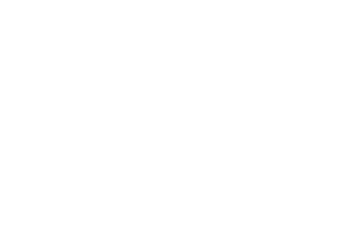

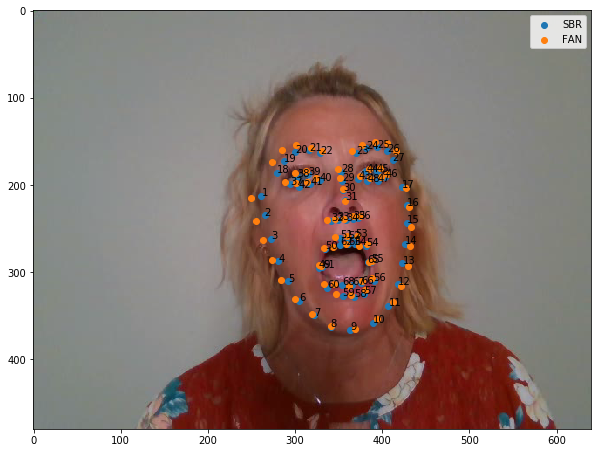

In [21]:
video_name = '/media/deniz/easystore/facial_tracking_data_2021/ALS/AF18_SBK_20190826/02/RSSDK/AF18_02_20190826_NSM_OPEN_color.avi'
cap = cv2.VideoCapture(video_name)
frame_number = 540

amount_of_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
#cap.set(cv2.CAP_PROP_FRAME_COUNT, frame_number-1)
cap.set(1, 300)
ret, frame = cap.read()
print(amount_of_frames)
print(cap)
print(frame.shape)
window_name = 'image'
#gray = cv2.cvtColor(frame, cv2.COLOR_RGBA2RGB)
#cv2.imshow(window_name, frame)
plt.axis("off")
#cv2.waitKey(0)
#cv2.destroyAllWindows()
#plt.imshow(frame)

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.scatter(x.iloc[300][1:],y.iloc[300][1:], label='SBR')
plt.scatter(x_fan.iloc[300][1:],y_fan.iloc[300][1:], label='FAN')
for i in range(len(x.iloc[300].values)):
    if i == 0:
        continue 
    plt.text(x.iloc[300].values[i], y.iloc[300].values[i], str(i))

plt.legend()

# Comparing FIne Tuned Fan and SBR 3D metric values of landmarks

In [43]:
finetuned_fan_pixel_path = r'/media/deniz/easystore/facial_tracking_data_2021/ALS/AF18_SBK_20190826/02/LANDMARKS/Diego_FaceData/landmarks_finetuned_w15/AF18_02_NSM_OPEN_landmarksFiltered3D.csv'
df_fan = pd.read_csv(finetuned_fan_pixel_path, index_col=0)



sbr_path = r'/media/deniz/easystore/facial_tracking_data_2021/ALS/AF18_SBK_20190826/02/LANDMARKS/Deniz_SBR/AF18_02_20190826_NSM_OPEN_color_SBR_3D_landmarks3D.csv'
df_sbr = pd.read_csv(sbr_path, index_col=0)



In [47]:
df_fan.head()

,Video_Frame_number,Time_Stamp (s),landmark_0,landmark_0.1,landmark_0.2,landmark_1,landmark_1.1,landmark_1.2,landmark_2,landmark_2.1,...,landmark_64.2,landmark_65,landmark_65.1,landmark_65.2,landmark_66,landmark_66.1,landmark_66.2,landmark_67,landmark_67.1,landmark_67.2
NaN,NaN,NaN,x,y,z,x,y,z,x,y,...,z,x,y,z,x,y,z,x,y,z
0.0,0.0,0.000000,-0.07900119184788792,-0.022928319835558264,0.636806967886514,-0.07465074095975358,-0.0013958296456191642,0.634682194882771,-0.05827559817463226,0.01695013900531364,...,0.5101954941928852,0.03819961123493017,0.03551226923941896,0.5055709882435622,0.03072975680806653,0.03615550966259582,0.5031962419452611,0.023421865981740588,0.03612856815017958,0.5028212820034241
1.0,1.0,0.033399,-0.07679010620692442,-0.022152525183323755,0.6440561934286961,-0.06217437198776595,-0.0012479453704432857,0.567439378646668,-0.055595814123016236,0.01696513581044995,...,0.5109454140765592,0.03816183658846794,0.035477152038687766,0.5050710416544462,0.030706858330564246,0.036938011664961745,0.5028212820034241,0.023421865981740588,0.036938011664961745,0.5028212820034241
2.0,2.0,0.066799,-0.07585620782834353,-0.022182617882000887,0.6449310999596491,-0.062475657490790364,-0.0003361002357724784,0.5701890848868061,-0.05620809676996262,0.022116533167833897,...,0.5104454674874432,0.0390134813167097,0.03714000924304506,0.5055709882435622,0.03076028811140291,0.03781313556409843,0.5036961885343771,0.023503373842477443,0.039503336688783856,0.5045710950653302
3.0,3.0,0.100198,-0.05638214165978376,-0.013264638784393122,0.5735637243633391,-0.051322536810267806,0.008664494592003986,0.5586903133371379,-0.05189961348332196,0.029961496600307492,...,0.5118203206075123,0.04027042452900396,0.04331365536612158,0.5111953873711172,0.031821829087460694,0.04465171250223247,0.5076957612473052,0.023602347673372197,0.04537945299006317,0.5066958680690732


In [51]:
df_fan = df_fan.drop(df_fan.index[0])

In [52]:
df_fan.head()

,Video_Frame_number,Time_Stamp (s),landmark_0,landmark_0.1,landmark_0.2,landmark_1,landmark_1.1,landmark_1.2,landmark_2,landmark_2.1,...,landmark_64.2,landmark_65,landmark_65.1,landmark_65.2,landmark_66,landmark_66.1,landmark_66.2,landmark_67,landmark_67.1,landmark_67.2
0.0,0.0,0.000000,-0.07900119184788792,-0.022928319835558264,0.636806967886514,-0.07465074095975358,-0.0013958296456191642,0.634682194882771,-0.05827559817463226,0.01695013900531364,...,0.5101954941928852,0.03819961123493017,0.03551226923941896,0.5055709882435622,0.03072975680806653,0.03615550966259582,0.5031962419452611,0.023421865981740588,0.03612856815017958,0.5028212820034241
1.0,1.0,0.033399,-0.07679010620692442,-0.022152525183323755,0.6440561934286961,-0.06217437198776595,-0.0012479453704432857,0.567439378646668,-0.055595814123016236,0.01696513581044995,...,0.5109454140765592,0.03816183658846794,0.035477152038687766,0.5050710416544462,0.030706858330564246,0.036938011664961745,0.5028212820034241,0.023421865981740588,0.036938011664961745,0.5028212820034241
2.0,2.0,0.066799,-0.07585620782834353,-0.022182617882000887,0.6449310999596491,-0.062475657490790364,-0.0003361002357724784,0.5701890848868061,-0.05620809676996262,0.022116533167833897,...,0.5104454674874432,0.0390134813167097,0.03714000924304506,0.5055709882435622,0.03076028811140291,0.03781313556409843,0.5036961885343771,0.023503373842477443,0.039503336688783856,0.5045710950653302
3.0,3.0,0.100198,-0.05638214165978376,-0.013264638784393122,0.5735637243633391,-0.051322536810267806,0.008664494592003986,0.5586903133371379,-0.05189961348332196,0.029961496600307492,...,0.5118203206075123,0.04027042452900396,0.04331365536612158,0.5111953873711172,0.031821829087460694,0.04465171250223247,0.5076957612473052,0.023602347673372197,0.04537945299006317,0.5066958680690732
4.0,4.0,0.133597,-0.055202650354632475,-0.01298714797521863,0.561565006224555,-0.0517703173327735,0.00874009085354496,0.563564792581019,-0.052027734314796945,0.030035460385373053,...,0.5123202671966283,0.040339347015972915,0.043387786316625945,0.5120702939020703,0.031923671474988265,0.04479461557030953,0.5093205876619322,0.02443609817301825,0.04541303423302572,0.5070708280109102


Lets look at the mouth opening for the open task and compare the signal generated by FineTuned FAN to SBR


In [58]:
df_fan =df_fan.astype({ "landmark_51": np.double, "landmark_51.1": np.double,"landmark_51.2": np.double, 
                       "landmark_57": np.double,"landmark_57.1": np.double, "landmark_57.2": np.double })
    

In [69]:
a = np.linalg.norm(df_fan[["landmark_51","landmark_51.1","landmark_51.2"]].to_numpy() - df_fan[["landmark_57","landmark_57.1","landmark_57.2"]].to_numpy(),axis=1)
print(len(a))

541


In [71]:
b = np.linalg.norm(df_sbr[["landmark_51_x","landmark_51_y","landmark_51_z"]].to_numpy() - df_sbr[["landmark_57_x","landmark_57_y","landmark_57_z"]].to_numpy(),axis=1)
print(len(b))

541


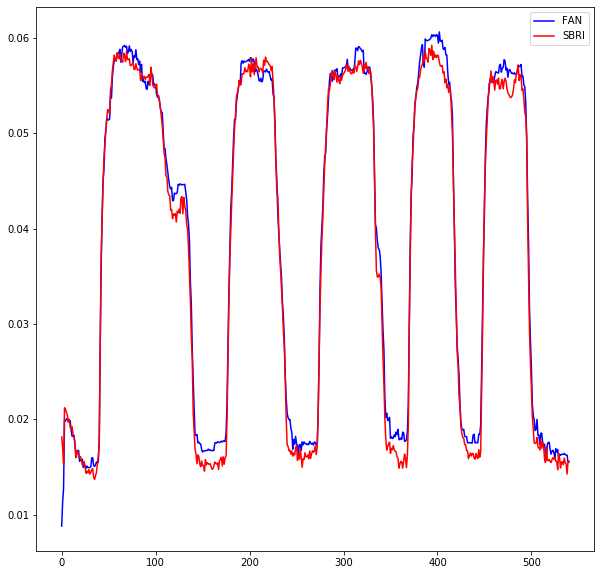

In [73]:
plt.figure(figsize=(10,10))
plt.plot(a,'b', label='FAN')
plt.plot(b,'r',label='SBR')
plt.legend(loc="upper right")

# Generating SBR 3D metric values of landmarks for all tasks that are .bag

In [10]:
# first create a look up table for each population that has the following info 
# .bag file, info_file, 2d_pixel_csv

population = ['ALS', 'PLS', 'Kennedys', 'Post-stroke', 'Healthy_Control']

tasks = ['BBP_NORMAL', 'NSM_OPEN', 'NSM_SPREAD', 'NSM_BIGSMILE' , 'RST_REST', 'NSM_KISS', 'NSM_PUCKER', 'DDK_PA']


df_cols = ['BAG_Files', 'srb_pixel_file', 'cvs_frame_info_Files', 'output_Files']
lookup_df = pd.DataFrame(columns=df_cols)




In [11]:
# Paths 
base_path = '/media/deniz/easystore/facial_tracking_data_2021'

sub_folders_1 = '/02/RSSDK'
sub_folders_2 = '/02/LANDMARKS/Deniz_SBR'


# Batch processing .bag files

In [4]:
#### Batch processing .bag files


#creating the lookup table 
# getting all the bag files, csv info files, and corresponding csv files

master_bag = []
master_pixels = []
master_csvinfo = []
master_output = []
for p in population:
    data_dir = os.path.join(base_path, p) 
    print('working on pop: ', p)
    
    if os.path.isdir(data_dir):
        for dirs in os.listdir(data_dir):
            raw_dir = os.path.join(data_dir, dirs) + sub_folders_1
            sbr_dir = os.path.join(data_dir, dirs) + sub_folders_2
            if os.path.exists(raw_dir):
                rawdata_list = os.listdir(raw_dir)
                
                present = [os.path.join(raw_dir, i) for i in rawdata_list if any(j in i for j in tasks) and i.endswith('.bag')]
                for b in present: 
                    name = b[:-4]
                    csvinfo = os.path.join(raw_dir, name + '_frameInfoColor.csv')
                    master_csvinfo.append(csvinfo)
                    name_2 =  os.path.basename(name)
                    pixels = os.path.join(sbr_dir, name_2 + '_color_SBR_3D_landmarks.csv')
                    master_pixels.append(pixels)
                master_bag=master_bag+ present
                master_output=master_output+ [sbr_dir] * len(present)

print(len(master_bag),len(master_pixels),len(master_csvinfo),len(master_output))

working on pop:  ALS
working on pop:  PLS
working on pop:  Kennedys
working on pop:  Post-stroke
working on pop:  Healthy_Control
820 820 820 820


In [5]:
# creating a bag look up dataframe with all the corresponding files stored in a row

lookup_df['BAG_Files'] = master_bag
lookup_df['srb_pixel_file'] = master_pixels
lookup_df['cvs_frame_info_Files'] = master_csvinfo
lookup_df['output_Files'] = master_output

look_path = os.path.join(base_path, 'bag_sbr_lookups.csv')
lookup_df.to_csv(look_path)
lookup_df.head()

,BAG_Files,srb_pixel_file,cvs_frame_info_Files,output_Files
0,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...
1,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...
2,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...
3,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...
4,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...


In [6]:
lookup_df['BAG_Files'][0]

'/media/deniz/easystore/facial_tracking_data_2021/ALS/AF12_SBK_20180731/02/RSSDK/AF12_02_20180731_NSM_KISS.bag'

In [7]:
lookup_df['srb_pixel_file'][0]

'/media/deniz/easystore/facial_tracking_data_2021/ALS/AF12_SBK_20180731/02/LANDMARKS/Deniz_SBR/AF12_02_20180731_NSM_KISS_color_SBR_3D_landmarks.csv'

In [8]:
lookup_df['cvs_frame_info_Files'][0]

'/media/deniz/easystore/facial_tracking_data_2021/ALS/AF12_SBK_20180731/02/RSSDK/AF12_02_20180731_NSM_KISS_frameInfoColor.csv'

In [2]:
base_path = '/media/deniz/easystore/facial_tracking_data_2021'
look_path = os.path.join(base_path, 'bag_sbr_lookups.csv')
lookup_df = pd.read_csv(look_path)

In [3]:
a = lookup_df['BAG_Files'][115]
b = lookup_df['srb_pixel_file'][115]
c = lookup_df['cvs_frame_info_Files'][115]
d = lookup_df['output_Files'][115]

In [5]:
e, f = get_color_video(a)       

In [7]:
f_df =  pd.read_csv(f)
print(len(f_df))

1387


In [4]:
b_df = pd.read_csv(b)
c_df = pd.read_csv(c)
print(len(b_df), len(c_df))

1680 1387


In [20]:
c_df.head(-5)

,Unnamed: 0,BAG_Frame_Number,Frame_Time_Stamp,Frame_Number_in_Video
0,0,8,0.000000,0
1,1,9,0.020630,1
2,2,10,0.041259,2
3,3,11,0.061889,3
4,4,12,0.082518,4
...,...,...,...,...
1377,1377,1438,29.500990,1377
1378,1378,1439,29.521620,1378
1379,1379,1440,29.542251,1379
1380,1380,1442,29.583511,1380


In [17]:
c

'/media/deniz/easystore/facial_tracking_data_2021/Kennedys/K001_SBK_20180420/02/RSSDK/K001_02_20180420_DDK_PA_frameInfoColor.csv'

In [6]:
lookup_df['BAG_Files'][212]

'/media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP02_SBK_20190412/02/RSSDK/OP02_02_20190412_RST_REST.bag'

In [7]:
lookup_df = lookup_df.loc[213:]

In [ ]:
a = '/media/deniz/easystore/facial_tracking_data_2021/Kennedys/K001_SBK_20180420/02/RSSDK/K001_02_20180420_DDK_PA.bag'

In [8]:
TIMEOUT = 500

for index, row in lookup_df.iterrows():
    
    bag_path = row['BAG_Files']
    print("Starting: ", bag_path)
    info_path = row['cvs_frame_info_Files']
    pixel_path = row['srb_pixel_file']
    q = Process(target=get3dlandmarks, args=(bag_path, info_path, pixel_path,))

    q.start()
    q.join(TIMEOUT)
    if q.is_alive():
        
        q.terminate()
        q.join()

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP02_SBK_20190412/02/RSSDK/OP02_02_20190412_RST_REST2.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP02_SBK_20190412/02/RSSDK/OP02_02_20190412_RST_REST3.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP02_SBK_20190412/02/RSSDK/OP02_02_20190412_DDK_PA.bag


Process Process-75:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 96, in get3dlandmarks
    vid_frame = DF_info.Frame_Number_in_Video.loc[DF_info["BAG_Frame_Number"]==this_frame].values[0]
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/core/generic.py", line 5179, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'Frame_Number_in_Video'


Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP02_SBK_20190412/02/RSSDK/OP02_02_20190412_DDK_PATAKA.bag


Process Process-76:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP02_SBK_20190412/02/RSSDK/OP02_02_20190412_NSM_BIGSMILE.bag
Error file:OP02_02_20190412_NSM_BIGSMILE.bag
7 does not exists in color video
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP02_SBK_20190517/02/RSSDK/OP02_02_20190517_BBP_NORMAL.bag


Process Process-78:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 96, in get3dlandmarks
    vid_frame = DF_info.Frame_Number_in_Video.loc[DF_info["BAG_Frame_Number"]==this_frame].values[0]
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/core/generic.py", line 5179, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'Frame_Number_in_Video'


Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP02_SBK_20190517/02/RSSDK/OP02_02_20190517_DDK_PA.bag
Error file:OP02_02_20190517_DDK_PA.bag
975 does not exists in color video
Error file:OP02_02_20190517_DDK_PA.bag
976 does not exists in color video
Error file:OP02_02_20190517_DDK_PA.bag
976 does not exists in color video
Error file:OP02_02_20190517_DDK_PA.bag
977 does not exists in color video
Error file:OP02_02_20190517_DDK_PA.bag
978 does not exists in color video
Error file:OP02_02_20190517_DDK_PA.bag
979 does not exists in color video
Error file:OP02_02_20190517_DDK_PA.bag
980 does not exists in color video
Error file:OP02_02_20190517_DDK_PA.bag
981 does not exists in color video
Error file:OP02_02_20190517_DDK_PA.bag
981 does not exists in color video
Error file:OP02_02_20190517_DDK_PA.bag
982 does not exists in color video
Error file:OP02_02_20190517_DDK_PA.bag
983 does not exists in color video
Error file:OP02_02_20190517_DDK_PA.bag
984 does not exists 

1064 does not exists in color video
Error file:OP02_02_20190517_DDK_PA.bag
1065 does not exists in color video
Error file:OP02_02_20190517_DDK_PA.bag
1066 does not exists in color video
Error file:OP02_02_20190517_DDK_PA.bag
1067 does not exists in color video
Error file:OP02_02_20190517_DDK_PA.bag
1068 does not exists in color video
Error file:OP02_02_20190517_DDK_PA.bag
1069 does not exists in color video
Error file:OP02_02_20190517_DDK_PA.bag
1070 does not exists in color video
Error file:OP02_02_20190517_DDK_PA.bag
1071 does not exists in color video
Error file:OP02_02_20190517_DDK_PA.bag
1072 does not exists in color video
Error file:OP02_02_20190517_DDK_PA.bag
1073 does not exists in color video
Error file:OP02_02_20190517_DDK_PA.bag
1073 does not exists in color video
Error file:OP02_02_20190517_DDK_PA.bag
1074 does not exists in color video
Error file:OP02_02_20190517_DDK_PA.bag
1075 does not exists in color video
Error file:OP02_02_20190517_DDK_PA.bag
1076 does not exists in c

328 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
329 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
330 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
331 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
331 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
332 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
333 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
334 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
335 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
335 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
336 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
337 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
338 does not exists in color video
Error file:OP02_02_20190517_D

414 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
415 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
416 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
417 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
418 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
419 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
419 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
420 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
421 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
422 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
423 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
423 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
424 does not exists in color video
Error file:OP02_02_20190517_D

501 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
502 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
502 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
503 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
504 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
505 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
506 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
506 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
507 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
508 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
509 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
510 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
511 does not exists in color video
Error file:OP02_02_20190517_D

587 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
588 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
589 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
590 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
590 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
591 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
592 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
593 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
594 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
594 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
595 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
596 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
597 does not exists in color video
Error file:OP02_02_20190517_D

674 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
675 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
676 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
677 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
678 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
678 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
679 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
680 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
681 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
682 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
683 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
684 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
685 does not exists in color video
Error file:OP02_02_20190517_D

765 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
765 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
766 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
767 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
768 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
769 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
770 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
770 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
771 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
772 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
773 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
774 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
775 does not exists in color video
Error file:OP02_02_20190517_D

851 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
852 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
853 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
853 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
854 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
855 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
856 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
857 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
857 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
858 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
859 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
860 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
861 does not exists in color video
Error file:OP02_02_20190517_D

938 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
939 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
940 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
941 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
941 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
942 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
943 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
944 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
945 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
945 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
946 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
947 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
948 does not exists in color video
Error file:OP02_02_20190517_D

1025 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1026 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1027 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1028 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1029 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1029 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1030 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1031 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1032 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1033 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1033 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1034 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1035 does not exists in color video
Error file:OP02_

1112 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1113 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1114 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1115 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1116 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1116 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1117 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1118 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1119 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1120 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1121 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1121 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1122 does not exists in color video
Error file:OP02_

1199 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1200 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1200 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1201 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1202 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1203 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1204 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1204 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1205 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1206 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1207 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1208 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1209 does not exists in color video
Error file:OP02_

1285 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1286 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1287 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1288 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1288 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1289 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1290 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1291 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1292 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1292 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1293 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1294 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1295 does not exists in color video
Error file:OP02_

1371 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1371 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1372 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1373 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1374 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1375 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1375 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1376 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1377 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1378 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1379 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1380 does not exists in color video
Error file:OP02_02_20190517_DDK_PATAKA.bag
1380 does not exists in color video
Error file:OP02_

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP03_SBK_20190315/02/RSSDK/OP03_02_20190315_BBP_NORMAL.bag
Error file:OP03_02_20190315_BBP_NORMAL.bag
1578 does not exists in color video
Error file:OP03_02_20190315_BBP_NORMAL.bag
1579 does not exists in color video
Error file:OP03_02_20190315_BBP_NORMAL.bag
1579 does not exists in color video
Error file:OP03_02_20190315_BBP_NORMAL.bag
1580 does not exists in color video
Error file:OP03_02_20190315_BBP_NORMAL.bag
1580 does not exists in color video
Error file:OP03_02_20190315_BBP_NORMAL.bag
1582 does not exists in color video
Error file:OP03_02_20190315_BBP_NORMAL.bag
1582 does not exists in color video
Error file:OP03_02_20190315_BBP_NORMAL.bag
1583 does not exists in color video
Error file:OP03_02_20190315_BBP_NORMAL.bag
1584 does not exists in color video
Error file:OP03_02_20190315_BBP_NORMAL.bag
1585 does not exists in color video
Error file:OP03_02_20190315_BBP_NORMAL.bag
1585 does not exists in color video


Process Process-89:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 96, in get3dlandmarks
    vid_frame = DF_info.Frame_Number_in_Video.loc[DF_info["BAG_Frame_Number"]==this_frame].values[0]
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/core/generic.py", line 5179, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'Frame_Number_in_Video'


Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP03_SBK_20190315/02/RSSDK/OP03_02_20190315_DDK_PATAKA.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP03_SBK_20190315/02/RSSDK/OP03_02_20190315_NSM_KISS.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP03_SBK_20190315/02/RSSDK/OP03_02_20190315_NSM_OPEN.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP03_SBK_20190315/02/RSSDK/OP03_02_20190315_NSM_BIGSMILE.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP03_SBK_20190315/02/RSSDK/OP03_02_20190315_NSM_SPREAD.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP03_SBK_20190315/02/RSSDK/OP03_02_20190315_RST_REST.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP03_SBK_20190315/02/RSSDK/OP03_02_20190315_RST_REST2.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP03_SBK_2019031

1058 does not exists in color video
Error file:OP03_02_20190426_BBP_NORMAL.bag
1059 does not exists in color video
Error file:OP03_02_20190426_BBP_NORMAL.bag
1060 does not exists in color video
Error file:OP03_02_20190426_BBP_NORMAL.bag
1061 does not exists in color video
Error file:OP03_02_20190426_BBP_NORMAL.bag
1061 does not exists in color video
Error file:OP03_02_20190426_BBP_NORMAL.bag
1063 does not exists in color video
Error file:OP03_02_20190426_BBP_NORMAL.bag
1064 does not exists in color video
Error file:OP03_02_20190426_BBP_NORMAL.bag
1065 does not exists in color video
Error file:OP03_02_20190426_BBP_NORMAL.bag
1066 does not exists in color video
Error file:OP03_02_20190426_BBP_NORMAL.bag
1068 does not exists in color video
Error file:OP03_02_20190426_BBP_NORMAL.bag
1068 does not exists in color video
Error file:OP03_02_20190426_BBP_NORMAL.bag
1068 does not exists in color video
Error file:OP03_02_20190426_BBP_NORMAL.bag
1070 does not exists in color video
Error file:OP03_

1156 does not exists in color video
Error file:OP03_02_20190426_BBP_NORMAL.bag
1156 does not exists in color video
Error file:OP03_02_20190426_BBP_NORMAL.bag
1157 does not exists in color video
Error file:OP03_02_20190426_BBP_NORMAL.bag
1158 does not exists in color video
Error file:OP03_02_20190426_BBP_NORMAL.bag
1159 does not exists in color video
Error file:OP03_02_20190426_BBP_NORMAL.bag
1160 does not exists in color video
Error file:OP03_02_20190426_BBP_NORMAL.bag
1160 does not exists in color video
Error file:OP03_02_20190426_BBP_NORMAL.bag
1161 does not exists in color video
Error file:OP03_02_20190426_BBP_NORMAL.bag
1162 does not exists in color video
Error file:OP03_02_20190426_BBP_NORMAL.bag
1163 does not exists in color video
Error file:OP03_02_20190426_BBP_NORMAL.bag
1164 does not exists in color video
Error file:OP03_02_20190426_BBP_NORMAL.bag
1164 does not exists in color video
Error file:OP03_02_20190426_BBP_NORMAL.bag
1166 does not exists in color video
Error file:OP03_

1251 does not exists in color video
Error file:OP03_02_20190426_BBP_NORMAL.bag
1252 does not exists in color video
Error file:OP03_02_20190426_BBP_NORMAL.bag
1252 does not exists in color video
Error file:OP03_02_20190426_BBP_NORMAL.bag
1253 does not exists in color video
Error file:OP03_02_20190426_BBP_NORMAL.bag
1254 does not exists in color video
Error file:OP03_02_20190426_BBP_NORMAL.bag
1255 does not exists in color video
Error file:OP03_02_20190426_BBP_NORMAL.bag
1256 does not exists in color video
Error file:OP03_02_20190426_BBP_NORMAL.bag
1256 does not exists in color video
Error file:OP03_02_20190426_BBP_NORMAL.bag
1256 does not exists in color video
Error file:OP03_02_20190426_BBP_NORMAL.bag
1258 does not exists in color video
Error file:OP03_02_20190426_BBP_NORMAL.bag
1259 does not exists in color video
Error file:OP03_02_20190426_BBP_NORMAL.bag
1260 does not exists in color video
Error file:OP03_02_20190426_BBP_NORMAL.bag
1261 does not exists in color video
Error file:OP03_

Process Process-99:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP03_SBK_20190426/02/RSSDK/OP03_02_20190426_DDK_PATAKA.bag


Process Process-100:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP03_SBK_20190426/02/RSSDK/OP03_02_20190426_NSM_BIGSMILE.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP03_SBK_20190426/02/RSSDK/OP03_02_20190426_NSM_KISS.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP03_SBK_20190426/02/RSSDK/OP03_02_20190426_NSM_OPEN.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP03_SBK_20190426/02/RSSDK/OP03_02_20190426_NSM_SPREAD.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP03_SBK_20190426/02/RSSDK/OP03_02_20190426_RST_REST.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP03_SBK_20190426/02/RSSDK/OP03_02_20190426_RST_REST2.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP03_SBK_20190426/02/RSSDK/OP03_02_20190426_RST_REST3.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP03_SBK_20190524

Process Process-108:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 96, in get3dlandmarks
    vid_frame = DF_info.Frame_Number_in_Video.loc[DF_info["BAG_Frame_Number"]==this_frame].values[0]
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/core/generic.py", line 5179, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'Frame_Number_in_Video'


Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP03_SBK_20190524/02/RSSDK/OP03_02_20190524_DDK_PA.bag


Process Process-109:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 96, in get3dlandmarks
    vid_frame = DF_info.Frame_Number_in_Video.loc[DF_info["BAG_Frame_Number"]==this_frame].values[0]
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/core/generic.py", line 5179, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'Frame_Number_in_Video'


Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP03_SBK_20190524/02/RSSDK/OP03_02_20190524_DDK_PATAKA.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP03_SBK_20190524/02/RSSDK/OP03_02_20190524_NSM_PUCKER.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP03_SBK_20190524/02/RSSDK/OP03_02_20190524_NSM_BIGSMILE.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP03_SBK_20190524/02/RSSDK/OP03_02_20190524_NSM_OPEN.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP03_SBK_20190524/02/RSSDK/OP03_02_20190524_NSM_SPREAD.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP03_SBK_20190524/02/RSSDK/OP03_02_20190524_RST_REST.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP03_SBK_20190524/02/RSSDK/OP03_02_20190524_RST_REST2.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP03_SBK_20190

589 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
590 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
591 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
592 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
593 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
594 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
594 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
595 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
596 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
597 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
598 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
598 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
599 does not exists in color video
Error file:OP04_02_20190523_D

679 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
680 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
681 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
682 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
682 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
683 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
684 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
685 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
686 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
687 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
688 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
689 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
690 does not exists in color video
Error file:OP04_02_20190523_D

766 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
767 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
768 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
769 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
770 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
770 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
771 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
772 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
773 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
774 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
775 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
776 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
777 does not exists in color video
Error file:OP04_02_20190523_D

856 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
857 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
857 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
858 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
859 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
860 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
861 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
862 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
862 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
863 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
864 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
865 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
866 does not exists in color video
Error file:OP04_02_20190523_D

945 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
945 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
946 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
947 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
948 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
949 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
950 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
950 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
951 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
952 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
953 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
954 does not exists in color video
Error file:OP04_02_20190523_DDK_PATAKA.bag
954 does not exists in color video
Error file:OP04_02_20190523_D

Process Process-130:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 96, in get3dlandmarks
    vid_frame = DF_info.Frame_Number_in_Video.loc[DF_info["BAG_Frame_Number"]==this_frame].values[0]
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/core/generic.py", line 5179, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'Frame_Number_in_Video'


Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP05_SBK_20190830/02/RSSDK/OP05_02_20190830_DDK_PA.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP05_SBK_20190830/02/RSSDK/OP05_02_20190830_DDK_PATAKA.bag
Error file:OP05_02_20190830_DDK_PATAKA.bag
576 does not exists in color video
Error file:OP05_02_20190830_DDK_PATAKA.bag
577 does not exists in color video
Error file:OP05_02_20190830_DDK_PATAKA.bag
577 does not exists in color video
Error file:OP05_02_20190830_DDK_PATAKA.bag
578 does not exists in color video
Error file:OP05_02_20190830_DDK_PATAKA.bag
579 does not exists in color video
Error file:OP05_02_20190830_DDK_PATAKA.bag
580 does not exists in color video
Error file:OP05_02_20190830_DDK_PATAKA.bag
581 does not exists in color video
Error file:OP05_02_20190830_DDK_PATAKA.bag
581 does not exists in color video
Error file:OP05_02_20190830_DDK_PATAKA.bag
582 does not exists in color video
Error file:OP05_02_20190830_DDK_PATAKA.b

659 does not exists in color video
Error file:OP05_02_20190830_DDK_PATAKA.bag
660 does not exists in color video
Error file:OP05_02_20190830_DDK_PATAKA.bag
660 does not exists in color video
Error file:OP05_02_20190830_DDK_PATAKA.bag
661 does not exists in color video
Error file:OP05_02_20190830_DDK_PATAKA.bag
662 does not exists in color video
Error file:OP05_02_20190830_DDK_PATAKA.bag
663 does not exists in color video
Error file:OP05_02_20190830_DDK_PATAKA.bag
664 does not exists in color video
Error file:OP05_02_20190830_DDK_PATAKA.bag
665 does not exists in color video
Error file:OP05_02_20190830_DDK_PATAKA.bag
666 does not exists in color video
Error file:OP05_02_20190830_DDK_PATAKA.bag
667 does not exists in color video
Error file:OP05_02_20190830_DDK_PATAKA.bag
668 does not exists in color video
Error file:OP05_02_20190830_DDK_PATAKA.bag
669 does not exists in color video
Error file:OP05_02_20190830_DDK_PATAKA.bag
669 does not exists in color video
Error file:OP05_02_20190830_D

747 does not exists in color video
Error file:OP05_02_20190830_DDK_PATAKA.bag
748 does not exists in color video
Error file:OP05_02_20190830_DDK_PATAKA.bag
748 does not exists in color video
Error file:OP05_02_20190830_DDK_PATAKA.bag
749 does not exists in color video
Error file:OP05_02_20190830_DDK_PATAKA.bag
750 does not exists in color video
Error file:OP05_02_20190830_DDK_PATAKA.bag
751 does not exists in color video
Error file:OP05_02_20190830_DDK_PATAKA.bag
752 does not exists in color video
Error file:OP05_02_20190830_DDK_PATAKA.bag
753 does not exists in color video
Error file:OP05_02_20190830_DDK_PATAKA.bag
754 does not exists in color video
Error file:OP05_02_20190830_DDK_PATAKA.bag
755 does not exists in color video
Error file:OP05_02_20190830_DDK_PATAKA.bag
756 does not exists in color video
Error file:OP05_02_20190830_DDK_PATAKA.bag
757 does not exists in color video
Error file:OP05_02_20190830_DDK_PATAKA.bag
757 does not exists in color video
Error file:OP05_02_20190830_D

835 does not exists in color video
Error file:OP05_02_20190830_DDK_PATAKA.bag
836 does not exists in color video
Error file:OP05_02_20190830_DDK_PATAKA.bag
836 does not exists in color video
Error file:OP05_02_20190830_DDK_PATAKA.bag
837 does not exists in color video
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP05_SBK_20190830/02/RSSDK/OP05_02_20190830_NSM_BIGSMILE.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP05_SBK_20190830/02/RSSDK/OP05_02_20190830_NSM_OPEN.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP05_SBK_20190830/02/RSSDK/OP05_02_20190830_NSM_PUCKER.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP05_SBK_20190830/02/RSSDK/OP05_02_20190830_NSM_SPREAD.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP05_SBK_20190830/02/RSSDK/OP05_02_20190830_RST_REST.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP05_S

779 does not exists in color video
Error file:OP05_02_20190926_BBP_NORMAL.bag
780 does not exists in color video
Error file:OP05_02_20190926_BBP_NORMAL.bag
780 does not exists in color video
Error file:OP05_02_20190926_BBP_NORMAL.bag
782 does not exists in color video
Error file:OP05_02_20190926_BBP_NORMAL.bag
783 does not exists in color video
Error file:OP05_02_20190926_BBP_NORMAL.bag
785 does not exists in color video
Error file:OP05_02_20190926_BBP_NORMAL.bag
786 does not exists in color video
Error file:OP05_02_20190926_BBP_NORMAL.bag
787 does not exists in color video
Error file:OP05_02_20190926_BBP_NORMAL.bag
787 does not exists in color video
Error file:OP05_02_20190926_BBP_NORMAL.bag
787 does not exists in color video
Error file:OP05_02_20190926_BBP_NORMAL.bag
790 does not exists in color video
Error file:OP05_02_20190926_BBP_NORMAL.bag
791 does not exists in color video
Error file:OP05_02_20190926_BBP_NORMAL.bag
791 does not exists in color video
Error file:OP05_02_20190926_B

934 does not exists in color video
Error file:OP05_02_20190926_BBP_NORMAL.bag
935 does not exists in color video
Error file:OP05_02_20190926_BBP_NORMAL.bag
936 does not exists in color video
Error file:OP05_02_20190926_BBP_NORMAL.bag
936 does not exists in color video
Error file:OP05_02_20190926_BBP_NORMAL.bag
936 does not exists in color video
Error file:OP05_02_20190926_BBP_NORMAL.bag
966 does not exists in color video
Error file:OP05_02_20190926_BBP_NORMAL.bag
967 does not exists in color video
Error file:OP05_02_20190926_BBP_NORMAL.bag
968 does not exists in color video
Error file:OP05_02_20190926_BBP_NORMAL.bag
969 does not exists in color video
Error file:OP05_02_20190926_BBP_NORMAL.bag
970 does not exists in color video
Error file:OP05_02_20190926_BBP_NORMAL.bag
970 does not exists in color video
Error file:OP05_02_20190926_BBP_NORMAL.bag
970 does not exists in color video
Error file:OP05_02_20190926_BBP_NORMAL.bag
972 does not exists in color video
Error file:OP05_02_20190926_B

1118 does not exists in color video
Error file:OP05_02_20190926_BBP_NORMAL.bag
1119 does not exists in color video
Error file:OP05_02_20190926_BBP_NORMAL.bag
1120 does not exists in color video
Error file:OP05_02_20190926_BBP_NORMAL.bag
1121 does not exists in color video
Error file:OP05_02_20190926_BBP_NORMAL.bag
1121 does not exists in color video
Error file:OP05_02_20190926_BBP_NORMAL.bag
1123 does not exists in color video
Error file:OP05_02_20190926_BBP_NORMAL.bag
1124 does not exists in color video
Error file:OP05_02_20190926_BBP_NORMAL.bag
1125 does not exists in color video
Error file:OP05_02_20190926_BBP_NORMAL.bag
1126 does not exists in color video
Error file:OP05_02_20190926_BBP_NORMAL.bag
1127 does not exists in color video
Error file:OP05_02_20190926_BBP_NORMAL.bag
1128 does not exists in color video
Error file:OP05_02_20190926_BBP_NORMAL.bag
1129 does not exists in color video
Error file:OP05_02_20190926_BBP_NORMAL.bag
1129 does not exists in color video
Error file:OP05_

1260 does not exists in color video
Error file:OP05_02_20190926_BBP_NORMAL.bag
1261 does not exists in color video
Error file:OP05_02_20190926_BBP_NORMAL.bag
1261 does not exists in color video
Error file:OP05_02_20190926_BBP_NORMAL.bag
1262 does not exists in color video
Error file:OP05_02_20190926_BBP_NORMAL.bag
1262 does not exists in color video
Error file:OP05_02_20190926_BBP_NORMAL.bag
1265 does not exists in color video
Error file:OP05_02_20190926_BBP_NORMAL.bag
1266 does not exists in color video
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP05_SBK_20190926/02/RSSDK/OP05_02_20190926_DDK_PA.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP05_SBK_20190926/02/RSSDK/OP05_02_20190926_DDK_PATAKA.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP05_SBK_20190926/02/RSSDK/OP05_02_20190926_NSM_OPEN.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP05_SBK_20190926/02/RSSDK/OP05

191 does not exists in color video
Error file:OP05_02_20190926_RST_REST2.bag
192 does not exists in color video
Error file:OP05_02_20190926_RST_REST2.bag
193 does not exists in color video
Error file:OP05_02_20190926_RST_REST2.bag
194 does not exists in color video
Error file:OP05_02_20190926_RST_REST2.bag
195 does not exists in color video
Error file:OP05_02_20190926_RST_REST2.bag
196 does not exists in color video
Error file:OP05_02_20190926_RST_REST2.bag
197 does not exists in color video
Error file:OP05_02_20190926_RST_REST2.bag
198 does not exists in color video
Error file:OP05_02_20190926_RST_REST2.bag
199 does not exists in color video
Error file:OP05_02_20190926_RST_REST2.bag
200 does not exists in color video
Error file:OP05_02_20190926_RST_REST2.bag
201 does not exists in color video
Error file:OP05_02_20190926_RST_REST2.bag
202 does not exists in color video
Error file:OP05_02_20190926_RST_REST2.bag
203 does not exists in color video
Error file:OP05_02_20190926_RST_REST2.bag

297 does not exists in color video
Error file:OP05_02_20190926_RST_REST2.bag
298 does not exists in color video
Error file:OP05_02_20190926_RST_REST2.bag
299 does not exists in color video
Error file:OP05_02_20190926_RST_REST2.bag
300 does not exists in color video
Error file:OP05_02_20190926_RST_REST2.bag
301 does not exists in color video
Error file:OP05_02_20190926_RST_REST2.bag
302 does not exists in color video
Error file:OP05_02_20190926_RST_REST2.bag
303 does not exists in color video
Error file:OP05_02_20190926_RST_REST2.bag
304 does not exists in color video
Error file:OP05_02_20190926_RST_REST2.bag
305 does not exists in color video
Error file:OP05_02_20190926_RST_REST2.bag
306 does not exists in color video
Error file:OP05_02_20190926_RST_REST2.bag
307 does not exists in color video
Error file:OP05_02_20190926_RST_REST2.bag
308 does not exists in color video
Error file:OP05_02_20190926_RST_REST2.bag
309 does not exists in color video
Error file:OP05_02_20190926_RST_REST2.bag

305 does not exists in color video
Error file:OP05_02_20190926_RST_REST3.bag
306 does not exists in color video
Error file:OP05_02_20190926_RST_REST3.bag
307 does not exists in color video
Error file:OP05_02_20190926_RST_REST3.bag
308 does not exists in color video
Error file:OP05_02_20190926_RST_REST3.bag
309 does not exists in color video
Error file:OP05_02_20190926_RST_REST3.bag
310 does not exists in color video
Error file:OP05_02_20190926_RST_REST3.bag
311 does not exists in color video
Error file:OP05_02_20190926_RST_REST3.bag
312 does not exists in color video
Error file:OP05_02_20190926_RST_REST3.bag
313 does not exists in color video
Error file:OP05_02_20190926_RST_REST3.bag
314 does not exists in color video
Error file:OP05_02_20190926_RST_REST3.bag
315 does not exists in color video
Error file:OP05_02_20190926_RST_REST3.bag
316 does not exists in color video
Error file:OP05_02_20190926_RST_REST3.bag
317 does not exists in color video
Error file:OP05_02_20190926_RST_REST3.bag

Process Process-151:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 96, in get3dlandmarks
    vid_frame = DF_info.Frame_Number_in_Video.loc[DF_info["BAG_Frame_Number"]==this_frame].values[0]
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/core/generic.py", line 5179, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'Frame_Number_in_Video'


Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP06_SBK_20190823/02/RSSDK/OP06_02_20190823_DDK_PATAKA.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP06_SBK_20190823/02/RSSDK/OP06_02_20190823_NSM_BIGSMILE.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP06_SBK_20190823/02/RSSDK/OP06_02_20190823_NSM_PUCKER.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP06_SBK_20190823/02/RSSDK/OP06_02_20190823_NSM_SPREAD.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP06_SBK_20190823/02/RSSDK/OP06_02_20190823_RST_REST.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP06_SBK_20190823/02/RSSDK/OP06_02_20190823_RST_REST2.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP06_SBK_20190823/02/RSSDK/OP06_02_20190823_NSM_OPEN.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP06_SBK_20190

Process Process-181:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 96, in get3dlandmarks
    vid_frame = DF_info.Frame_Number_in_Video.loc[DF_info["BAG_Frame_Number"]==this_frame].values[0]
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/core/generic.py", line 5179, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'Frame_Number_in_Video'


Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP07_SBK_20190906/02/RSSDK/OP07_02_20190906_DDK_PATAKA.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP07_SBK_20190906/02/RSSDK/OP07_02_20190906_NSM_BIGSMILE.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP07_SBK_20190906/02/RSSDK/OP07_02_20190906_NSM_OPEN.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP07_SBK_20190906/02/RSSDK/OP07_02_20190906_NSM_PUCKER.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP07_SBK_20190906/02/RSSDK/OP07_02_20190906_NSM_SPREAD.bag
Error file:OP07_02_20190906_NSM_SPREAD.bag
7 does not exists in color video
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP07_SBK_20190906/02/RSSDK/OP07_02_20190906_RST_REST.bag
Error file:OP07_02_20190906_RST_REST.bag
264 does not exists in color video
Error file:OP07_02_20190906_RST_REST.bag
265 does not exists in 

360 does not exists in color video
Error file:OP07_02_20190906_RST_REST.bag
361 does not exists in color video
Error file:OP07_02_20190906_RST_REST.bag
362 does not exists in color video
Error file:OP07_02_20190906_RST_REST.bag
363 does not exists in color video
Error file:OP07_02_20190906_RST_REST.bag
364 does not exists in color video
Error file:OP07_02_20190906_RST_REST.bag
365 does not exists in color video
Error file:OP07_02_20190906_RST_REST.bag
366 does not exists in color video
Error file:OP07_02_20190906_RST_REST.bag
367 does not exists in color video
Error file:OP07_02_20190906_RST_REST.bag
368 does not exists in color video
Error file:OP07_02_20190906_RST_REST.bag
369 does not exists in color video
Error file:OP07_02_20190906_RST_REST.bag
370 does not exists in color video
Error file:OP07_02_20190906_RST_REST.bag
371 does not exists in color video
Error file:OP07_02_20190906_RST_REST.bag
372 does not exists in color video
Error file:OP07_02_20190906_RST_REST.bag
373 does not

232 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
235 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
235 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
236 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
237 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
238 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
238 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
238 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
240 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
241 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
242 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
243 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
244 does not exists in color video
Error file:OP08_02_20190906_B

330 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
331 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
332 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
333 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
334 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
335 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
336 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
336 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
336 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
339 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
340 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
341 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
342 does not exists in color video
Error file:OP08_02_20190906_B

430 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
432 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
432 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
433 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
433 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
435 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
436 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
437 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
438 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
439 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
440 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
441 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
442 does not exists in color video
Error file:OP08_02_20190906_B

527 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
528 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
528 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
529 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
530 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
530 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
532 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
533 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
533 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
535 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
536 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
537 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
538 does not exists in color video
Error file:OP08_02_20190906_B

627 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
628 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
629 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
629 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
629 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
631 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
632 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
633 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
634 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
634 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
636 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
637 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
638 does not exists in color video
Error file:OP08_02_20190906_B

726 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
727 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
727 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
729 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
730 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
730 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
731 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
732 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
733 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
735 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
735 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
736 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
737 does not exists in color video
Error file:OP08_02_20190906_B

825 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
827 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
828 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
829 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
830 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
831 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
831 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
831 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
834 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
835 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
836 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
837 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
838 does not exists in color video
Error file:OP08_02_20190906_B

927 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
928 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
929 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
929 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
931 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
932 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
933 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
934 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
934 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
936 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
936 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
938 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
939 does not exists in color video
Error file:OP08_02_20190906_B

1029 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
1029 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
1029 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
1031 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
1032 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
1033 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
1034 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
1035 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
1036 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
1037 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
1037 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
1037 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
1039 does not exists in color video
Error file:OP08_

1124 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
1124 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
1126 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
1126 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
1128 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
1129 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
1130 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
1131 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
1131 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
1133 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
1133 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
1135 does not exists in color video
Error file:OP08_02_20190906_BBP_NORMAL.bag
1136 does not exists in color video
Error file:OP08_

Process Process-201:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 96, in get3dlandmarks
    vid_frame = DF_info.Frame_Number_in_Video.loc[DF_info["BAG_Frame_Number"]==this_frame].values[0]
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/core/generic.py", line 5179, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'Frame_Number_in_Video'


Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP08_SBK_20190906/02/RSSDK/OP08_02_20190906_DDK_PATAKA.bag


Process Process-202:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP08_SBK_20190906/02/RSSDK/OP08_02_20190906_NSM_BIGSMILE.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP08_SBK_20190906/02/RSSDK/OP08_02_20190906_NSM_OPEN.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP08_SBK_20190906/02/RSSDK/OP08_02_20190906_NSM_PUCKER.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP08_SBK_20190906/02/RSSDK/OP08_02_20190906_NSM_SPREAD.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP08_SBK_20190906/02/RSSDK/OP08_02_20190906_RST_REST.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP08_SBK_20190906/02/RSSDK/OP08_02_20190906_RST_REST2.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP08_SBK_20190906/02/RSSDK/OP08_02_20190906_RST_REST3.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP08_SBK_201910

Error file:OP09_02_20190912_NSM_OPEN.bag
58 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
59 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
60 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
61 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
62 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
63 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
64 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
65 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
66 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
67 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
68 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
69 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
70 does not exists in color video
Error file:OP09_02_201909

165 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
166 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
167 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
168 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
169 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
170 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
171 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
172 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
173 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
174 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
175 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
176 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
177 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
178 does not

271 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
272 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
273 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
274 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
275 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
276 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
277 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
278 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
279 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
280 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
281 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
282 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
283 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
284 does not

377 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
378 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
378 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
379 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
380 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
380 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
381 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
382 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
383 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
384 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
385 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
386 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
387 does not exists in color video
Error file:OP09_02_20190912_NSM_OPEN.bag
388 does not

Process Process-241:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 96, in get3dlandmarks
    vid_frame = DF_info.Frame_Number_in_Video.loc[DF_info["BAG_Frame_Number"]==this_frame].values[0]
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/core/generic.py", line 5179, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'Frame_Number_in_Video'


Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP09_SBK_20191023/02/RSSDK/OP09_02_20191023_DDK_PATAKA.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP09_SBK_20191023/02/RSSDK/OP09_02_20191023_NSM_OPEN.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP09_SBK_20191023/02/RSSDK/OP09_02_20191023_NSM_PUCKER.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP09_SBK_20191023/02/RSSDK/OP09_02_20191023_NSM_BIGSMILE.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP09_SBK_20191023/02/RSSDK/OP09_02_20191023_NSM_SPREAD.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP09_SBK_20191023/02/RSSDK/OP09_02_20191023_RST_REST.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP09_SBK_20191023/02/RSSDK/OP09_02_20191023_RST_REST2.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP09_SBK_20191

1067 does not exists in color video
Error file:OP10_02_20190913_BBP_NORMAL.bag
1068 does not exists in color video
Error file:OP10_02_20190913_BBP_NORMAL.bag
1069 does not exists in color video
Error file:OP10_02_20190913_BBP_NORMAL.bag
1070 does not exists in color video
Error file:OP10_02_20190913_BBP_NORMAL.bag
1070 does not exists in color video
Error file:OP10_02_20190913_BBP_NORMAL.bag
1070 does not exists in color video
Error file:OP10_02_20190913_BBP_NORMAL.bag
1107 does not exists in color video
Error file:OP10_02_20190913_BBP_NORMAL.bag
1107 does not exists in color video
Error file:OP10_02_20190913_BBP_NORMAL.bag
1109 does not exists in color video
Error file:OP10_02_20190913_BBP_NORMAL.bag
1110 does not exists in color video
Error file:OP10_02_20190913_BBP_NORMAL.bag
1111 does not exists in color video
Error file:OP10_02_20190913_BBP_NORMAL.bag
1111 does not exists in color video
Error file:OP10_02_20190913_BBP_NORMAL.bag
1113 does not exists in color video
Error file:OP10_

682 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
683 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
684 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
684 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
685 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
686 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
687 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
688 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
689 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
690 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
691 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
692 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
693 does not exists in color video
Error file:OP10_02_20190913_D

807 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
837 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
838 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
839 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
840 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
841 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
842 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
843 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
844 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
845 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
846 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
847 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
848 does not exists in color video
Error file:OP10_02_20190913_D

970 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
971 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1002 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1002 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1003 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1004 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1005 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1006 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1007 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1008 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1009 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1010 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1011 does not exists in color video
Error file:OP10_02

1129 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1130 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1131 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1132 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1133 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1134 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1135 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1166 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1167 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1168 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1169 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1170 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1171 does not exists in color video
Error file:OP10_

1290 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1291 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1292 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1293 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1294 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1295 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1296 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1297 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1298 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1298 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1331 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1332 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1333 does not exists in color video
Error file:OP10_

1454 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1455 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1456 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1457 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1458 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1459 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1460 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1461 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1494 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1494 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1495 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1496 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1497 does not exists in color video
Error file:OP10_

1616 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1617 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1618 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1619 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1620 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1621 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1622 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1623 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1624 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1625 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1626 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1658 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1659 does not exists in color video
Error file:OP10_

1777 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1778 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1779 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1780 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1781 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1782 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1783 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1784 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1785 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1786 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1787 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1788 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1788 does not exists in color video
Error file:OP10_

1943 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1944 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1945 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1946 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1947 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1948 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1949 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1950 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1951 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1952 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1952 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1987 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
1987 does not exists in color video
Error file:OP10_

2105 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
2106 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
2107 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
2108 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
2109 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
2110 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
2111 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
2112 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
2113 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
2114 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
2115 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
2116 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
2149 does not exists in color video
Error file:OP10_

2267 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
2268 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
2269 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
2270 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
2271 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
2272 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
2273 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
2274 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
2275 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
2276 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
2277 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
2278 does not exists in color video
Error file:OP10_02_20190913_DDK_PATAKA.bag
2279 does not exists in color video
Error file:OP10_

Error file:OP10_02_20191025_BBP_NORMAL.bag
857 does not exists in color video
Error file:OP10_02_20191025_BBP_NORMAL.bag
858 does not exists in color video
Error file:OP10_02_20191025_BBP_NORMAL.bag
858 does not exists in color video
Error file:OP10_02_20191025_BBP_NORMAL.bag
860 does not exists in color video
Error file:OP10_02_20191025_BBP_NORMAL.bag
861 does not exists in color video
Error file:OP10_02_20191025_BBP_NORMAL.bag
862 does not exists in color video
Error file:OP10_02_20191025_BBP_NORMAL.bag
863 does not exists in color video
Error file:OP10_02_20191025_BBP_NORMAL.bag
864 does not exists in color video
Error file:OP10_02_20191025_BBP_NORMAL.bag
865 does not exists in color video
Error file:OP10_02_20191025_BBP_NORMAL.bag
865 does not exists in color video
Error file:OP10_02_20191025_BBP_NORMAL.bag
865 does not exists in color video
Error file:OP10_02_20191025_BBP_NORMAL.bag
895 does not exists in color video
Error file:OP10_02_20191025_BBP_NORMAL.bag
896 does not exists i

Process Process-271:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 96, in get3dlandmarks
    vid_frame = DF_info.Frame_Number_in_Video.loc[DF_info["BAG_Frame_Number"]==this_frame].values[0]
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/core/generic.py", line 5179, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'Frame_Number_in_Video'


Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP10_SBK_20191025/02/RSSDK/OP10_02_20191025_DDK_PATAKA.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP10_SBK_20191025/02/RSSDK/OP10_02_20191025_NSM_OPEN.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP10_SBK_20191025/02/RSSDK/OP10_02_20191025_NSM_PUCKER.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP10_SBK_20191025/02/RSSDK/OP10_02_20191025_NSM_BIGSMILE.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP10_SBK_20191025/02/RSSDK/OP10_02_20191025_NSM_SPREAD.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP10_SBK_20191025/02/RSSDK/OP10_02_20191025_RST_REST.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP10_SBK_20191025/02/RSSDK/OP10_02_20191025_RST_REST2.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP10_SBK_20191

625 does not exists in color video
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP10_SBK_20191121/02/RSSDK/OP10_02_20191121_DDK_PATAKA.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP10_SBK_20191121/02/RSSDK/OP10_02_20191121_DDK_PA_1.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP10_SBK_20191121/02/RSSDK/OP10_02_20191121_RST_REST.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP10_SBK_20191121/02/RSSDK/OP10_02_20191121_RST_REST2.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP10_SBK_20191121/02/RSSDK/OP10_02_20191121_RST_REST3.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP10_SBK_20191121/02/RSSDK/OP10_02_20191121_NSM_OPEN.bag
Error file:OP10_02_20191121_NSM_OPEN.bag
7 does not exists in color video
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP10_SBK_20191121/02/RSSDK/OP10_02_201911

Process Process-311:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 96, in get3dlandmarks
    vid_frame = DF_info.Frame_Number_in_Video.loc[DF_info["BAG_Frame_Number"]==this_frame].values[0]
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/core/generic.py", line 5179, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'Frame_Number_in_Video'


Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP11_SBK_20200114/02/RSSDK/OP11_02_20200114_DDK_PATAKA.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP11_SBK_20200114/02/RSSDK/OP11_02_20200114_NSM_SPREAD.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP11_SBK_20200114/02/RSSDK/OP11_02_20200114_RST_REST.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP11_SBK_20200114/02/RSSDK/OP11_02_20200114_RST_REST2.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP11_SBK_20200114/02/RSSDK/OP11_02_20200114_DDK_PA_1.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP11_SBK_20200114/02/RSSDK/OP11_02_20200114_RST_REST3.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP11_SBK_20200114/02/RSSDK/OP11_02_20200114_NSM_BIGSMILE.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP11_SBK_202001

Process Process-364:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP13_SBK_20200228/02/RSSDK/OP13_02_20200228_DDK_PATAKA_1119.bag


Process Process-365:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP13_SBK_20200228/02/RSSDK/OP13_02_20200228_NSM_SPREAD_1137.bag


Process Process-366:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP13_SBK_20200228/02/RSSDK/OP13_02_20200228_DDK_PATAKA_1119_1.bag


Process Process-367:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP13_SBK_20200228/02/RSSDK/OP13_02_20200228_NSM_SPREAD_1137_1.bag


Process Process-368:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP13_SBK_20200228/02/RSSDK/OP13_02_20200228_DDK_PA_1115.bag


Process Process-369:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP13_SBK_20200228/02/RSSDK/OP13_02_20200228_NSM_BIGSMILE_1126.bag


Process Process-370:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP13_SBK_20200228/02/RSSDK/OP13_02_20200228_NSM_OPEN_1136.bag


Process Process-371:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP13_SBK_20200228/02/RSSDK/OP13_02_20200228_NSM_PUCKER_1138.bag


Process Process-372:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP14_SBK_20200124/02/RSSDK/OP14_02_20200124_DDK_PATAKA_1315.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP14_SBK_20200124/02/RSSDK/OP14_02_20200124_DDK_PA_1312.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP14_SBK_20200124/02/RSSDK/OP14_02_20200124_NSM_BIGSMILE_1330.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP14_SBK_20200306/02/RSSDK/OP14_02_20200306_BBP_NORMAL_1209.bag


Process Process-376:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP14_SBK_20200306/02/RSSDK/OP14_02_20200306_DDK_PATAKA_1136.bag


Process Process-377:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP14_SBK_20200306/02/RSSDK/OP14_02_20200306_NSM_OPEN_1159.bag


Process Process-378:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP14_SBK_20200306/02/RSSDK/OP14_02_20200306_NSM_OPEN_1159_1.bag


Process Process-379:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP14_SBK_20200306/02/RSSDK/OP14_02_20200306_NSM_PUCKER_1201.bag


Process Process-380:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP14_SBK_20200306/02/RSSDK/OP14_02_20200306_NSM_SPREAD_1200.bag


Process Process-381:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP14_SBK_20200306/02/RSSDK/OP14_02_20200306_DDK_PA_1134.bag


Process Process-382:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP14_SBK_20200306/02/RSSDK/OP14_02_20200306_NSM_BIGSMILE_1147.bag


Process Process-383:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP14_SBK_20200306/02/RSSDK/OP14_02_20200306_NSM_BIGSMILE_1148.bag


Process Process-384:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP16_SBK_20200313/02/RSSDK/OP16_02_20200313_DDK_PATAKA_1422.bag


Process Process-385:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP16_SBK_20200313/02/RSSDK/OP16_02_20200313_DDK_PATAKA_1423.bag


Process Process-386:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP16_SBK_20200313/02/RSSDK/OP16_02_20200313_DDK_PA_1420.bag


Process Process-387:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP16_SBK_20200313/02/RSSDK/OP16_02_20200313_NSM_BIGSMILE_1437.bag


Process Process-388:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP17_SBK_20200901/02/RSSDK/OP17_02_20200901_BBP_NORMAL_1541.bag
Error
LEN OF CSV AND PIXEL VALUE DATA ARE NOT THE SAME

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP17_SBK_20200901/02/RSSDK/OP17_02_20200901_DDK_PATAKA_1509.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP17_SBK_20200901/02/RSSDK/OP17_02_20200901_NSM_OPEN_1533.bag
Error file:OP17_02_20200901_NSM_OPEN_1533.bag
407 does not exists in color video
Error file:OP17_02_20200901_NSM_OPEN_1533.bag
410 does not exists in color video
Error file:OP17_02_20200901_NSM_OPEN_1533.bag
414 does not exists in color video
Error file:OP17_02_20200901_NSM_OPEN_1533.bag
416 does not exists in color video
Error file:OP17_02_20200901_NSM_OPEN_1533.bag
419 does not exists in color video
Error file:OP17_02_20200901_NSM_OPEN_1533.bag
421 does not exists in color video
Starting:  /media/deniz/easystore/facial_tracking_da

181 does not exists in color video
Error file:OP17_02_20201110_BBP_NORMAL_1447.bag
612 does not exists in color video
Error file:OP17_02_20201110_BBP_NORMAL_1447.bag
613 does not exists in color video
Error file:OP17_02_20201110_BBP_NORMAL_1447.bag
615 does not exists in color video
Error file:OP17_02_20201110_BBP_NORMAL_1447.bag
619 does not exists in color video
Error file:OP17_02_20201110_BBP_NORMAL_1447.bag
621 does not exists in color video
Error file:OP17_02_20201110_BBP_NORMAL_1447.bag
623 does not exists in color video
Error file:OP17_02_20201110_BBP_NORMAL_1447.bag
640 does not exists in color video
Error file:OP17_02_20201110_BBP_NORMAL_1447.bag
642 does not exists in color video
Error file:OP17_02_20201110_BBP_NORMAL_1447.bag
692 does not exists in color video
Error file:OP17_02_20201110_BBP_NORMAL_1447.bag
737 does not exists in color video
Error file:OP17_02_20201110_BBP_NORMAL_1447.bag
739 does not exists in color video
Error file:OP17_02_20201110_BBP_NORMAL_1447.bag
992 

21 does not exists in color video
Error file:OP18_02_20200811_DDK_PA_1435.bag
26 does not exists in color video
Error file:OP18_02_20200811_DDK_PA_1435.bag
29 does not exists in color video
Error file:OP18_02_20200811_DDK_PA_1435.bag
31 does not exists in color video
Error file:OP18_02_20200811_DDK_PA_1435.bag
33 does not exists in color video
Error file:OP18_02_20200811_DDK_PA_1435.bag
35 does not exists in color video
Error file:OP18_02_20200811_DDK_PA_1435.bag
39 does not exists in color video
Error file:OP18_02_20200811_DDK_PA_1435.bag
53 does not exists in color video
Error file:OP18_02_20200811_DDK_PA_1435.bag
56 does not exists in color video
Error file:OP18_02_20200811_DDK_PA_1435.bag
58 does not exists in color video
Error file:OP18_02_20200811_DDK_PA_1435.bag
60 does not exists in color video
Error file:OP18_02_20200811_DDK_PA_1435.bag
80 does not exists in color video
Error file:OP18_02_20200811_DDK_PA_1435.bag
82 does not exists in color video
Error file:OP18_02_20200811_DD

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP18_SBK_20200923/02/RSSDK/OP18_02_20200923_NSM_SPREAD_1153.bag
Error file:OP18_02_20200923_NSM_SPREAD_1153.bag
230 does not exists in color video
Error file:OP18_02_20200923_NSM_SPREAD_1153.bag
235 does not exists in color video
Error file:OP18_02_20200923_NSM_SPREAD_1153.bag
237 does not exists in color video
Error file:OP18_02_20200923_NSM_SPREAD_1153.bag
239 does not exists in color video
Error file:OP18_02_20200923_NSM_SPREAD_1153.bag
241 does not exists in color video
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP18_SBK_20201021/02/RSSDK/OP18_02_20201021_BBP_NORMAL_1149.bag
Error file:OP18_02_20201021_BBP_NORMAL_1149.bag
45 does not exists in color video
Error file:OP18_02_20201021_BBP_NORMAL_1149.bag
393 does not exists in color video
Error file:OP18_02_20201021_BBP_NORMAL_1149.bag
1085 does not exists in color video
Error file:OP18_02_20201021_BBP_NORMAL_1149.bag
1512 does not ex

Process Process-449:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF15_TRI_20200130/02/RSSDK/NF15_02_20200130_NSM_OPEN_1305.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF15_TRI_20200130/02/RSSDK/NF15_02_20200130_NSM_PUCKER_1307.bag


Process Process-451:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF15_TRI_20200130/02/RSSDK/NF15_02_20200130_NSM_SPREAD_1306.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF15_TRI_20200130/02/RSSDK/NF15_02_20200130_DDK_PA_1319.bag


Process Process-453:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF15_TRI_20200130/02/RSSDK/NF15_02_20200130_NSM_BIGSMILE_1306.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF11_SBK_20180730/02/RSSDK/NF11_02_20180730_BBP_NORMAL.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF11_SBK_20180730/02/RSSDK/NF11_02_20180730_DDK_PA.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF11_SBK_20180730/02/RSSDK/NF11_02_20180730_DDK_PATAKA.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF11_SBK_20180730/02/RSSDK/NF11_02_20180730_NSM_KISS.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF11_SBK_20180730/02/RSSDK/NF11_02_20180730_NSM_OPEN.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF11_SBK_20180730/02/RSSDK/NF11_02_20180730_NSM_SPREAD.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2

Process Process-491:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF14_TRI_20190404/02/RSSDK/NF14_02_20190404_DDK_PATAKA_1.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF14_TRI_20190404/02/RSSDK/NF14_02_20190404_NSM_BIGSMILE.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF15_TRI_20190826/02/RSSDK/NF15_02_20190826_BBP_NORMAL.bag


Process Process-494:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 26, in get3dlandmarks
    DF_info = pd.read_csv(info_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pan

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF15_TRI_20190826/02/RSSDK/NF15_02_20190826_NSM_BIGSMILE.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF15_TRI_20190826/02/RSSDK/NF15_02_20190826_NSM_OPEN.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF15_TRI_20190826/02/RSSDK/NF15_02_20190826_NSM_PUCKER.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF15_TRI_20190826/02/RSSDK/NF15_02_20190826_NSM_SPREAD.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF15_TRI_20190826/02/RSSDK/NF15_02_20190826_DDK_PA.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF15_TRI_20190826/02/RSSDK/NF15_02_20190826_DDK_PATAKA.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF15_TRI_20190826/02/RSSDK/NF15_02_20190826_RST_REST.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/H

Process Process-515:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF16_TRI_20200206/02/RSSDK/NF16_02_20200206_NSM_OPEN_1428.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF16_TRI_20200206/02/RSSDK/NF16_02_20200206_NSM_PUCKER_1431.bag


Process Process-517:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF16_TRI_20200206/02/RSSDK/NF16_02_20200206_NSM_SPREAD_1429.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF16_TRI_20200206/02/RSSDK/NF16_02_20200206_DDK_PA_1442.bag


Process Process-519:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF16_TRI_20200206/02/RSSDK/NF16_02_20200206_NSM_BIGSMILE_1430.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF17_TRI_20190613/02/RSSDK/NF17_02_20190613_BBP_NORMAL.bag


Process Process-521:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 26, in get3dlandmarks
    DF_info = pd.read_csv(info_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pan

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF17_TRI_20190613/02/RSSDK/NF17_02_20190613_BBP_NORMAL_1326.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF17_TRI_20190613/02/RSSDK/NF17_02_20190613_NSM_SPREAD.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF17_TRI_20190613/02/RSSDK/NF17_02_20190613_NSM_SPREAD_1303.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF17_TRI_20190613/02/RSSDK/NF17_02_20190613_NSM_OPEN.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF17_TRI_20190613/02/RSSDK/NF17_02_20190613_NSM_OPEN_1302.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF17_TRI_20190613/02/RSSDK/NF17_02_20190613_NSM_PUCKER.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF17_TRI_20190613/02/RSSDK/NF17_02_20190613_RST_REST3.bag
Starting:  /media/deniz/easystore/facial_trac

Process Process-535:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF17_TRI_20200227/02/RSSDK/NF17_02_20200227_DDK_PATAKA_1323.bag


Process Process-536:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF17_TRI_20200227/02/RSSDK/NF17_02_20200227_NSM_OPEN_1302.bag


Process Process-537:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF17_TRI_20200227/02/RSSDK/NF17_02_20200227_DDK_PA_1319.bag


Process Process-538:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF17_TRI_20200227/02/RSSDK/NF17_02_20200227_NSM_BIGSMILE_1304.bag


Process Process-539:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF17_TRI_20200227/02/RSSDK/NF17_02_20200227_NSM_PUCKER_1305.bag


Process Process-540:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF17_TRI_20200227/02/RSSDK/NF17_02_20200227_NSM_SPREAD_1303.bag


Process Process-541:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF18_TRI_20190627/02/RSSDK/NF18_02_20190627_BBP_NORMAL.bag


Process Process-542:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF18_TRI_20190627/02/RSSDK/NF18_02_20190627_BBP_NORMAL_1057.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF18_TRI_20190627/02/RSSDK/NF18_02_20190627_NSM_SPREAD.bag


Process Process-544:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF18_TRI_20190627/02/RSSDK/NF18_02_20190627_NSM_SPREAD_1041.bag


Process Process-545:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF18_TRI_20190627/02/RSSDK/NF18_02_20190627_NSM_BIGSMILE_1042.bag


Process Process-546:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF18_TRI_20190627/02/RSSDK/NF18_02_20190627_RST_REST3.bag


Process Process-547:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF18_TRI_20190627/02/RSSDK/NF18_02_20190627_NSM_BIGSMILE.bag


Process Process-548:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF18_TRI_20190627/02/RSSDK/NF18_02_20190627_RST_REST.bag


Process Process-549:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF18_TRI_20190627/02/RSSDK/NF18_02_20190627_RST_REST2.bag


Process Process-550:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF18_TRI_20190627/02/RSSDK/NF18_02_20190627_DDK_PA.bag


Process Process-551:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF18_TRI_20190627/02/RSSDK/NF18_02_20190627_DDK_PATAKA.bag


Process Process-552:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF18_TRI_20190627/02/RSSDK/NF18_02_20190627_NSM_OPEN.bag


Process Process-553:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF18_TRI_20190627/02/RSSDK/NF18_02_20190627_NSM_OPEN_1040-doesnt-work.bag


Process Process-554:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF18_TRI_20190627/02/RSSDK/NF18_02_20190627_NSM_PUCKER.bag


Process Process-555:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF18_TRI_20200220/02/RSSDK/NF18_02_20200220_BBP_NORMAL_1057.bag


Process Process-556:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF18_TRI_20200220/02/RSSDK/NF18_02_20200220_DDK_PATAKA_1054.bag


Process Process-557:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF18_TRI_20200220/02/RSSDK/NF18_02_20200220_NSM_OPEN_1040.bag


Process Process-558:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF18_TRI_20200220/02/RSSDK/NF18_02_20200220_NSM_SPREAD_1041.bag


Process Process-559:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF18_TRI_20200220/02/RSSDK/NF18_02_20200220_DDK_PA_1052.bag


Process Process-560:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF18_TRI_20200220/02/RSSDK/NF18_02_20200220_NSM_PUCKER_1043.bag


Process Process-561:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF18_TRI_20200220/02/RSSDK/NF18_02_20200220_NSM_BIGSMILE_1042.bag


Process Process-562:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF19_TRI_20190627/02/RSSDK/NF19_02_20190627_BBP_NORMAL.bag


Process Process-563:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF19_TRI_20190627/02/RSSDK/NF19_02_20190627_BBP_NORMAL_1236.bag


Process Process-564:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF19_TRI_20190627/02/RSSDK/NF19_02_20190627_DDK_PA.bag


Process Process-565:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF19_TRI_20190627/02/RSSDK/NF19_02_20190627_RST_REST.bag


Process Process-566:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF19_TRI_20190627/02/RSSDK/NF19_02_20190627_RST_REST2.bag


Process Process-567:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF19_TRI_20190627/02/RSSDK/NF19_02_20190627_RST_REST3.bag


Process Process-568:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF19_TRI_20190627/02/RSSDK/NF19_02_20190627_DDK_PATAKA.bag


Process Process-569:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF19_TRI_20190627/02/RSSDK/NF19_02_20190627_NSM_SPREAD.bag


Process Process-570:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF19_TRI_20190627/02/RSSDK/NF19_02_20190627_NSM_BIGSMILE.bag


Process Process-571:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF19_TRI_20190627/02/RSSDK/NF19_02_20190627_NSM_BIGSMILE_1200.bag


Process Process-572:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF19_TRI_20190627/02/RSSDK/NF19_02_20190627_NSM_OPEN.bag


Process Process-573:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF19_TRI_20190627/02/RSSDK/NF19_02_20190627_NSM_OPEN_1159.bag


Process Process-574:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF19_TRI_20190627/02/RSSDK/NF19_02_20190627_NSM_PUCKER.bag


Process Process-575:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF19_TRI_20190627/02/RSSDK/NF19_02_20190627_NSM_SPREAD_1159.bag


Process Process-576:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF19_TRI_20200220/02/RSSDK/NF19_02_20200220_BBP_NORMAL_1236.bag


Process Process-577:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF19_TRI_20200220/02/RSSDK/NF19_02_20200220_DDK_PATAKA_1222.bag


Process Process-578:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF19_TRI_20200220/02/RSSDK/NF19_02_20200220_NSM_OPEN_1159.bag


Process Process-579:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF19_TRI_20200220/02/RSSDK/NF19_02_20200220_DDK_PA_1219.bag


Process Process-580:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF19_TRI_20200220/02/RSSDK/NF19_02_20200220_NSM_BIGSMILE_1200.bag


Process Process-581:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF19_TRI_20200220/02/RSSDK/NF19_02_20200220_NSM_PUCKER_1202.bag


Process Process-582:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF19_TRI_20200220/02/RSSDK/NF19_02_20200220_NSM_SPREAD_1159.bag


Process Process-583:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF20_TRI_20190620/02/RSSDK/NF20_02_20190620_BBP_NORMAL.bag


Process Process-584:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF20_TRI_20190620/02/RSSDK/NF20_02_20190620_NSM_OPEN.bag


Process Process-585:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF20_TRI_20190620/02/RSSDK/NF20_02_20190620_RST_REST3.bag


Process Process-586:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF20_TRI_20190620/02/RSSDK/NF20_02_20190620_NSM_PUCKER.bag


Process Process-587:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF20_TRI_20190620/02/RSSDK/NF20_02_20190620_NSM_SPREAD.bag


Process Process-588:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF20_TRI_20190620/02/RSSDK/NF20_02_20190620_RST_REST.bag


Process Process-589:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF20_TRI_20190620/02/RSSDK/NF20_02_20190620_RST_REST2.bag


Process Process-590:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF20_TRI_20190620/02/RSSDK/NF20_02_20190620_DDK_PA.bag


Process Process-591:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF20_TRI_20190620/02/RSSDK/NF20_02_20190620_DDK_PATAKA.bag


Process Process-592:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF20_TRI_20190620/02/RSSDK/NF20_02_20190620_NSM_BIGSMILE.bag


Process Process-593:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF20_TRI_20200214/02/RSSDK/NF20_02_20200214_BBP_NORMAL_1502.bag


Process Process-594:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF20_TRI_20200214/02/RSSDK/NF20_02_20200214_DDK_PATAKA_1459.bag


Process Process-595:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF20_TRI_20200214/02/RSSDK/NF20_02_20200214_NSM_OPEN_1444.bag


Process Process-596:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF20_TRI_20200214/02/RSSDK/NF20_02_20200214_NSM_PUCKER_1446.bag


Process Process-597:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF20_TRI_20200214/02/RSSDK/NF20_02_20200214_NSM_SPREAD_1445.bag


Process Process-598:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF20_TRI_20200214/02/RSSDK/NF20_02_20200214_DDK_PA_1455.bag


Process Process-599:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF20_TRI_20200214/02/RSSDK/NF20_02_20200214_NSM_BIGSMILE_1445.bag


Process Process-600:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF21_TRI_20190715/02/RSSDK/NF21_02_20190715_BBP_NORMAL.bag


Process Process-601:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF21_TRI_20190715/02/RSSDK/NF21_02_20190715_DDK_PA.bag


Process Process-602:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF21_TRI_20190715/02/RSSDK/NF21_02_20190715_DDK_PATAKA.bag


Process Process-603:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF21_TRI_20190715/02/RSSDK/NF21_02_20190715_NSM_BIGSMILE.bag


Process Process-604:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF21_TRI_20190715/02/RSSDK/NF21_02_20190715_RST_REST.bag


Process Process-605:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF21_TRI_20190715/02/RSSDK/NF21_02_20190715_NSM_OPEN.bag


Process Process-606:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF21_TRI_20190715/02/RSSDK/NF21_02_20190715_NSM_PUCKER.bag


Process Process-607:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF21_TRI_20190715/02/RSSDK/NF21_02_20190715_NSM_SPREAD.bag


Process Process-608:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF21_TRI_20190715/02/RSSDK/NF21_02_20190715_RST_REST2.bag


Process Process-609:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF21_TRI_20190715/02/RSSDK/NF21_02_20190715_RST_REST3.bag


Process Process-610:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF21_TRI_20200130/02/RSSDK/NF21_02_20200130_BBP_NORMAL_1440.bag


Process Process-611:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF21_TRI_20200130/02/RSSDK/NF21_02_20200130_DDK_PATAKA_1436.bag


Process Process-612:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF21_TRI_20200130/02/RSSDK/NF21_02_20200130_NSM_OPEN_1417.bag


Process Process-613:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF21_TRI_20200130/02/RSSDK/NF21_02_20200130_NSM_PUCKER_1420.bag


Process Process-614:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF21_TRI_20200130/02/RSSDK/NF21_02_20200130_NSM_SPREAD_1418.bag


Process Process-615:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF21_TRI_20200130/02/RSSDK/NF21_02_20200130_DDK_PA_1433.bag


Process Process-616:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF21_TRI_20200130/02/RSSDK/NF21_02_20200130_NSM_BIGSMILE_1419.bag


Process Process-617:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF22_TRI_20190709/02/RSSDK/NF22_02_20190709_BBP_NORMAL.bag


Process Process-618:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF22_TRI_20190709/02/RSSDK/NF22_02_20190709_RST_REST2.bag


Process Process-619:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF22_TRI_20190709/02/RSSDK/NF22_02_20190709_RST_REST3.bag


Process Process-620:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF22_TRI_20190709/02/RSSDK/NF22_02_20190709_DDK_PA.bag


Process Process-621:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF22_TRI_20190709/02/RSSDK/NF22_02_20190709_DDK_PATAKA.bag


Process Process-622:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF22_TRI_20190709/02/RSSDK/NF22_02_20190709_NSM_BIGSMILE.bag


Process Process-623:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF22_TRI_20190709/02/RSSDK/NF22_02_20190709_NSM_OPEN.bag


Process Process-624:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF22_TRI_20190709/02/RSSDK/NF22_02_20190709_NSM_PUCKER.bag


Process Process-625:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF22_TRI_20190709/02/RSSDK/NF22_02_20190709_NSM_SPREAD.bag


Process Process-626:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF22_TRI_20200220/02/RSSDK/NF22_02_20200220_BBP_NORMAL_1453.bag


Process Process-627:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF22_TRI_20200220/02/RSSDK/NF22_02_20200220_DDK_PATAKA_1449.bag


Process Process-628:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF22_TRI_20200220/02/RSSDK/NF22_02_20200220_NSM_SPREAD.bag


Process Process-629:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF22_TRI_20200220/02/RSSDK/NF22_02_20200220_NSM_SPREAD_1432-NotWorking.bag


Process Process-630:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF22_TRI_20200220/02/RSSDK/NF22_02_20200220_NSM_SPREAD_1432.bag


Process Process-631:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF22_TRI_20200220/02/RSSDK/NF22_02_20200220_NSM_OPEN_1432.bag


Process Process-632:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF22_TRI_20200220/02/RSSDK/NF22_02_20200220_NSM_PUCKER_1434.bag


Process Process-633:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF22_TRI_20200220/02/RSSDK/NF22_02_20200220_DDK_PA_1445.bag


Process Process-634:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF22_TRI_20200220/02/RSSDK/NF22_02_20200220_NSM_BIGSMILE.bag


Process Process-635:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF22_TRI_20200220/02/RSSDK/NF22_02_20200220_NSM_BIGSMILE_1433.bag


Process Process-636:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF24_TRI_20190826/02/RSSDK/NF24_02_20190826_BBP_NORMAL.bag


Process Process-637:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF24_TRI_20190826/02/RSSDK/NF24_02_20190826_NSM_SPREAD.bag


Process Process-638:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF24_TRI_20190826/02/RSSDK/NF24_02_20190826_NSM_OPEN.bag


Process Process-639:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF24_TRI_20190826/02/RSSDK/NF24_02_20190826_NSM_PUCKER.bag


Process Process-640:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF24_TRI_20190826/02/RSSDK/NF24_02_20190826_DDK_PA.bag


Process Process-641:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF24_TRI_20190826/02/RSSDK/NF24_02_20190826_DDK_PATAKA.bag


Process Process-642:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF24_TRI_20190826/02/RSSDK/NF24_02_20190826_NSM_BIGSMILE.bag


Process Process-643:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF24_TRI_20190826/02/RSSDK/NF24_02_20190826_RST_REST.bag


Process Process-644:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF24_TRI_20190826/02/RSSDK/NF24_02_20190826_RST_REST2.bag


Process Process-645:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF24_TRI_20190826/02/RSSDK/NF24_02_20190826_RST_REST3.bag


Process Process-646:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF25_SBK_20190815/02/RSSDK/NF25_02_20190815_BBP_NORMAL.bag


Process Process-647:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF25_SBK_20190815/02/RSSDK/NF25_02_20190815_DDK_PA.bag


Process Process-648:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF25_SBK_20190815/02/RSSDK/NF25_02_20190815_DDK_PATAKA.bag


Process Process-649:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF25_SBK_20190815/02/RSSDK/NF25_02_20190815_RST_REST.bag


Process Process-650:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF25_SBK_20190815/02/RSSDK/NF25_02_20190815_RST_REST2.bag


Process Process-651:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF25_SBK_20190815/02/RSSDK/NF25_02_20190815_RST_REST3.bag


Process Process-652:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF25_SBK_20190815/02/RSSDK/NF25_02_20190815_NSM_BIGSMILE.bag


Process Process-653:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF25_SBK_20190815/02/RSSDK/NF25_02_20190815_NSM_OPEN.bag


Process Process-654:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF25_SBK_20190815/02/RSSDK/NF25_02_20190815_NSM_PUCKER.bag


Process Process-655:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF25_SBK_20190815/02/RSSDK/NF25_02_20190815_NSM_SPREAD.bag


Process Process-656:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF26_TRI_20190829/02/RSSDK/NF26_02_20190829_BBP_NORMAL.bag


Process Process-657:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF26_TRI_20190829/02/RSSDK/NF26_02_20190829_DDK_PA.bag


Process Process-658:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF26_TRI_20190829/02/RSSDK/NF26_02_20190829_NSM_OPEN.bag


Process Process-659:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF26_TRI_20190829/02/RSSDK/NF26_02_20190829_NSM_PUCKER.bag


Process Process-660:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF26_TRI_20190829/02/RSSDK/NF26_02_20190829_RST_REST.bag


Process Process-661:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF26_TRI_20190829/02/RSSDK/NF26_02_20190829_RST_REST2.bag


Process Process-662:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF26_TRI_20190829/02/RSSDK/NF26_02_20190829_RST_REST3.bag


Process Process-663:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF26_TRI_20190829/02/RSSDK/NF26_02_20190829_DDK_PATAKA.bag


Process Process-664:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF26_TRI_20190829/02/RSSDK/NF26_02_20190829_NSM_BIGSMILE.bag


Process Process-665:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF26_TRI_20190829/02/RSSDK/NF26_02_20190829_NSM_SPREAD.bag


Process Process-666:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF26_TRI_20200218/02/RSSDK/NF26_02_20200218_BBP_NORMAL_1455.bag


Process Process-667:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF26_TRI_20200218/02/RSSDK/NF26_02_20200218_DDK_PATAKA_1449_1.bag


Process Process-668:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF26_TRI_20200218/02/RSSDK/NF26_02_20200218_NSM_SPREAD_1422.bag


Process Process-669:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF26_TRI_20200218/02/RSSDK/NF26_02_20200218_DDK_PA_1442.bag


Process Process-670:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF26_TRI_20200218/02/RSSDK/NF26_02_20200218_NSM_BIGSMILE.bag


Process Process-671:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF26_TRI_20200218/02/RSSDK/NF26_02_20200218_NSM_BIGSMILE_1424.bag


Process Process-672:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF26_TRI_20200218/02/RSSDK/NF26_02_20200218_NSM_OPEN_1419_1.bag


Process Process-673:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF26_TRI_20200218/02/RSSDK/NF26_02_20200218_NSM_PUCKER_1424.bag


Process Process-674:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF27_TRI_20190912/02/RSSDK/NF27_02_20190912_BBP_NORMAL.bag


Process Process-675:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF27_TRI_20190912/02/RSSDK/NF27_02_20190912_NSM_BIGSMILE.bag


Process Process-676:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF27_TRI_20190912/02/RSSDK/NF27_02_20190912_NSM_OPEN.bag


Process Process-677:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF27_TRI_20190912/02/RSSDK/NF27_02_20190912_NSM_SPREAD.bag


Process Process-678:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF27_TRI_20190912/02/RSSDK/NF27_02_20190912_RST_REST3.bag


Process Process-679:
Traceback (most recent call last):
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/deniz/.pyenv/versions/3.6.9/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/deniz/Code/SBR/lib/sbr_functions.py", line 20, in get3dlandmarks
    DF_landmarks = pd.read_csv(csv_file, index_col=0)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 685, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 457, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/pandas/io/parsers.py", line 895, in __init__
    self._make_engine(self.engine)
  File "/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages

In [ ]:
# extracting 3d landmark positions from .bag files

for index, row in lookup_df.iterrows():
        # Read all data from the input dataframe
    
    try:
        bag_path = row['BAG_Files']
        print("Starting: ", bag_path)
        info_path = row['cvs_frame_info_Files']
        pixel_path = row['srb_pixel_file']
        get3dlandmarks(bag_path, info_path, pixel_path)
        
        
    except KeyError:
        raise KeyError("Input csv must contain 'csv_path', 'rest_path', 'rest_table_path' \
        'task', 'subject', and 'type' columns. \nFurthermore, 'csv_path' \
        and 'rest_path' must be files on the disk.")
        print('THSI FILE HAS ERROR')
        print()
        continue 

 

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Kennedys/K003_SBK_20190809/02/RSSDK/K003_02_20190809_DDK_PA.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Kennedys/K003_SBK_20190809/02/RSSDK/K003_02_20190809_DDK_PATAKA.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Kennedys/K003_SBK_20190809/02/RSSDK/K003_02_20190809_RST_REST.bag
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Kennedys/K003_SBK_20190809/02/RSSDK/K003_02_20190809_RST_REST2.bag
Error file:K003_02_20190809_RST_REST2.bag
7 does not exists in color video


# Batch processing .rssdk files

In [12]:

population = ['ALS', 'PLS', 'Kennedys', 'Post-stroke', 'Healthy_Control']

tasks = ['BBP_NORMAL', 'NSM_OPEN', 'NSM_SPREAD', 'NSM_BIGSMILE' , 'RST_REST', 'NSM_KISS', 'NSM_PUCKER', 'DDK_PA']




# Paths 
base_path = '/media/deniz/easystore/facial_tracking_data_2021'

sub_folders_1 = '/02/RSSDK'
sub_folders_2 = '/02/LANDMARKS/Deniz_SBR'


In [24]:
master_color = []
master_depth = []
master_pixels = []
master_output = []


for p in population:
    data_dir = os.path.join(base_path, p) 
    print('working on pop: ', p)
    
    if os.path.isdir(data_dir):
        for dirs in os.listdir(data_dir):
            raw_dir = os.path.join(data_dir, dirs) + sub_folders_1
            sbr_dir = os.path.join(data_dir, dirs) + sub_folders_2
            if os.path.exists(raw_dir):
                rawdata_list = os.listdir(raw_dir)
                
                present = [os.path.join(raw_dir, i) for i in rawdata_list if any(j in i for j in tasks) and i.endswith('depth.avi')]
                for b in present: 
                    name = b[:-9]
                    print(name)
                    color_file = os.path.join(raw_dir, name + 'color.avi')
                    master_color.append(color_file)
                    name_2 =  os.path.basename(name)
                    pixels = os.path.join(sbr_dir, name_2 + 'color_SBR_3D_landmarks.csv')
                    master_pixels.append(pixels)
                master_depth=master_depth+ present
                master_output=master_output+ [sbr_dir] * len(present)

print(len(master_depth),len(master_color),len(master_pixels),len(master_output))

working on pop:  ALS
/media/deniz/easystore/facial_tracking_data_2021/ALS/AF01_SBK_20170509/02/RSSDK/AF01_02_20170509_BBP_NORMAL_
/media/deniz/easystore/facial_tracking_data_2021/ALS/AF01_SBK_20170509/02/RSSDK/AF01_02_20170509_NSM_OPEN_
/media/deniz/easystore/facial_tracking_data_2021/ALS/AF01_SBK_20170509/02/RSSDK/AF01_02_20170509_NSM_SPREAD_
/media/deniz/easystore/facial_tracking_data_2021/ALS/AF01_SBK_20170509/02/RSSDK/AF01_02_20170509_RST_REST_
/media/deniz/easystore/facial_tracking_data_2021/ALS/AF03_SBK_20170526/02/RSSDK/AF03_02_20170526_BBP_NORMAL_
/media/deniz/easystore/facial_tracking_data_2021/ALS/AF03_SBK_20170526/02/RSSDK/AF03_02_20170526_NSM_OPEN_
/media/deniz/easystore/facial_tracking_data_2021/ALS/AF03_SBK_20170526/02/RSSDK/AF03_02_20170526_NSM_SPREAD_
/media/deniz/easystore/facial_tracking_data_2021/ALS/AF03_SBK_20170526/02/RSSDK/AF03_02_20170526_RST_REST_
/media/deniz/easystore/facial_tracking_data_2021/ALS/AF04_SBK_20170529/02/RSSDK/AF04_02_20170529_BBP_NORMAL_
/media

In [25]:
# creating a bag look up dataframe with all the corresponding files stored in a row

df_cols = ['color_file', 'depth_file', 'srb_pixel_file', 'output_Files']
oldlookup_df = pd.DataFrame(columns=df_cols)


oldlookup_df['color_file'] = master_color
oldlookup_df['depth_file'] = master_depth
oldlookup_df['srb_pixel_file'] = master_pixels
oldlookup_df['output_Files'] = master_output

look_path = os.path.join(base_path, 'rssdk_sbr_lookups.csv')
oldlookup_df.to_csv(look_path)
oldlookup_df.head()

,color_file,depth_file,srb_pixel_file,output_Files
0,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...
1,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...
2,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...
3,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...
4,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...


In [26]:
#oldlookup_df['output_Files'][0]
oldlookup_df['srb_pixel_file'][1]
#oldlookup_df['depth_file'][0]
#oldlookup_df['color_file'][0]

'/media/deniz/easystore/facial_tracking_data_2021/ALS/AF01_SBK_20170509/02/LANDMARKS/Deniz_SBR/AF01_02_20170509_NSM_OPEN_color_SBR_3D_landmarks.csv'

In [27]:
tpath1 = oldlookup_df['srb_pixel_file'][0]
tdf1 = pd.read_csv(tpath1)
print(len(tdf1))

1335


In [28]:
tpath2 = '/media/deniz/easystore/facial_tracking_data_2021/ALS/AF01_SBK_20170509/02/LANDMARKS/Diego_FaceData/landmarks_finetuned_w15/A001_02_BBP_NORMAL_landmarks.csv'
tdf2 = pd.read_csv(tpath2)
print(len(tdf2))

1335


In [32]:
look_path

'/media/deniz/easystore/facial_tracking_data_2021/rssdk_sbr_lookups.csv'

In [21]:
oldlookup_df = pd.read_csv('/media/deniz/easystore/facial_tracking_data_2021/rssdk_sbr_lookups.csv')

In [17]:
oldlookup_df['color_file'][121]

'/media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF08_SBK_20170615/02/RSSDK/NF08_02_20170615_NSM_OPEN_color.avi'

In [22]:
len(oldlookup_df)

132

In [23]:
oldlookup_df = oldlookup_df[122:]

In [24]:
oldlookup_df.head()

,Unnamed: 0,color_file,depth_file,srb_pixel_file,output_Files
122,122,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...
123,123,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...
124,124,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...
125,125,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...
126,126,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...,/media/deniz/easystore/facial_tracking_data_20...


In [25]:
# extracting 3d landmark positions from .rssdk files

for index, row in oldlookup_df.iterrows():
        # Read all data from the input dataframe
    
    try:
        color_path = row['color_file']
        depth_path = row['depth_file']
        print("Starting: ", color_path)
        #info_path = row['cvs_frame_info_Files']
        pixel_path = row['srb_pixel_file']
        if os.path.exists(depth_path) and os.path.exists(pixel_path):
            get3dlandmarks_video(depth_path, pixel_path)
        
        
    except KeyError:
        raise KeyError("Input csv must contain 'csv_path', 'rest_path', 'rest_table_path' \
        'task', 'subject', and 'type' columns. \nFurthermore, 'csv_path' \
        and 'rest_path' must be files on the disk.")
        print('THSI FILE HAS ERROR')
        print()
        continue 

 

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF08_SBK_20170615/02/RSSDK/NF08_02_20170615_NSM_SPREAD_color.avi
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF08_SBK_20170615/02/RSSDK/NF08_02_20170615_RST_REST_color.avi
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF09_SBK_20171012/02/RSSDK/NF09_02_20171012_BBP_NORMAL_color.avi
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF09_SBK_20171012/02/RSSDK/NF09_02_20171012_NSM_OPEN_color.avi
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF09_SBK_20171012/02/RSSDK/NF09_02_20171012_NSM_SPREAD_color.avi
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF09_SBK_20171012/02/RSSDK/NF09_02_20171012_RST_REST_color.avi
Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF10_SBK_20180212/02/RSSDK/NF10_02_20180212_BBP_NORMAL_color.avi
Starting:  /media/d

# Comparing FIne Tuned Fan and SBR 3D metric values of landmarks

In [4]:
finetuned_fan_pixel_path = r'/media/deniz/easystore/facial_tracking_data_2021/ALS/AF01_SBK_20170509/02/LANDMARKS/Diego_FaceData/landmarks_finetuned_w15/A001_02_NSM_OPEN_landmarksFiltered3D.csv'
df_fan = pd.read_csv(finetuned_fan_pixel_path, index_col=0)



sbr_path = r'/media/deniz/easystore/facial_tracking_data_2021/ALS/AF01_SBK_20170509/02/LANDMARKS/Deniz_SBR/AF01_02_20170509_NSM_OPEN_color_SBR_3D_landmarks3D.csv'
df_sbr = pd.read_csv(sbr_path, index_col=0)



In [5]:
df_fan.head()

,Video_Frame_number,Time_Stamp (s),landmark_0,landmark_0.1,landmark_0.2,landmark_1,landmark_1.1,landmark_1.2,landmark_2,landmark_2.1,...,landmark_64.2,landmark_65,landmark_65.1,landmark_65.2,landmark_66,landmark_66.1,landmark_66.2,landmark_67,landmark_67.1,landmark_67.2
NaN,NaN,NaN,x,y,z,x,y,z,x,y,...,z,x,y,z,x,y,z,x,y,z
0.0,0.0,0.000000,-0.0,0.0,0,-0.0,0.0,0,-0.0,0.0,...,537,16.1429472895427,43.97915805632639,531,4.808292743849131,43.18946684772982,532,-6.6183865433535125,45.356812501230046,537
1.0,1.0,0.020618,-0.0,0.0,0,-83.99311786397428,35.07688623854415,725,-0.0,0.0,...,536,16.1429472895427,43.97915805632639,531,4.799254599593776,43.97915805632639,531,-5.725253561028836,45.27234916323893,536
2.0,2.0,0.041236,-0.0,0.0,0,-84.51486528235162,35.802614919341615,740,-0.0,0.0,...,536,16.112546258865596,43.896334783150635,530,4.79021645533842,43.896334783150635,530,-5.725253561028836,45.27234916323893,536
3.0,3.0,0.061854,-0.0,0.0,0,-85.73090650943581,37.01626288270913,740,-0.0,0.0,...,537,16.173348320219805,44.061981329502146,532,4.817330888104487,43.27065005609022,533,-5.725253561028836,45.27234916323893,536


In [6]:
df_fan = df_fan.drop(df_fan.index[0])

In [7]:
df_fan.head()

,Video_Frame_number,Time_Stamp (s),landmark_0,landmark_0.1,landmark_0.2,landmark_1,landmark_1.1,landmark_1.2,landmark_2,landmark_2.1,...,landmark_64.2,landmark_65,landmark_65.1,landmark_65.2,landmark_66,landmark_66.1,landmark_66.2,landmark_67,landmark_67.1,landmark_67.2
0.0,0.0,0.000000,-0.0,0.0,0,-0.0,0.0,0,-0.0,0.0,...,537,16.1429472895427,43.97915805632639,531,4.808292743849131,43.18946684772982,532,-6.6183865433535125,45.356812501230046,537
1.0,1.0,0.020618,-0.0,0.0,0,-83.99311786397428,35.07688623854415,725,-0.0,0.0,...,536,16.1429472895427,43.97915805632639,531,4.799254599593776,43.97915805632639,531,-5.725253561028836,45.27234916323893,536
2.0,2.0,0.041236,-0.0,0.0,0,-84.51486528235162,35.802614919341615,740,-0.0,0.0,...,536,16.112546258865596,43.896334783150635,530,4.79021645533842,43.896334783150635,530,-5.725253561028836,45.27234916323893,536
3.0,3.0,0.061854,-0.0,0.0,0,-85.73090650943581,37.01626288270913,740,-0.0,0.0,...,537,16.173348320219805,44.061981329502146,532,4.817330888104487,43.27065005609022,533,-5.725253561028836,45.27234916323893,536
4.0,4.0,0.082472,-0.0,0.0,0,-83.99311786397428,36.26593322968124,725,-0.0,0.0,...,537,16.173348320219805,44.061981329502146,532,4.817330888104487,43.27065005609022,533,-5.735935004239711,45.356812501230046,537


In [8]:
df_fan =df_fan.astype({ "landmark_51": np.double, "landmark_51.1": np.double,"landmark_51.2": np.double, 
                       "landmark_57": np.double,"landmark_57.1": np.double, "landmark_57.2": np.double })
    

In [9]:
a = np.linalg.norm(df_fan[["landmark_51","landmark_51.1","landmark_51.2"]].to_numpy() - df_fan[["landmark_57","landmark_57.1","landmark_57.2"]].to_numpy(),axis=1)
print(len(a))

506


In [10]:
b = np.linalg.norm(df_sbr[["landmark_51_x","landmark_51_y","landmark_51_z"]].to_numpy() - df_sbr[["landmark_57_x","landmark_57_y","landmark_57_z"]].to_numpy(),axis=1)
print(len(b))

506


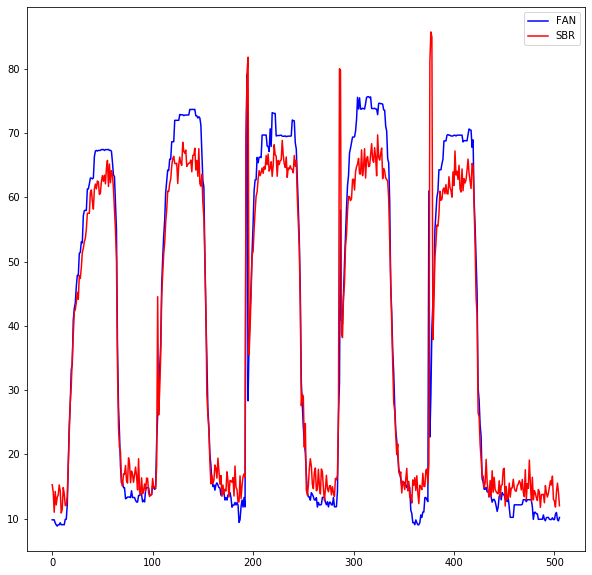

In [11]:
plt.figure(figsize=(10,10))
plt.plot(a,'b', label='FAN')
plt.plot(b,'r',label='SBR')
plt.legend(loc="upper right")

In [ ]:
color_file = os.path.join(root,name)
depth_file = color_file[:-10]+'_depth.avi'
if os.path.exists(depth_file):
    #create folder if it doesn't exist 
    landmarks_folder = os.path.join(root,sufix)
    if not os.path.exists(landmarks_folder):
        os.makedirs(landmarks_folder)

    try: 
        landmark_file = os.path.join(os.path.join(root,sufix),name[:-10]+'_landmarks.csv')
        if not os.path.exists(landmark_file):
            landmark_file = find_landmarks_video(device,
                                       color_file,
                                       localize_face=60,
                                       sufix = sufix,
                                       fix_head_position=10,
                                       face_alignment_net=face_alignment_net,
                                       face_detection_net=face_detection_net)

        landmark_file_filt = os.path.join(os.path.join(root,sufix),name[:-10]+'_landmarksFiltered.csv')
        if not os.path.exists(landmark_file_filt):
            landmark_file_filt = smooth_landmarks(landmark_file, color_file,  create_video=True)

        landmark_file_filt3D = os.path.join(os.path.join(root,sufix),name[:-10]+'_landmarksFiltered3D.csv')
        if not os.path.exists(landmark_file_filt3D):
            get3dlandmarks_video(depth_file, landmark_file_filt)

    except: 
        continue

# Testing Code Snippets 

In [ ]:
df_cols_p1 = ["Video_Frame_number", 'Time_Stamp (s)']
for i in range(0, 68):
    num = str(i)
    xx = 'landmark_' + num
    df_cols_p1.append(xx + '_x')
    df_cols_p1.append(xx + '_y')
    df_cols_p1.append(xx + '_z')

header = [np.array(df_cols_p1)]

DF_3dpositions = pd.DataFrame(columns=header)

DF_3dpositions.head()

In [ ]:
# trying to see the what the camera paramets are and do one frame analysis of .bag files 

BAG_File = '/media/deniz/easystore/facial_tracking_data_2021/ALS/AF18_SBK_20190826/02/RSSDK/AF18_02_20190826_NSM_OPEN.bag'

#BAG_File = '/media/deniz/easystore/facial_tracking_data_2021/Parkinsons/PD04_TRI_20200213/02/RSSDK/PD04_02_20200213_DDK_COUNT_1548.bag'



# start the process of extracting the video information for each video
pipeline = rs.pipeline()
config = rs.config()
print(config)
rs.config.enable_device_from_file(config, BAG_File, repeat_playback=False)

config.enable_all_streams()
profile = pipeline.start(config)

# create alignment object
align_to = rs.stream.color
align = rs.align(align_to)

# Getting the depth sensor's depth scale (see rs-align example for explanation)
depth_sensor = profile.get_device().first_depth_sensor()
depth_scale = depth_sensor.get_depth_scale()

# inform the device that this is not live streaming from camera
playback = profile.get_device().as_playback()
playback.set_real_time(False)
duration = playback.get_duration()

# fill holes in the depth information (based on this example: https://nbviewer.jupyter.org/github/IntelRealSense/librealsense/blob/jupyter/notebooks/depth_filters.ipynb)
spatial = rs.spatial_filter()
spatial.set_option(rs.option.filter_magnitude, 2)
spatial.set_option(rs.option.filter_smooth_alpha, 0.5)
spatial.set_option(rs.option.filter_smooth_delta, 20)
spatial.set_option(rs.option.holes_fill, 3)

    
 
frames = pipeline.wait_for_frames(100)

this_frame = frames.get_frame_number()  # get frame number

# verify that we have landmarks for this particular frame


    
# take color and depth from frame, if any to these is not available then skip the frame
aligned_frames = align.process(frames)

# take color and depth from frame, if any to these is not available then skip the frame
aligned_depth = aligned_frames.get_depth_frame()
aligned_color = aligned_frames.get_color_frame()



    
depth_intrin = aligned_depth.profile.as_video_stream_profile().intrinsics
print(depth_intrin)
color_intrin = aligned_depth.profile.as_video_stream_profile().intrinsics
print(color_intrin)
depth_to_color_extrin = aligned_depth.profile.get_extrinsics_to(aligned_color.profile)
print(depth_to_color_extrin)
print(aligned_color.profile)
aligned_filtered_depth = spatial.process(aligned_depth)
print(aligned_filtered_depth)
depth_frame_array = np.asanyarray(aligned_filtered_depth.as_frame().get_data())
depth_frame_array = depth_frame_array * depth_scale

In [ ]:
depth_sensor = profile.get_device().first_depth_sensor()
depth_sensor.get_option(rs.option.depth_units)

In [16]:
df_cols_p1 = ["Video_Frame_number", 'Time_Stamp (s)']
for i in range(0, 68):
    num = str(i)
    xx = 'landmark_' + num
    df_cols_p1.append(xx + '_x')
    df_cols_p1.append(xx + '_y')
    df_cols_p1.append(xx + '_z')

header = [np.array(df_cols_p1)]

DF_3dpositions = pd.DataFrame(columns=header)
DF_3dpositions.head()

,Video_Frame_number,Time_Stamp (s),landmark_0_x,landmark_0_y,landmark_0_z,landmark_1_x,landmark_1_y,landmark_1_z,landmark_2_x,landmark_2_y,...,landmark_64_z,landmark_65_x,landmark_65_y,landmark_65_z,landmark_66_x,landmark_66_y,landmark_66_z,landmark_67_x,landmark_67_y,landmark_67_z


In [25]:
DF_3dpositions['Time_Stamp (s)'] = x.Video_Frame_number.values

TypeError: only integer scalar arrays can be converted to a scalar index

In [23]:
x.Video_Frame_number.values.shape

(541,)

In [3]:
DF_3dpositions[['Time_Stamp (s)']]=x.Video_Frame_number.values

NameError: name 'x' is not defined

In [ ]:
len()